In [1]:
options(mc.cores = parallel::detectCores())
library(rethinking)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


In [2]:
a <- 3.5
b <- (-1)
sigma_a <- 1
sigma_b <- 0.5
rho <- (-0.7)


In [3]:
Mu <- c( a , b )

In [4]:
cov_ab <- sigma_a*sigma_b*rho
Sigma <- matrix( c(sigma_a^2,cov_ab,cov_ab,sigma_b^2) , ncol=2 )

In [5]:
matrix( c(1,2,3,4) , nrow=2 , ncol=2 )

[,1] [,2]
[1,] 1    3   
[2,] 2    4

In [6]:
sigmas <- c(sigma_a,sigma_b) # standard deviations
Rho <- matrix( c(1,rho,rho,1) , nrow=2 ) # correlation matrix

# now matrix multiply to get covariance matrix
Sigma <- diag(sigmas) %*% Rho %*% diag(sigmas)

In [7]:
Sigma

[,1]  [,2] 
[1,]  1.00 -0.35
[2,] -0.35  0.25

In [8]:
N_cafes <- 20

In [9]:
library(MASS)
set.seed(5) # used to replicate example
vary_effects <- mvrnorm( N_cafes , Mu , Sigma )

In [10]:
vary_effects

[,1]     [,2]      
 [1,] 4.223962 -1.6093565
 [2,] 2.010498 -0.7517704
 [3,] 4.565811 -1.9482646
 [4,] 3.343635 -1.1926539
 [5,] 1.700971 -0.5855618
 [6,] 4.134373 -1.1444539
 [7,] 3.794469 -1.6264661
 [8,] 3.946598 -1.7152794
 [9,] 3.864267 -0.9071677
[10,] 3.467614 -0.6804054
[11,] 2.242875 -0.6181516
[12,] 4.159506 -1.6592120
[13,] 4.300283 -2.1125474
[14,] 3.506948 -1.4406430
[15,] 4.382086 -1.8798983
[16,] 3.521133 -1.3506986
[17,] 4.216713 -0.9192799
[18,] 5.913003 -1.2313624
[19,] 3.477306 -0.3570341
[20,] 3.774899 -1.0570457

In [11]:
a_cafe <- vary_effects[,1]
b_cafe <- vary_effects[,2]

In [12]:
install.packages("ellipse")

Installing package into ‘/home/rer/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)



Attaching package: ‘ellipse’

The following object is masked from ‘package:rethinking’:

    pairs

The following object is masked from ‘package:graphics’:

    pairs



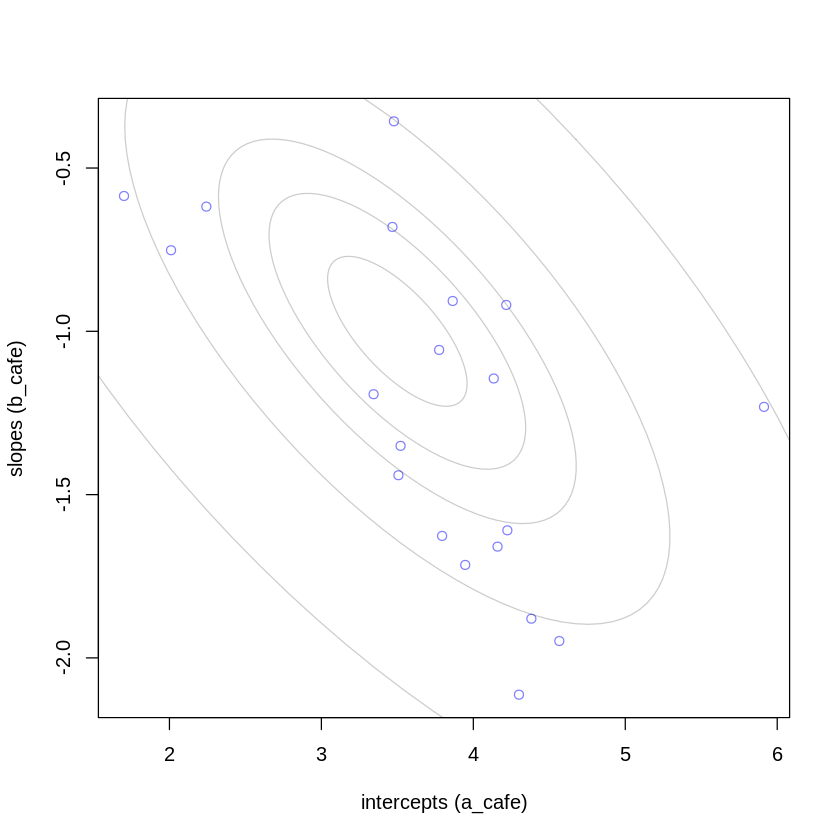

In [13]:
plot( a_cafe , b_cafe , col=rangi2 ,
xlab="intercepts (a_cafe)" , ylab="slopes (b_cafe)" )

# overlay population distribution
library(ellipse)
for ( l in c(0.1,0.3,0.5,0.8,0.99) )
lines(ellipse(Sigma,centre=Mu,level=l),col=col.alpha("black",0.2))

In [14]:
set.seed(22)
N_visits <- 10
afternoon <- rep(0:1,N_visits*N_cafes/2)
cafe_id <- rep( 1:N_cafes , each=N_visits )
mu <- a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma <- 0.5 # std dev within cafes
wait <- rnorm( N_visits*N_cafes , mu , sigma )
d <- data.frame( cafe=cafe_id , afternoon=afternoon , wait=wait )

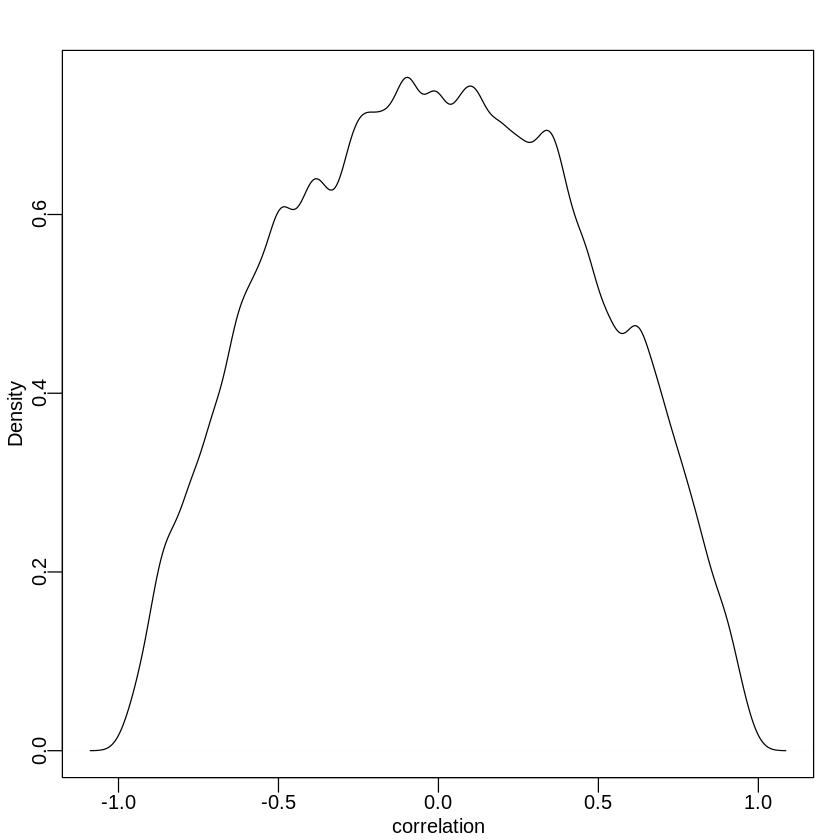

In [15]:
R <- rlkjcorr( 1e4 , K=2 , eta=2 )
dens( R[,1,2] , xlab="correlation" )

In [16]:
m14.1 <- ulam(
                alist(
                    wait ~ normal( mu , sigma ),
                    mu <- a_cafe[cafe] + b_cafe[cafe]*afternoon,
                    c(a_cafe,b_cafe)[cafe] ~ multi_normal( c(a,b) , Rho , sigma_cafe ),
                    a ~ normal(5,2),
                    b ~ normal(-1,0.5),
                    sigma_cafe ~ exponential(1),
                    sigma ~ exponential(1),
                    Rho ~ lkj_corr(2)
                ) , data=d , chains=4 , cores=4 )

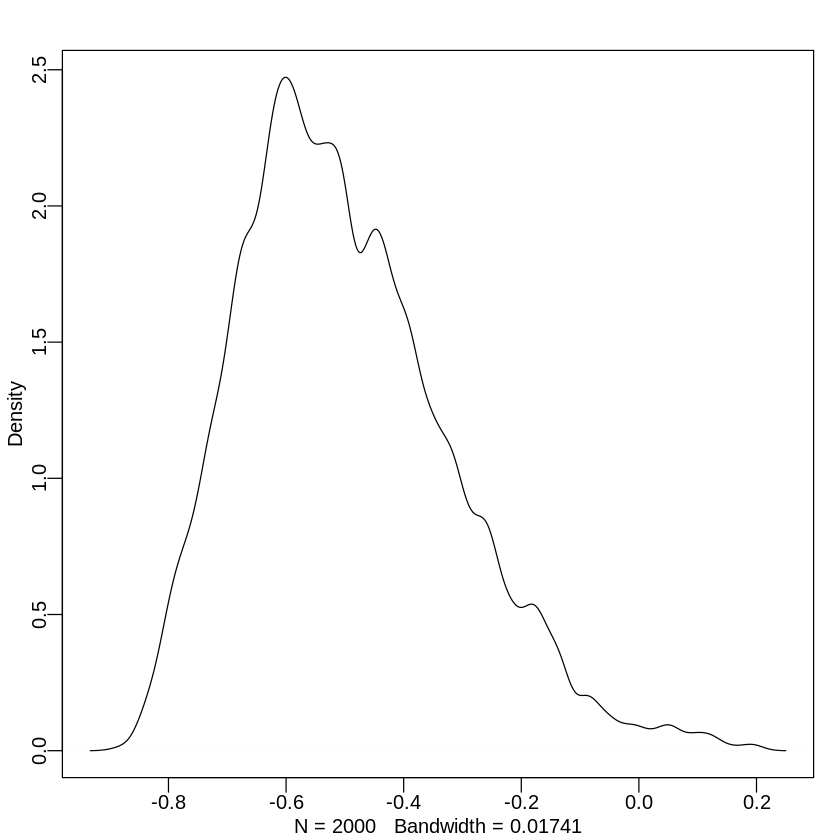

In [17]:
post <- extract.samples(m14.1)
dens( post$Rho[,1,2] )

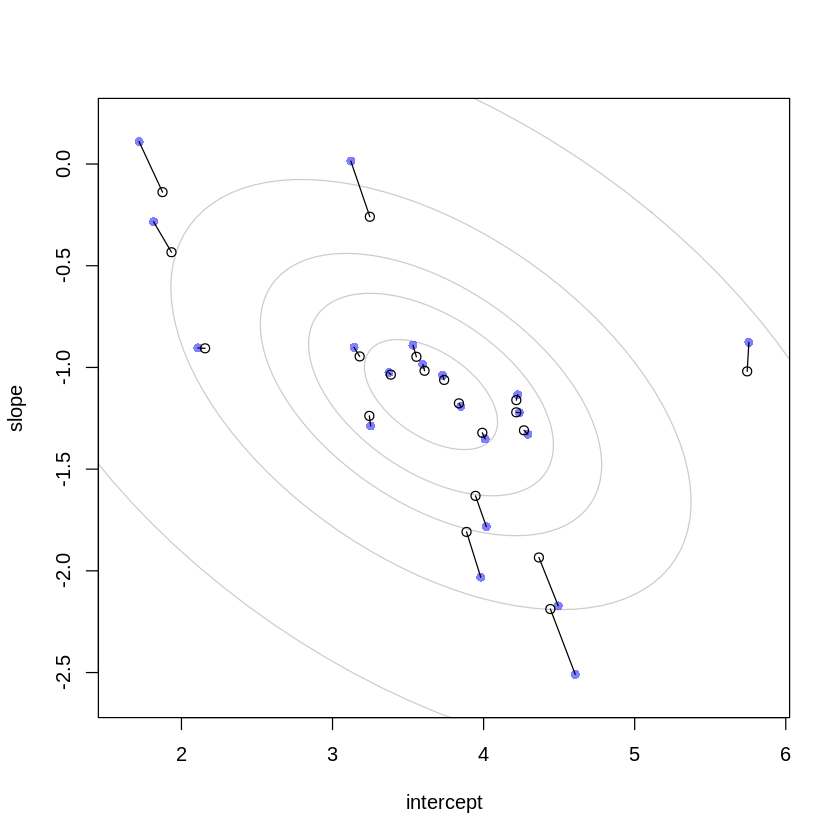

In [18]:
# compute unpooled estimates directly from data
a1 <- sapply( 1:N_cafes ,
function(i) mean(wait[cafe_id==i & afternoon==0]) )
b1 <- sapply( 1:N_cafes ,
function(i) mean(wait[cafe_id==i & afternoon==1]) ) - a1

# extract posterior means of partially pooled estimates
post <- extract.samples(m14.1)
a2 <- apply( post$a_cafe , 2 , mean )
b2 <- apply( post$b_cafe , 2 , mean )

# plot both and connect with lines
plot( a1 , b1 , xlab="intercept" , ylab="slope" ,
pch=16 , col=rangi2 , ylim=c( min(b1)-0.1 , max(b1)+0.1 ) ,
xlim=c( min(a1)-0.1 , max(a1)+0.1 ) )
points( a2 , b2 , pch=1 )
for ( i in 1:N_cafes ) lines( c(a1[i],a2[i]) , c(b1[i],b2[i]) )
             
             
# compute posterior mean bivariate Gaussian
Mu_est <- c( mean(post$a) , mean(post$b) )
rho_est <- mean( post$Rho[,1,2] )
sa_est <- mean( post$sigma_cafe[,1] )
sb_est <- mean( post$sigma_cafe[,2] )
cov_ab <- sa_est*sb_est*rho_est
Sigma_est <- matrix( c(sa_est^2,cov_ab,cov_ab,sb_est^2) , ncol=2 )

# draw contours
library(ellipse)
for ( l in c(0.1,0.3,0.5,0.8,0.99) )
lines(ellipse(Sigma_est,centre=Mu_est,level=l),
col=col.alpha("black",0.2))             
             

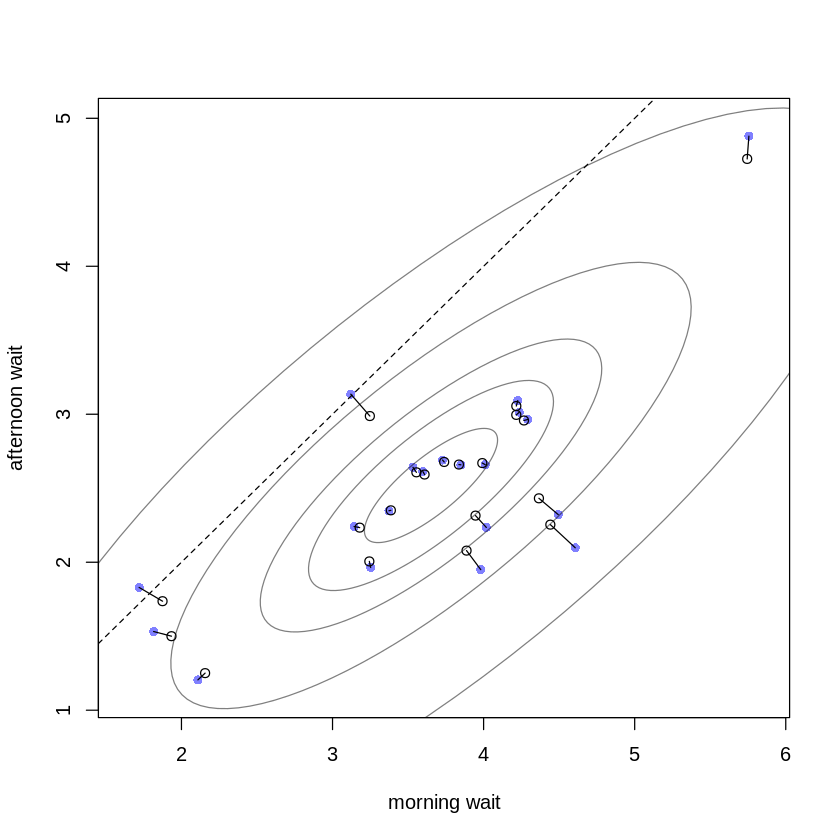

In [19]:
# convert varying effects to waiting times
wait_morning_1 <- (a1)
wait_afternoon_1 <- (a1 + b1)
wait_morning_2 <- (a2)
wait_afternoon_2 <- (a2 + b2)

# plot both and connect with lines
plot( wait_morning_1 , wait_afternoon_1 , xlab="morning wait" ,
ylab="afternoon wait" , pch=16 , col=rangi2 ,
ylim=c( min(wait_afternoon_1)-0.1 , max(wait_afternoon_1)+0.1 ) ,
xlim=c( min(wait_morning_1)-0.1 , max(wait_morning_1)+0.1 ) )
points( wait_morning_2 , wait_afternoon_2 , pch=1 )
for ( i in 1:N_cafes )
lines( c(wait_morning_1[i],wait_morning_2[i]) ,
c(wait_afternoon_1[i],wait_afternoon_2[i]) )
abline( a=0 , b=1 , lty=2 )


# now shrinkage distribution by simulation
v <- mvrnorm( 1e4 , Mu_est , Sigma_est )
v[,2] <- v[,1] + v[,2] # calculate afternoon wait
Sigma_est2 <- cov(v)
Mu_est2 <- Mu_est
Mu_est2[2] <- Mu_est[1]+Mu_est[2]

# draw contours
library(ellipse)
for ( l in c(0.1,0.3,0.5,0.8,0.99) )
lines(ellipse(Sigma_est2,centre=Mu_est2,level=l),
col=col.alpha("black",0.5))

In [20]:
library(rethinking)
data(chimpanzees)
d <- chimpanzees

d$block_id <- d$block
d$treatment <- 1L + d$prosoc_left + 2L*d$condition
dat <- list(
            L = d$pulled_left,
            tid = d$treatment,
            actor = d$actor,
            block_id = as.integer(d$block_id) )

m14.2 <- ulam(
            alist(
                L ~ binomial(1,p),
                logit(p) <- g[tid] + alpha[actor,tid] + beta[block_id,tid],
                
                # adaptive priors
                vector[4]:alpha[actor] ~ multi_normal(0,Rho_actor,sigma_actor),
                vector[4]:beta[block_id] ~ multi_normal(0,Rho_block,sigma_block),
                
                # fixed priors
                g[tid] ~ dnorm(0,1),
                sigma_actor ~ dexp(1),
                Rho_actor ~ dlkjcorr(4),
                sigma_block ~ dexp(1),
                Rho_block ~ dlkjcorr(4)
            ) , data=dat , chains=4 , cores=4
            , log_lik=TRUE 
            )



Warning message:
“There were 27 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [21]:
m14.3 <- ulam(
            alist(
                L ~ binomial(1,p),
                logit(p) <- g[tid] + alpha[actor,tid] + beta[block_id,tid],

                # adaptive priors - non-centered
                transpars> matrix[actor,4]:alpha <-
                compose_noncentered( sigma_actor , L_Rho_actor , z_actor ),
                transpars> matrix[block_id,4]:beta <-
                compose_noncentered( sigma_block , L_Rho_block , z_block ),
                matrix[4,actor]:z_actor ~ normal( 0 , 1 ),
                matrix[4,block_id]:z_block ~ normal( 0 , 1 ),
                
                # fixed priors
                g[tid] ~ normal(0,1),
                vector[4]:sigma_actor ~ dexp(1),
                cholesky_factor_corr[4]:L_Rho_actor ~ lkj_corr_cholesky( 2 ),
                vector[4]:sigma_block ~ dexp(1),
                cholesky_factor_corr[4]:L_Rho_block ~ lkj_corr_cholesky( 2 ),
                
                # compute ordinary correlation matrixes from Cholesky factors
                gq> matrix[4,4]:Rho_actor <<- multiply_lower_tri_self_transpose(L_Rho_actor),
                gq> matrix[4,4]:Rho_block <<- multiply_lower_tri_self_transpose(L_Rho_block)
                ) , data=dat , chains=4 , cores=4 , log_lik=TRUE )

In [22]:
precis(m14.3, depth=3)

mean        sd        5.5%        94.5%       n_eff     Rhat     
z_actor[1,1] -0.61753366 0.4799552 -1.4230415   0.10112151  867.2102 1.0066159
z_actor[1,2]  2.36683476 0.6915500  1.3124262   3.52339919 1062.0148 1.0003219
z_actor[1,3] -0.83756477 0.5060307 -1.7089955  -0.11423933  818.8869 1.0039651
z_actor[1,4] -0.70742952 0.5105019 -1.5818361   0.04112951  922.0744 1.0026933
z_actor[1,5] -0.62029284 0.4511643 -1.3820940   0.05659036  840.7790 1.0036782
z_actor[1,6]  0.59803496 0.4640155 -0.1081077   1.37305012  928.2649 0.9990894
z_actor[1,7]  0.98332249 0.5654806  0.1369471   1.93581407  970.1821 0.9993190
z_actor[2,1] -0.35768401 0.6244295 -1.3417853   0.65357236 1029.7669 1.0038913
z_actor[2,2]  1.37435711 0.9457771 -0.1715859   2.85401381 1003.6446 1.0047096
z_actor[2,3] -0.03138681 0.6801848 -1.1121509   1.04772001  889.4151 1.0042618
z_actor[2,4] -0.44774134 0.6636438 -1.4750843   0.63776844  978.2424 1.0012513
z_actor[2,5] -0.18815709 0.6202674 -1.1549430   0.82919911 1031.6323 1.0027395
z_actor[2,6] -0.37490426 0.6685299 -1.4582550   0.66987679 1111.7478 1.0027901
z_actor[2,7]  0.74674971 0.8142359 -0.5564514   1.98783765  866.9342 1.0061951
z_actor[3,1] -0.09654430 0.6690447 -1.1538049   1.00748791 1201.2636 0.9995140
z_actor[3,2]  0.81072872 0.9672823 -0.8233235   2.32729661 1308.3210 1.0002736
z_actor[3,3] -0.49004825 0.7236824 -1.6379618   0.66112837  957.8894 1.0027072
z_actor[3,4] -0.61908538 0.7004246 -1.7175301   0.52560590 1209.1627 1.0013885
z_actor[3,5] -0.16924606 0.6582357 -1.1846566   0.90914986 1279.2059 0.9991454
z_actor[3,6] -0.10261143 0.6581601 -1.1567532   0.91407411  731.9046 1.0051932
z_actor[3,7]  0.91147475 0.8261198 -0.3909506   2.24858613 1373.4819 1.0010979
z_actor[4,1]  0.06020471 0.7345975 -1.1254473   1.24363204 1309.4229 1.0045443
z_actor[4,2]  0.46162075 0.9502207 -1.0646923   1.89858670 2300.6180 0.9992467
z_actor[4,3] -0.41302229 0.7713183 -1.6903582   0.80056164 1457.4189 0.9996652
z_actor[4,4]  0.01540174 0.7509209 -1.1994296   1.20278398 1935.3142 0.9992338
z_actor[4,5] -0.04825814 0.7152830 -1.1760485   1.08100444 1687.6201 0.9992672
z_actor[4,6] -0.29495045 0.7714185 -1.4883608   0.91806723 1540.1967 0.9987823
z_actor[4,7]  0.86177487 0.8926991 -0.5861717   2.27604022 2058.2871 0.9988689
z_block[1,1] -0.27782031 0.8619525 -1.6802889   1.07075313 1997.7269 0.9997738
z_block[1,2]  0.15700586 0.8344278 -1.1499574   1.47582634 1787.0518 1.0016918
⋮            ⋮           ⋮         ⋮           ⋮           ⋮         ⋮        
beta[6,3]    -0.03868924 0.3045629 -0.55915021  0.40236828 1899.3461 1.0013769
beta[6,4]     0.29871919 0.4633258 -0.20786031  1.18006718 1186.8644 1.0009425
alpha[1,1]   -0.79402976 0.6057302 -1.78373421  0.14446051 1035.6121 1.0028296
alpha[1,2]   -0.50327612 0.4830299 -1.31579892  0.20480512 1136.0800 1.0022558
alpha[1,3]   -0.93262506 0.7326163 -2.11422541  0.20261600 1262.9876 1.0009410
alpha[1,4]   -0.53993343 0.6450538 -1.58048838  0.48167573 1323.7498 1.0006750
alpha[2,1]    3.18323161 1.1956822  1.61096911  5.24358286 1488.5501 1.0004981
alpha[2,2]    2.07146428 0.9951202  0.76925012  3.82848420 1708.2976 0.9999348
alpha[2,3]    4.41166302 1.6043130  2.32912321  7.41269097 1778.0791 1.0009464
alpha[2,4]    3.43932961 1.6074282  1.52270203  6.08007767 1638.4017 1.0009399
alpha[3,1]   -1.07270806 0.6081156 -2.10227826 -0.15555412 1027.7979 0.9996472
alpha[3,2]   -0.31896601 0.4862322 -1.07841172  0.43020263 1049.2508 1.0019073
alpha[3,3]   -1.53886317 0.7842224 -2.78636601 -0.35447737 1029.8802 1.0007894
alpha[3,4]   -1.26084928 0.6753271 -2.34806841 -0.25035541 1214.0052 1.0024656
alpha[4,1]   -0.89482423 0.6158390 -1.91047220  0.05520536 1019.8683 1.0000376
alpha[4,2]   -0.58313711 0.4991092 -1.38998735  0.16226779 1008.5068 1.0029557
alpha[4,3]   -1.80624366 0.8075304 -3.22082293 -0.60291941 1291.0768 1.0006770
alpha[4,4]   -0.97059945 0.6521317 -2.01102687  0.03566717 1313.3966 0.9990902
alpha[5,1]   -0.79747672 0.5804366 -1.73277775  0.08204702 1011

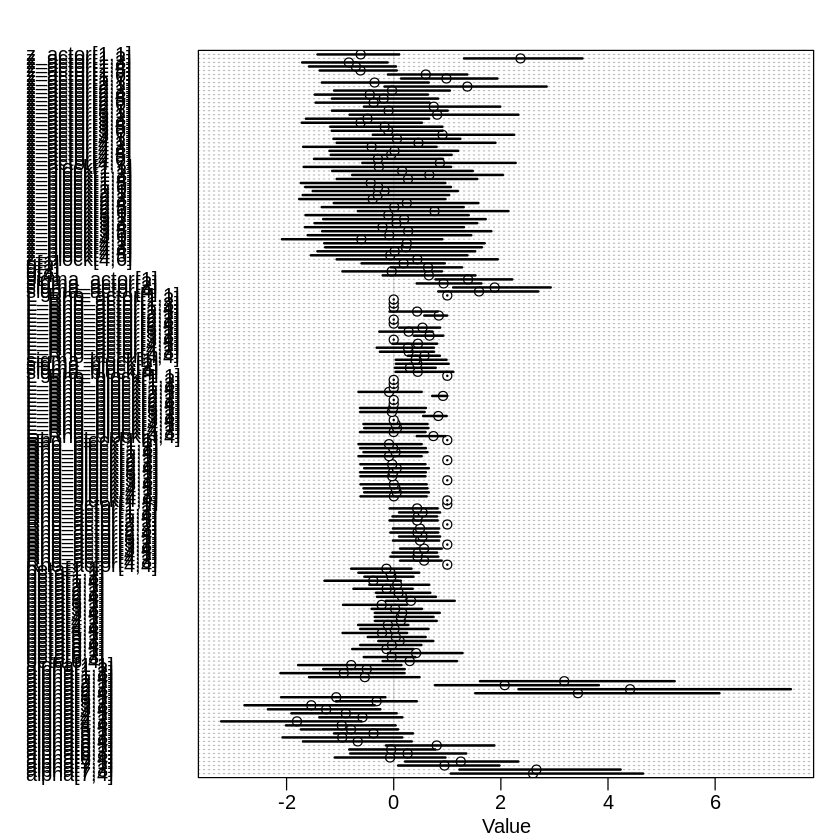

In [23]:
plot(precis(m14.3, depth=3))

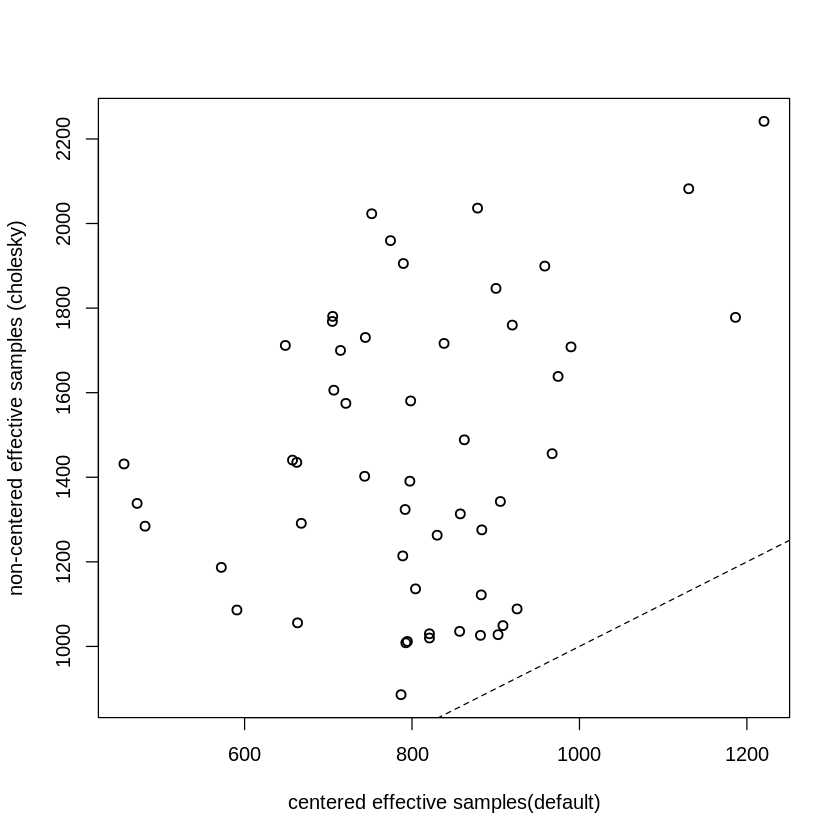

In [24]:
# extract n_eff values for each model
neff_nc <- precis(m14.3,depth=3,pars=c("alpha","beta"))$n_eff
neff_c <- precis(m14.2,depth=3,pars=c("alpha","beta"))$n_eff
plot( neff_c , neff_nc , xlab="centered effective samples(default)" ,
ylab="non-centered effective samples (cholesky)" , lwd=1.5 )
abline(a=0,b=1,lty=2)

In [25]:
compare(m14.3, m14.2)

WAIC     pWAIC    dWAIC   weight    SE       dSE      
m14.3 544.0467 26.55608 0.00000 0.8596692 19.68340        NA
m14.2 547.6718 28.11207 3.62509 0.1403308 19.71168 0.7942442

In [26]:
compare(m14.3, m14.2, func=LOO)

Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

LOO      pLOO     dLOO     weight    SE       dSE      
m14.3 544.7085 26.88698 0.000000 0.8658235 19.75610        NA
m14.2 548.4376 28.49495 3.729049 0.1341765 19.80204 0.8087228

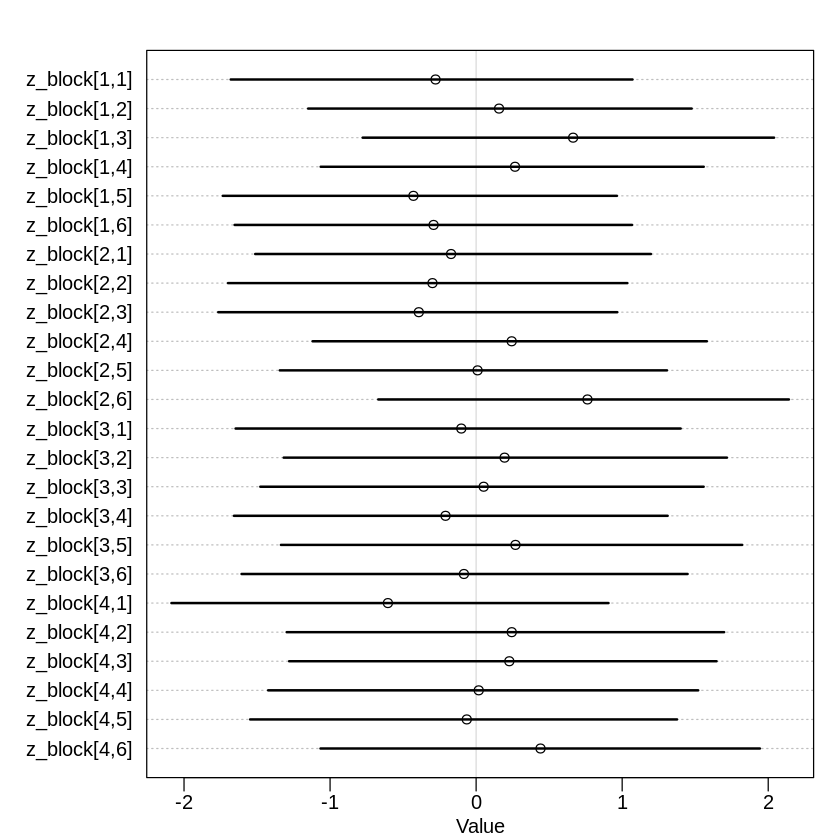

In [27]:
plot(precis(m14.3, depth=3, pars="z_block"))

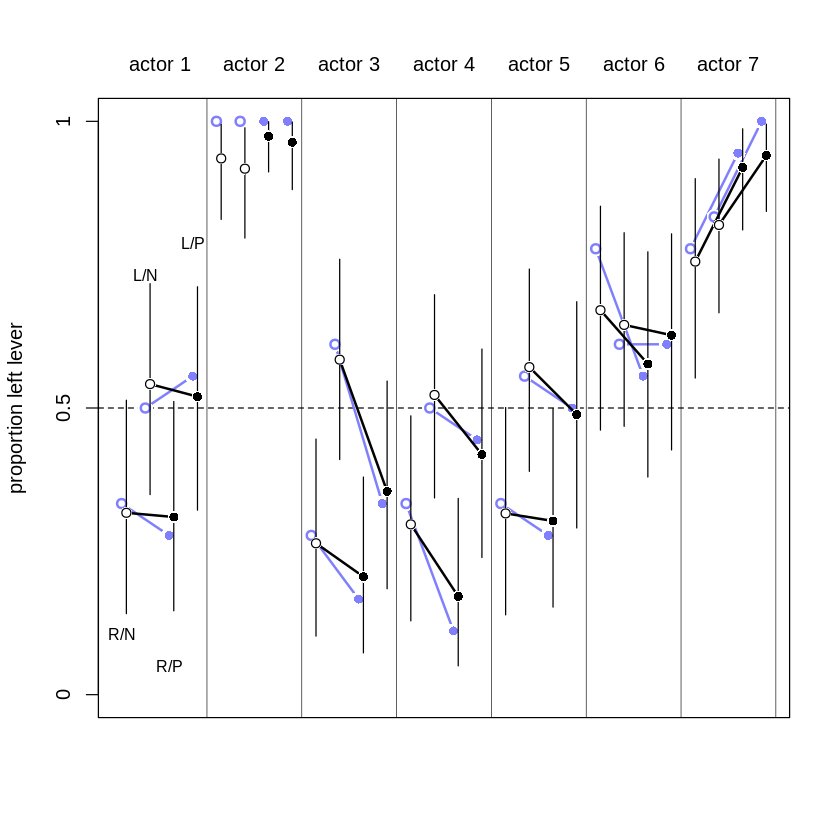

In [28]:
# compute mean for each actor in each treatment
pl <- by( d$pulled_left , list( d$actor , d$treatment ) , mean )

# generate posterior predictions using link
datp <- list(
actor=rep(1:7,each=4) ,
tid=rep(1:4,times=7) ,
block_id=rep(5,times=4*7) )
p_post <- link( m14.3 , data=datp )
p_mu <- apply( p_post , 2 , mean )
p_ci <- apply( p_post , 2 , PI )

# set up plot
plot( NULL , xlim=c(1,28) , ylim=c(0,1) , xlab="" ,
ylab="proportion left lever" , xaxt="n" , yaxt="n" )
axis( 2 , at=c(0,0.5,1) , labels=c(0,0.5,1) )
abline( h=0.5 , lty=2 )
for ( j in 1:7 ) abline( v=(j-1)*4+4.5 , lwd=0.5 )
for ( j in 1:7 ) text( (j-1)*4+2.5 , 1.1 , concat("actor ",j) , xpd=TRUE )

xo <- 0.1 # offset distance to stagger raw data and predictions

# raw data
for ( j in (1:7)[-2] ) {
lines( (j-1)*4+c(1,3)-xo , pl[j,c(1,3)] , lwd=2 , col=rangi2 )
lines( (j-1)*4+c(2,4)-xo , pl[j,c(2,4)] , lwd=2 , col=rangi2 )
}
points( 1:28-xo , t(pl) , pch=16 , col="white" , cex=1.7 )
points( 1:28-xo , t(pl) , pch=c(1,1,16,16) , col=rangi2 , lwd=2 )
yoff <- 0.2
text( 1-xo , pl[1,1]-yoff,"R/N",pos=1,cex=0.8)
text( 2-xo , pl[1,2]+yoff,"L/N",pos=3,cex=0.8)
text( 3-xo , pl[1,3]-yoff,"R/P",pos=1,cex=0.8)
text( 4-xo , pl[1,4]+yoff,"L/P",pos=3,cex=0.8)

# posterior predictions
for ( j in (1:7)[-2] ) {
    lines( (j-1)*4+c(1,3)+xo , p_mu[(j-1)*4+c(1,3)] , lwd=2 )
    lines( (j-1)*4+c(2,4)+xo , p_mu[(j-1)*4+c(2,4)] , lwd=2 )
}
for ( i in 1:28 ) lines( c(i,i)+xo , p_ci[,i] , lwd=1 )
points( 1:28+xo , p_mu , pch=16 , col="white" , cex=1.3 )
points( 1:28+xo , p_mu , pch=c(1,1,16,16) )

In [29]:
stancode(m14.3)

data{
    int L[504];
    int block_id[504];
    int actor[504];
    int tid[504];
}
parameters{
    matrix[4,7] z_actor;
    matrix[4,6] z_block;
    vector[4] g;
    vector<lower=0>[4] sigma_actor;
    cholesky_factor_corr[4] L_Rho_actor;
    vector<lower=0>[4] sigma_block;
    cholesky_factor_corr[4] L_Rho_block;
}
transformed parameters{
    matrix[7,4] alpha;
    matrix[6,4] beta;
    beta = (diag_pre_multiply(sigma_block, L_Rho_block) * z_block)';
    alpha = (diag_pre_multiply(sigma_actor, L_Rho_actor) * z_actor)';
}
model{
    vector[504] p;
    L_Rho_block ~ lkj_corr_cholesky( 2 );
    sigma_block ~ exponential( 1 );
    L_Rho_actor ~ lkj_corr_cholesky( 2 );
    sigma_actor ~ exponential( 1 );
    g ~ normal( 0 , 1 );
    to_vector( z_block ) ~ normal( 0 , 1 );
    to_vector( z_actor ) ~ normal( 0 , 1 );
    for ( i in 1:504 ) {
        p[i] = g[tid[i]] + alpha[actor[i], tid[i]] + beta[block_id[i], tid[i]];
        p[i] = inv_logit(p[i]);
    }
    L ~ binomial( 1 , p );
}
gen

In [30]:
set.seed(73)
N <- 500

U_sim <- rnorm( N )
Q_sim <- sample( 1:4 , size=N , replace=TRUE )
E_sim <- rnorm( N , U_sim + Q_sim )
W_sim <- rnorm( N , U_sim + 0*E_sim )

dat_sim <- list(
                W=standardize(W_sim) ,
                E=standardize(E_sim) ,
                Q=standardize(Q_sim) )

In [31]:
m14.4 <- ulam(
            alist(
                W ~ dnorm( mu , sigma ),
                mu <- aW + bEW*E,
                aW ~ dnorm( 0 , 0.2 ),
                bEW ~ dnorm( 0 , 0.5 ),
                sigma ~ dexp( 1 )
                ) , data=dat_sim , chains=4 , cores=4,
                log_lik=TRUE
                )

precis( m14.4 )

mean         sd         5.5%       94.5%      n_eff    Rhat     
aW    -0.000242611 0.04064180 -0.0661639 0.06426641 1951.946 1.0026192
bEW    0.398419108 0.04085636  0.3348046 0.46060691 1944.176 0.9992465
sigma  0.918903898 0.03026494  0.8719642 0.96936890 1382.326 0.9995344

In [32]:
m14.5 <- ulam(
            alist(
                c(W,E) ~ multi_normal(c(muW,muE) , Rho , Sigma ),
                muW <- aW + bEW*E,
                muE <- aE + bQE*Q,
                c(aW,aE) ~ normal( 0 , 0.2 ),
                c(bEW,bQE) ~ normal( 0, 0.5 ),
                Rho ~ lkj_corr( 2 ),
                Sigma ~ exponential( 1 )
                ), data=dat_sim , chains=4, cores=4 )
   
precis( m14.5 , depth=3 )

mean          sd           5.5%        94.5%      n_eff     Rhat     
aE       -0.0009462924 3.649156e-02 -0.05861398 0.05569336 1378.3726 1.0005029
aW       -0.0001773620 4.443351e-02 -0.07158054 0.07050074 1563.2355 0.9989986
bQE       0.5871297537 3.500801e-02  0.53035407 0.64314854 1111.2260 1.0006733
bEW      -0.0512556884 7.579855e-02 -0.17192313 0.06818140  716.1019 1.0041687
Rho[1,1]  1.0000000000 0.000000e+00  1.00000000 1.00000000       NaN       NaN
Rho[1,2]  0.5434407821 5.193702e-02  0.45610859 0.62520270  730.5277 1.0035508
Rho[2,1]  0.5434407821 5.193702e-02  0.45610859 0.62520270  730.5277 1.0035508
Rho[2,2]  1.0000000000 7.303178e-17  1.00000000 1.00000000  540.5756 0.9979980
Sigma[1]  1.0244726392 4.702611e-02  0.95610416 1.10487092  729.9842 1.0030199
Sigma[2]  0.8084673357 2.591288e-02  0.76870509 0.85030113 1586.1319 0.9989154

In [33]:
m14.4x <- ulam( m14.4 , data=dat_sim , chains=4 , cores=4 )
m14.5x <- ulam( m14.5 , data=dat_sim , chains=4 , cores=4 )

In [34]:
precis(m14.4x)

mean          sd         5.5%        94.5%      n_eff    Rhat    
aW    -0.0005195693 0.03944388 -0.06465043 0.06240565 1913.385 1.000060
bEW    0.3975803393 0.04020558  0.33220547 0.46129959 2028.005 1.000483
sigma  0.9185333240 0.02914289  0.87302756 0.96632750 2014.081 1.000054

In [35]:
set.seed(73)
N <- 500

U_sim <- rnorm( N )
Q_sim <- sample( 1:4 , size=N , replace=TRUE )
E_sim <- rnorm( N , U_sim + Q_sim )
W_sim <- rnorm( N , -U_sim + 0.2*E_sim )

dat_sim <- list(
                W=standardize(W_sim) ,
                E=standardize(E_sim) ,
                Q=standardize(Q_sim) )

In [36]:
m14.4x2 <- ulam( m14.4 , data=dat_sim , chains=4 , cores=4 )
m14.5x2 <- ulam( m14.5 , data=dat_sim , chains=4 , cores=4 )

In [37]:
precis(m14.4x2)

mean          sd         5.5%        94.5%       n_eff    Rhat    
aW     8.972189e-05 0.04347848 -0.07012275  0.06980247 1819.994 1.001898
bEW   -1.140880e-01 0.04335801 -0.18218471 -0.04707266 1793.423 1.001890
sigma  9.962962e-01 0.03283347  0.94538285  1.04936165 1828.929 1.000204

In [38]:
precis(m14.5x2, depth=3)

mean          sd           5.5%        94.5%       n_eff    Rhat     
aE        0.0008725869 3.395860e-02 -0.05436436  0.05524612 1653.225 0.9999025
aW       -0.0008395781 4.654696e-02 -0.07509974  0.07289912 1695.251 0.9999092
bQE       0.5891700544 3.611664e-02  0.53007611  0.64609509 1631.651 1.0009537
bEW       0.2870970675 8.289196e-02  0.15915598  0.42220343 1023.494 1.0028381
Rho[1,1]  1.0000000000 0.000000e+00  1.00000000  1.00000000      NaN       NaN
Rho[1,2] -0.4633926156 5.959401e-02 -0.55671748 -0.36375344 1025.656 1.0022117
Rho[2,1] -0.4633926156 5.959401e-02 -0.55671748 -0.36375344 1025.656 1.0022117
Rho[2,2]  1.0000000000 7.523591e-17  1.00000000  1.00000000 1411.652 0.9979980
Sigma[1]  1.0762408256 4.666720e-02  1.00663944  1.15370109 1073.198 0.9994651
Sigma[2]  0.8099578676 2.662630e-02  0.76900216  0.85455436 1517.785 0.9994101

In [39]:
library(dagitty)

dagIV <- dagitty( "dag{
                        E -> W
                        E <- U -> W
                        Q -> E
                        }")

instrumentalVariables( dagIV , exposure="E" , outcome="W" )

 Q

In [40]:
library(rethinking)
data(KosterLeckie)
head(kl_dyads)

hidA hidB did giftsAB giftsBA offset drel1 drel2 drel3 drel4 dlndist dass 
1 1    2    1   0        4       0.000 0     0     1     0     -2.790  0.000
2 1    3    2   6       31      -0.003 0     1     0     0     -2.817  0.044
3 1    4    3   2        5      -0.019 0     1     0     0     -1.886  0.025
4 1    5    4   4        2       0.000 0     1     0     0     -1.892  0.011
5 1    6    5   8        2      -0.003 1     0     0     0     -3.499  0.022
6 1    7    6   2        1       0.000 0     0     0     0     -1.853  0.071
  d0125
1 0    
2 0    
3 0    
4 0    
5 0    
6 0

In [41]:
# head(kl_households)

In [42]:
kl_data <- list(
                N = nrow(kl_dyads),
                N_households = max(kl_dyads$hidB),
                did = kl_dyads$did,
                hidA = kl_dyads$hidA,
                hidB = kl_dyads$hidB,
                giftsAB = kl_dyads$giftsAB,
                giftsBA = kl_dyads$giftsBA
                )

m14.6 <- ulam(
            alist(
                giftsAB ~ poisson( lambdaAB ),
                giftsBA ~ poisson( lambdaBA ),
                log(lambdaAB) <- a + gr[hidA,1] + gr[hidB,2] + d[did,1] ,
                log(lambdaBA) <- a + gr[hidB,1] + gr[hidA,2] + d[did,2] ,
                a ~ normal(0,1),         

                ## gr matrix of varying effects
                vector[2]:gr[N_households] ~ multi_normal(0,Rho_gr,sigma_gr),
                Rho_gr ~ lkj_corr(4),
                sigma_gr ~ exponential(1),

                ## dyad effects
                transpars> matrix[N,2]:d <-
                compose_noncentered( rep_vector(sigma_d,2) , L_Rho_d , z ),
                matrix[2,N]:z ~ normal( 0 , 1 ),
                cholesky_factor_corr[2]:L_Rho_d ~ lkj_corr_cholesky( 8 ),
                sigma_d ~ exponential(1),
                
                ## compute correlation matrix for dyads
                gq> matrix[2,2]:Rho_d <<- Chol_to_Corr( L_Rho_d )
                ),
            data=kl_data , chains=4 , cores=4 , iter=2000 )

In [43]:
precis( m14.6 , depth=3 , pars=c("Rho_gr","sigma_gr") )

mean       sd           5.5%       94.5%       n_eff    Rhat     
Rho_gr[1,1]  1.0000000 0.000000e+00  1.0000000  1.00000000      NaN       NaN
Rho_gr[1,2] -0.4049430 1.967515e-01 -0.6988944 -0.07167358 1721.164 1.0009444
Rho_gr[2,1] -0.4049430 1.967515e-01 -0.6988944 -0.07167358 1721.164 1.0009444
Rho_gr[2,2]  1.0000000 7.319129e-17  1.0000000  1.00000000  239.951 0.9989995
sigma_gr[1]  0.8318677 1.366653e-01  0.6410761  1.06155068 2012.642 1.0009583
sigma_gr[2]  0.4210445 9.058772e-02  0.2907241  0.57698379 1113.701 1.0014482

In [44]:
post <- extract.samples( m14.6 )
g <- sapply( 1:25 , function(i) post$a + post$gr[,i,1] )
r <- sapply( 1:25 , function(i) post$a + post$gr[,i,2] )
Eg_mu <- apply( exp(g) , 2 , mean )
Er_mu <- apply( exp(r) , 2 , mean )

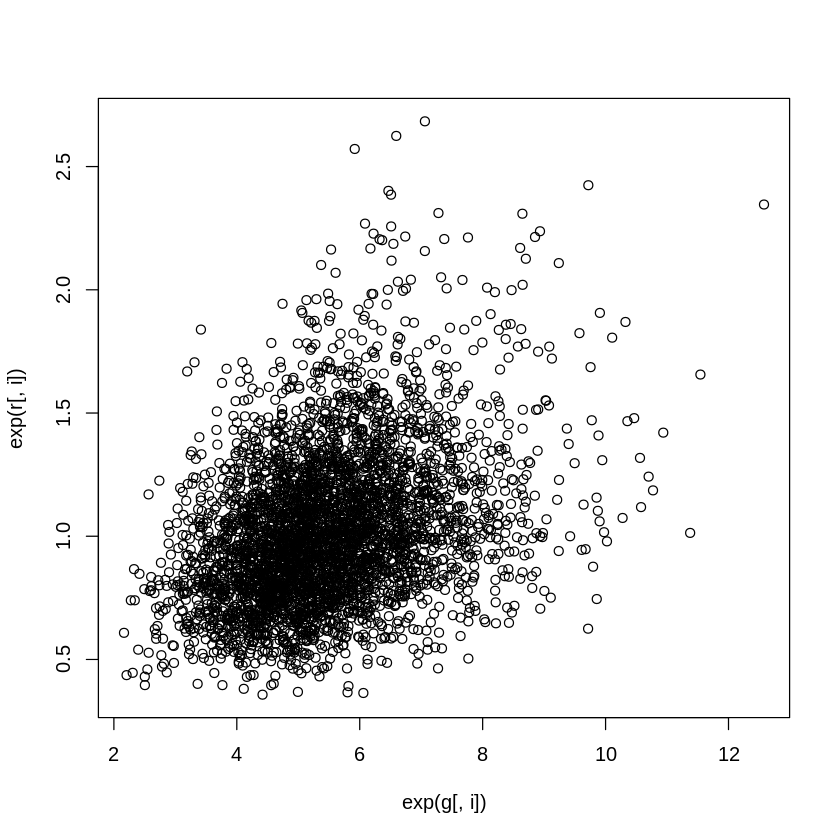

In [49]:
i <- 23  # Check out household i
plot(exp(g[,i]),exp(r[,i]))

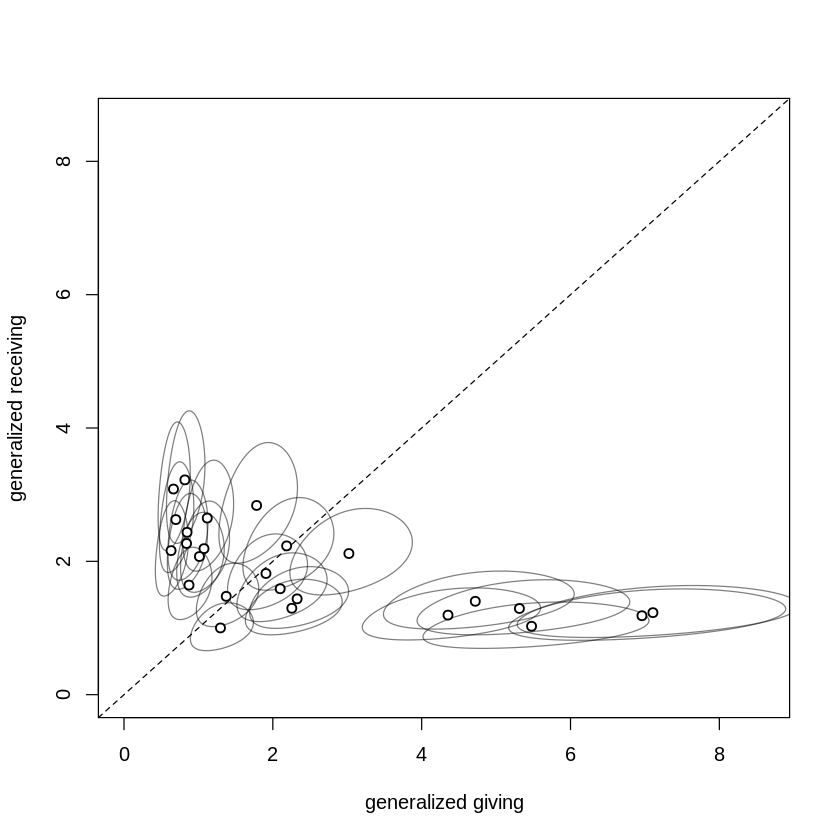

In [64]:
plot( NULL , xlim=c(0,8.6) , ylim=c(0,8.6) , xlab="generalized giving" ,
ylab="generalized receiving" , lwd=1.5 )
abline(a=0,b=1,lty=2)

# ellipses
library(ellipse)
for ( i in 1:25 ) {
Sigma <- cov( cbind( g[,i] , r[,i] ) )
Mu <- c( mean(g[,i]) , mean(r[,i]) )
for ( l in c(0.5) ) {      # Could add more contour levels to plot, such as 0.89, however it makes the plot messier
    el <- ellipse( Sigma , centre=Mu , level=l )
    lines( exp(el) , col=col.alpha("black",0.5) )
    }
}
# household means
points( Eg_mu , Er_mu , pch=21 , bg="white" , lwd=1.5 )

In [68]:
precis( m14.6 , depth=3 , pars=c("Rho_d","sigma_d") )

mean      sd           5.5%      94.5%     n_eff     Rhat     
Rho_d[1,1] 1.0000000 0.000000e+00 1.0000000 1.0000000       NaN       NaN
Rho_d[1,2] 0.8799591 3.387294e-02 0.8214488 0.9284348  929.6815 1.0092838
Rho_d[2,1] 0.8799591 3.387294e-02 0.8214488 0.9284348  929.6815 1.0092838
Rho_d[2,2] 1.0000000 1.008536e-17 1.0000000 1.0000000 3412.2892 0.9989995
sigma_d    1.1019133 5.545739e-02 1.0163180 1.1919569 1493.0152 1.0036805

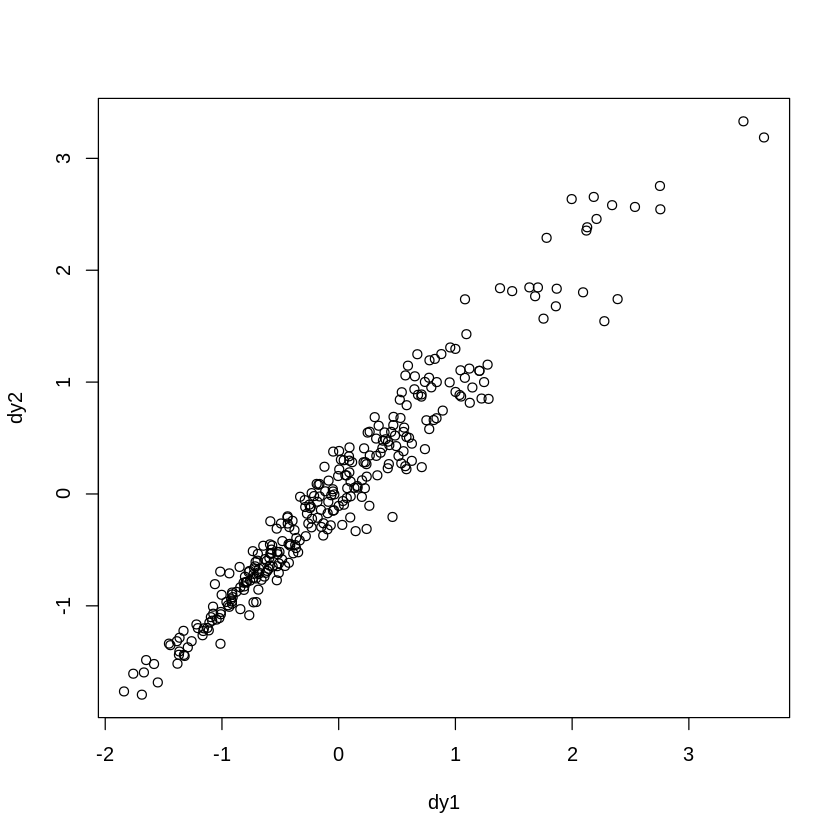

In [69]:
dy1 <- apply( post$d[,,1] , 2 , mean )
dy2 <- apply( post$d[,,2] , 2 , mean )
plot( dy1 , dy2 )

In [2]:
# load the distance matrix
library(rethinking)
data(islandsDistMatrix)

# display (measured in thousands of km)
Dmat <- islandsDistMatrix
colnames(Dmat) <- c("Ml","Ti","SC","Ya","Fi","Tr","Ch","Mn","To","Ha")
round(Dmat,1)

Ml  Ti  SC  Ya  Fi  Tr  Ch  Mn  To  Ha 
Malekula   0.0 0.5 0.6 4.4 1.2 2.0 3.2 2.8 1.9 5.7
Tikopia    0.5 0.0 0.3 4.2 1.2 2.0 2.9 2.7 2.0 5.3
Santa Cruz 0.6 0.3 0.0 3.9 1.6 1.7 2.6 2.4 2.3 5.4
Yap        4.4 4.2 3.9 0.0 5.4 2.5 1.6 1.6 6.1 7.2
Lau Fiji   1.2 1.2 1.6 5.4 0.0 3.2 4.0 3.9 0.8 4.9
Trobriand  2.0 2.0 1.7 2.5 3.2 0.0 1.8 0.8 3.9 6.7
Chuuk      3.2 2.9 2.6 1.6 4.0 1.8 0.0 1.2 4.8 5.8
Manus      2.8 2.7 2.4 1.6 3.9 0.8 1.2 0.0 4.6 6.7
Tonga      1.9 2.0 2.3 6.1 0.8 3.9 4.8 4.6 0.0 5.0
Hawaii     5.7 5.3 5.4 7.2 4.9 6.7 5.8 6.7 5.0 0.0

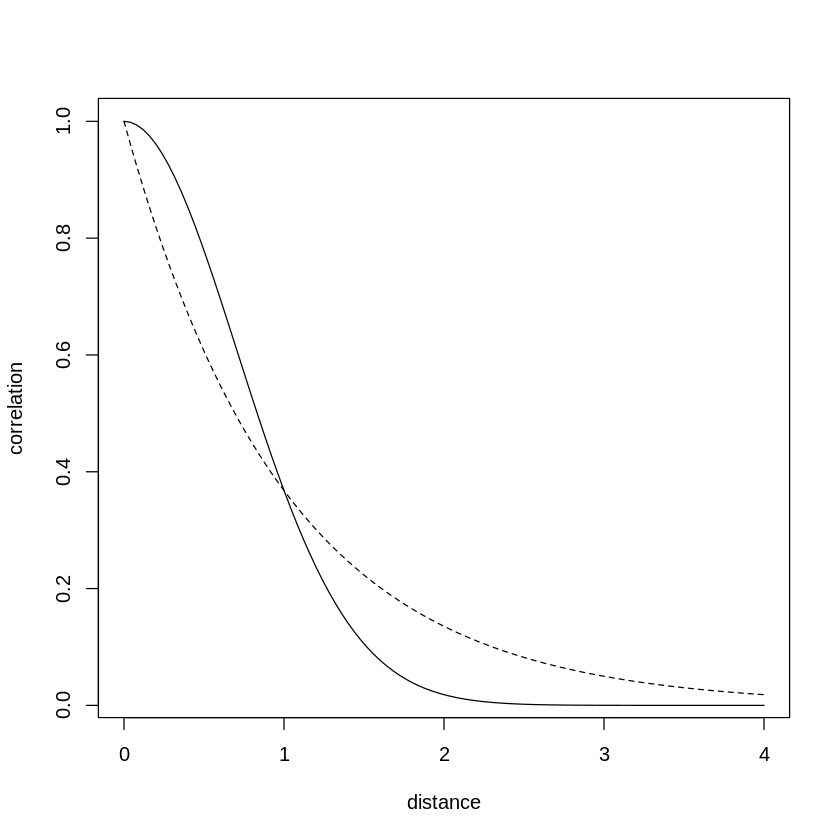

In [3]:
# linear
curve( exp(-1*x) , from=0 , to=4 , lty=2 ,
xlab="distance" , ylab="correlation" )

# squared
curve( exp(-1*x^2) , add=TRUE )

In [113]:
data(Kline2) # load the ordinary data, now with coordinates
d <- Kline2
d$society <- 1:10 # index observations

dat_list <- list(
                T = d$total_tools,
                P = d$population,
                society = d$society,
                Dmat=islandsDistMatrix )

m14.7 <- ulam(
            alist(
                T ~ dpois(lambda),
                lambda <- (a*P^b/g)*exp(k[society]),
                vector[10]:k ~ multi_normal( 0 , SIGMA ),
                matrix[10,10]:SIGMA <- cov_GPL2( Dmat , etasq , rhosq , 0.01 ),
                c(a,b,g) ~ dexp( 1 ),
                etasq ~ dexp( 2 ),
                rhosq ~ dexp( 0.5 )
            ), data=dat_list , chains=4 , cores=4 , iter=2000
        , log_lik=TRUE
        )

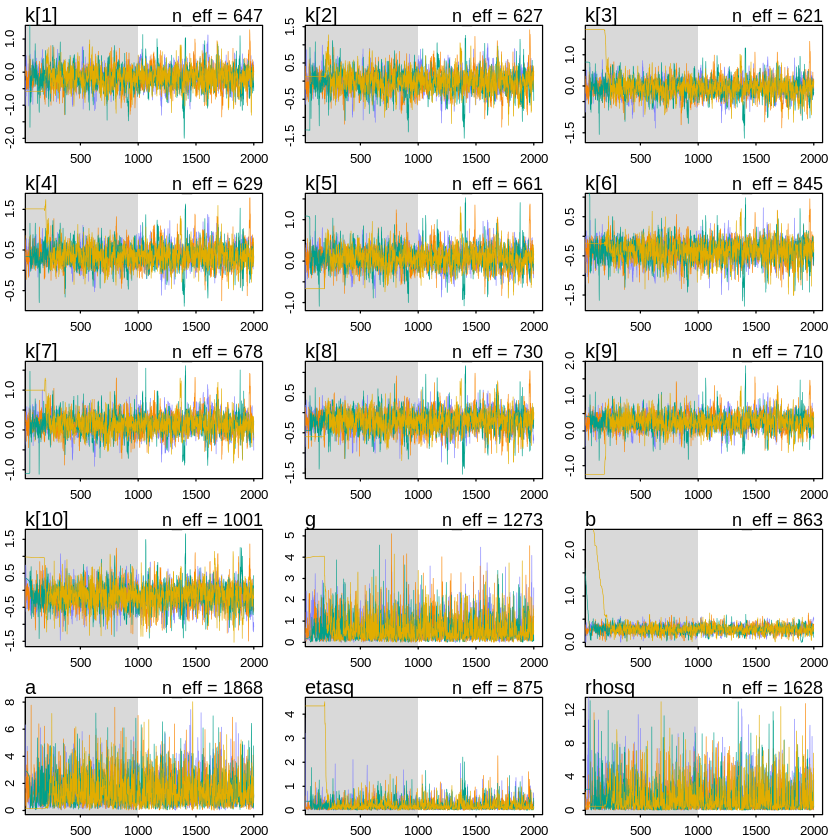

In [5]:
traceplot(m14.7)

In [6]:
precis( m14.7 , depth=3 )

mean         sd         5.5%        94.5%      n_eff     Rhat    
k[1]  -0.155999701 0.33377811 -0.67163999 0.36203381  646.6378 1.002645
k[2]  -0.007898628 0.32041470 -0.49968495 0.49590355  626.5322 1.002205
k[3]  -0.059957525 0.30954232 -0.54336289 0.42268008  621.2247 1.003656
k[4]   0.358971062 0.28632156 -0.05158821 0.82543612  629.4986 1.001753
k[5]   0.084627282 0.27994921 -0.32954571 0.51708487  660.5602 1.002380
k[6]  -0.381213888 0.28950189 -0.84055727 0.03008291  844.8633 1.000151
k[7]   0.151172051 0.27581246 -0.25807613 0.57092363  677.6572 1.002013
k[8]  -0.205828407 0.27984773 -0.64064394 0.20857258  729.9488 1.001042
k[9]   0.269608408 0.26216988 -0.12334889 0.66134095  709.7790 1.002505
k[10] -0.165059565 0.35771734 -0.74850178 0.34922334 1001.2071 0.999411
g      0.604171307 0.55797541  0.07116275 1.66671557 1273.3523 1.001159
b      0.279382034 0.08825405  0.14228505 0.42328320  862.5669 1.000451
a      1.388335228 1.07187596  0.22426030 3.40935873 1868.2332 1.000246
etasq  0.203755609 0.21136191  0.03038481 0.58499311  874.7763 1.004266
rhosq  1.316141361 1.65208342  0.07491183 4.65879212 1628.2270 1.001191

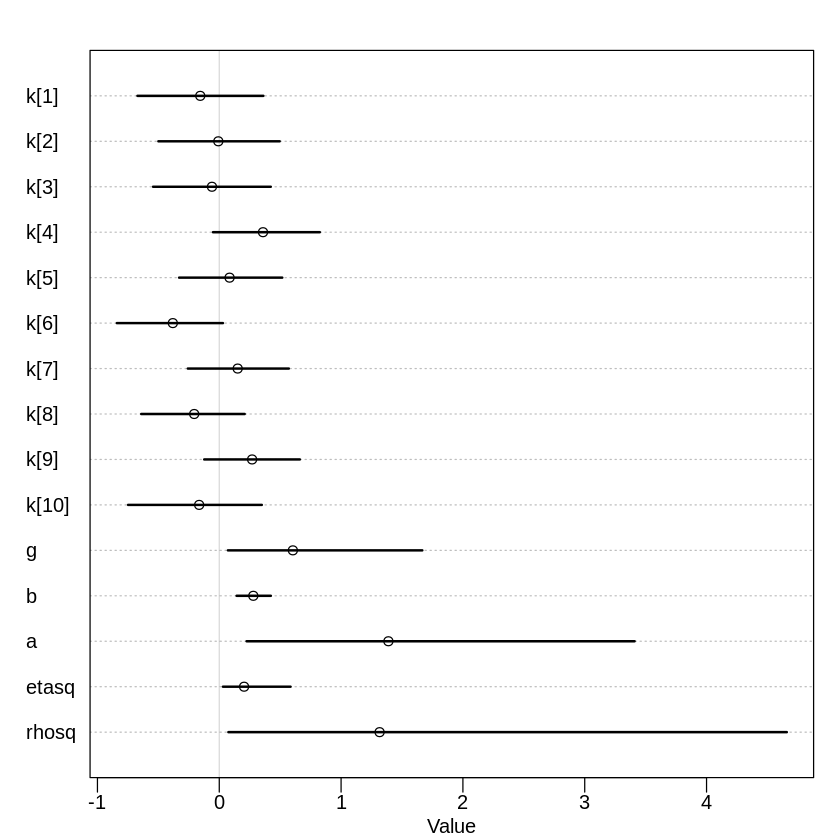

In [11]:
plot(precis( m14.7 , depth=3 ))


SAMPLING FOR MODEL '6767d02a6b5124281400f3c09c447bbf' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.41474 seconds (Warm-up)
Chain 1:                0.482546 seconds (Sampling)
C

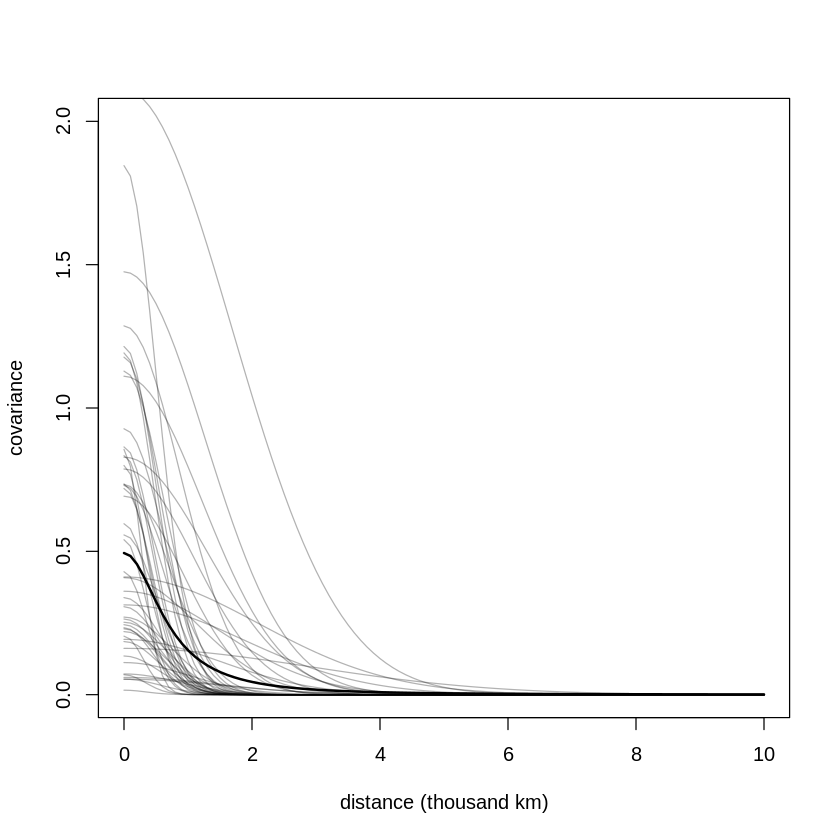

In [25]:
prior <- extract.prior(m14.7)

# plot the posterior median covariance function
plot( NULL , xlab="distance (thousand km)" , ylab="covariance" ,
xlim=c(0,10) , ylim=c(0,2) )

# compute posterior mean covariance
x_seq <- seq( from=0 , to=10 , length.out=100 )
pmcov <- sapply( x_seq , function(x) prior$etasq*exp(-prior$rhosq*x^2) )
pmcov_mu <- apply( pmcov , 2 , mean )
lines( x_seq , pmcov_mu , lwd=2 )

                # plot 60 functions sampled from posterior
for ( i in 1:50 )
curve( prior$etasq[i]*exp(-prior$rhosq[i]*x^2) , add=TRUE ,
col=col.alpha("black",0.3) )

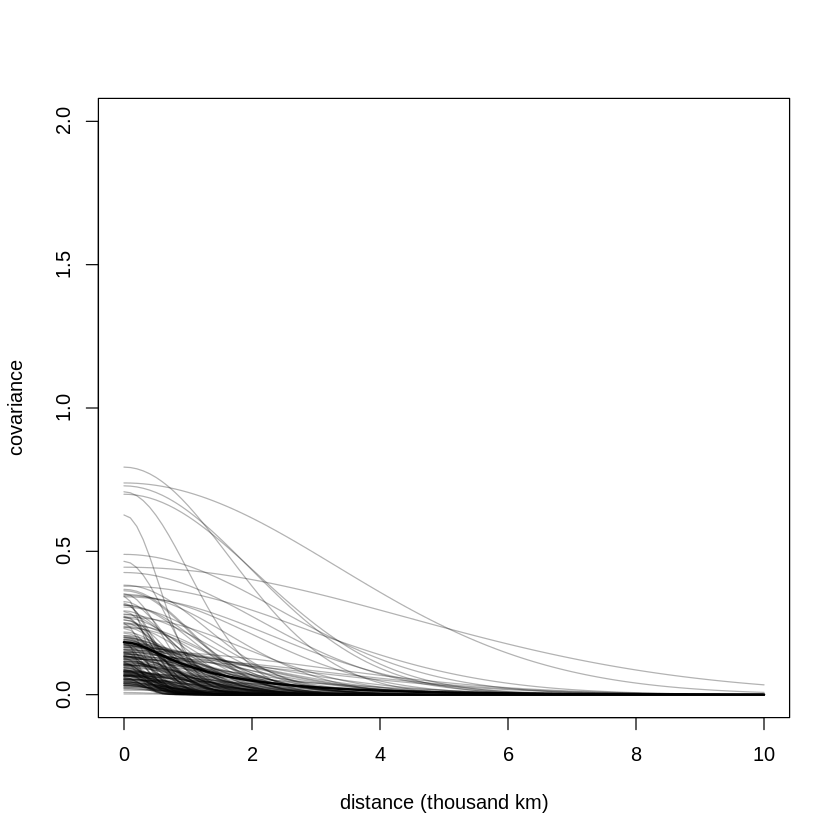

In [5]:
post <- extract.samples(m14.7)

# plot the posterior median covariance function
plot( NULL , xlab="distance (thousand km)" , ylab="covariance" ,
xlim=c(0,10) , ylim=c(0,2) )

# compute posterior mean covariance
x_seq <- seq( from=0 , to=10 , length.out=100 )
pmcov <- sapply( x_seq , function(x) post$etasq*exp(-post$rhosq*x^2) )
pmcov_mu <- apply( pmcov , 2 , mean )
lines( x_seq , pmcov_mu , lwd=2 )

# plot 60 functions sampled from posterior
for ( i in 1:200 )
curve( post$etasq[i]*exp(-post$rhosq[i]*x^2) , add=TRUE ,
col=col.alpha("black",0.3) )

In [6]:
# compute posterior median covariance among societies
K <- matrix(0,nrow=10,ncol=10)
for ( i in 1:10 )
for ( j in 1:10 )
K[i,j] <- median(post$etasq) * exp( -median(post$rhosq) * islandsDistMatrix[i,j]^2 )
diag(K) <- median(post$etasq) + 0.01

In [9]:
# convert to correlation matrix
Rho <- round( cov2cor(K) , 2 )
# add row/col names for convenience
colnames(Rho) <- c("Ml","Ti","SC","Ya","Fi","Tr","Ch","Mn","To","Ha")
rownames(Rho) <- colnames(Rho)
Rho

Ml   Ti   SC   Ya   Fi   Tr   Ch   Mn   To   Ha
Ml 1.00 0.78 0.68 0.00 0.28 0.03 0.00 0.00 0.06 0 
Ti 0.78 1.00 0.86 0.00 0.28 0.04 0.00 0.00 0.04 0 
SC 0.68 0.86 1.00 0.00 0.14 0.09 0.00 0.01 0.01 0 
Ya 0.00 0.00 0.00 1.00 0.00 0.01 0.14 0.12 0.00 0 
Fi 0.28 0.28 0.14 0.00 1.00 0.00 0.00 0.00 0.58 0 
Tr 0.03 0.04 0.09 0.01 0.00 1.00 0.07 0.52 0.00 0 
Ch 0.00 0.00 0.00 0.14 0.00 0.07 1.00 0.29 0.00 0 
Mn 0.00 0.00 0.01 0.12 0.00 0.52 0.29 1.00 0.00 0 
To 0.06 0.04 0.01 0.00 0.58 0.00 0.00 0.00 1.00 0 
Ha 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1

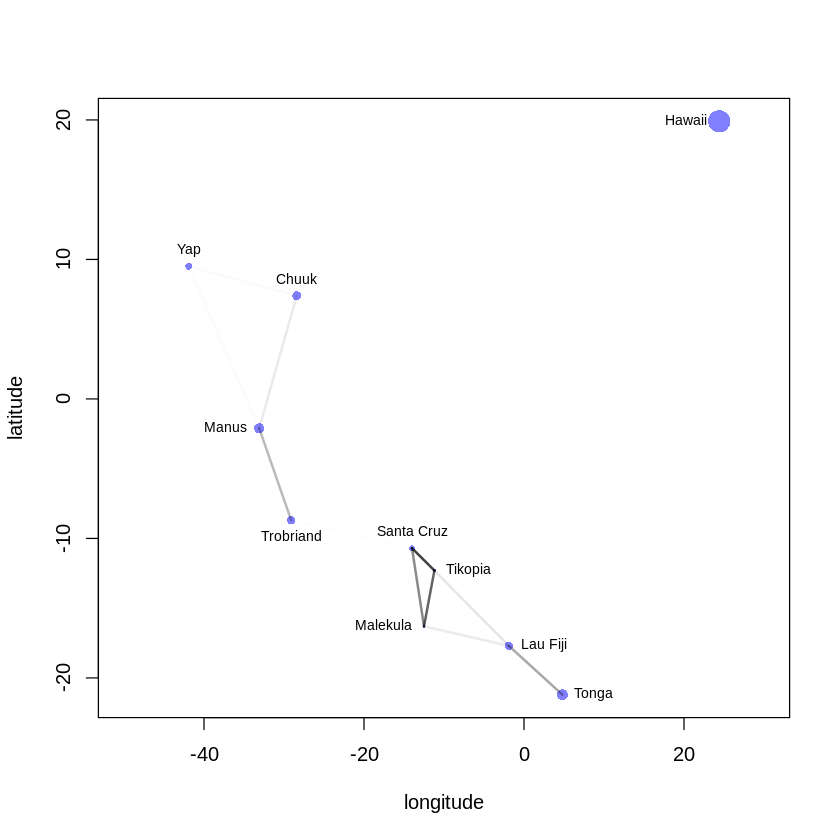

In [15]:
# scale point size to logpop
psize <- d$logpop / max(d$logpop)
psize <- exp(psize*1.5)-2

# plot raw data and labels
plot( d$lon2 , d$lat , xlab="longitude" , ylab="latitude" ,
col=rangi2 , cex=psize , pch=16 , xlim=c(-50,30) )
labels <- as.character(d$culture)
text( d$lon2 , d$lat , labels=labels , cex=0.7 , pos=c(2,4,3,3,4,1,3,2,4,2) )

# overlay lines shaded by Rho
for( i in 1:10 )
    for ( j in 1:10 )
        if ( i < j )
            lines( c( d$lon2[i],d$lon2[j] ) , c( d$lat[i],d$lat[j] ) , lwd=2 , col=col.alpha("black",Rho[i,j]^2) )

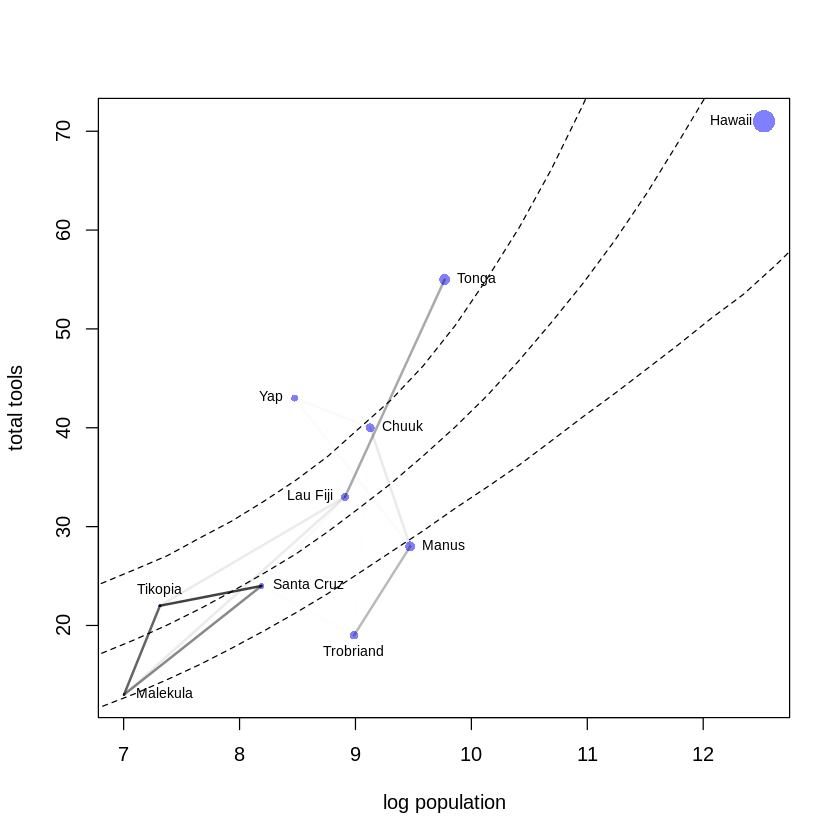

In [96]:
# compute posterior median relationship, ignoring distance
logpop.seq <- seq( from=6 , to=14 , length.out=30 )

#The link function is below - note that this is different from the draft book (as of 26th Sept 2019 update),
# which I think uses an old version of the link function - the 'geocentric model' rather than the 
# 'scientific model': lambda = (a*P^b/g)*exp(k[society]),

lambda <- sapply( logpop.seq , function(lp) ( post$a / post$g ) * exp( post$b*lp ) )
lambda.median <- apply( lambda , 2 , median )
lambda.PI80 <- apply( lambda , 2 , PI , prob=0.8 )
                 
# plot raw data and labels
plot( d$logpop , d$total_tools , col=rangi2 , cex=psize , pch=16 , xlab="log population" , ylab="total tools" )
text( d$logpop , d$total_tools , labels=labels , cex=0.7 , pos=c(4,3,4,2,2,1,4,4,4,2) )

# display posterior predictions
lines( logpop.seq , lambda.median , lty=2 )
lines( logpop.seq , lambda.PI80[1,] , lty=2 )
lines( logpop.seq , lambda.PI80[2,] , lty=2 )

# overlay correlations
for( i in 1:10 )
    for ( j in 1:10 )
        if ( i < j )
            lines( c( d$logpop[i],d$logpop[j] ) ,  c( d$total_tools[i],d$total_tools[j] ) ,
                lwd=2 , col=col.alpha("black",Rho[i,j]^2) )

In [112]:
# m14.7 <- ulam(
#               alist(
#                   T ~ dpois(lambda),
#                   lambda <- (a*P^b/g)*exp(k[society]),
#                   vector[10]:k ~ multi_normal( 0 , SIGMA ),
#                   matrix[10,10]:SIGMA <- cov_GPL2( Dmat , etasq , rhosq , 0.01 ),
#                   c(a,b,g) ~ dexp( 1 ),
#                   etasq ~ dexp( 2 ),
#                   rhosq ~ dexp( 0.5 )
#               ), data=dat_list , chains=4 , cores=4 , iter=2000 )

m14.7nc <- ulam(
                alist(
                    T ~ dpois(lambda),
                    lambda <- (a*P^b/g)*exp(k[society]),

                    # non-centered Gaussian Process prior
                    transpars> vector[10]: k <<- L_SIGMA * z,
                    vector[10]: z ~ normal( 0 , 1 ),
                    transpars> matrix[10,10]: L_SIGMA <<- cholesky_decompose( SIGMA ),
                    transpars> matrix[10,10]: SIGMA <- cov_GPL2( Dmat , etasq , rhosq , 0.01 ),
                    c(a,b,g) ~ dexp( 1 ),
                    etasq ~ dexp( 2 ),
                    rhosq ~ dexp( 0.5 )
                    ), data=dat_list , chains=4 , cores=4 , iter=2000 
                , log_lik=TRUE
                )

In [103]:
precis(m14.7nc, depth=2)

200 matrix parameters hidden. Use depth=3 to show them.


mean        sd         5.5%        94.5%        n_eff    Rhat     
z[1]  -0.45494945 0.76638410 -1.71643622  0.750156851 1768.920 0.9998966
z[2]   0.42027188 0.78004207 -0.82889616  1.652889914 3126.740 1.0004805
z[3]  -0.23507044 0.78622264 -1.54299540  1.031218574 3298.187 1.0000253
z[4]   0.98048844 0.61427517  0.03130887  1.965954932 1869.031 1.0004936
z[5]   0.37500799 0.64568048 -0.63824939  1.407308820 2028.219 1.0004818
z[6]  -1.07454758 0.65450011 -2.15830120 -0.070638999 2754.537 1.0009510
z[7]   0.36700703 0.58036482 -0.55338703  1.278436051 2303.381 1.0009192
z[8]  -0.38315305 0.69038401 -1.52015187  0.718862782 3247.467 1.0004501
z[9]   0.78424631 0.64846821 -0.24215263  1.817189226 2710.359 0.9999201
z[10] -0.43832754 0.81498104 -1.76856696  0.832320702 2017.195 1.0018578
g      0.60896107 0.58210937  0.07134856  1.700965617 2046.999 1.0009611
b      0.27841844 0.08690613  0.14045753  0.415947150 1130.780 1.0009930
a      1.36966586 1.01650991  0.24212772  3.190414109 3432.410 1.0002037
etasq  0.18876216 0.18523575  0.02947068  0.519589010 1500.026 1.0036902
rhosq  1.35598913 1.66809311  0.08274856  4.471973747 2409.981 1.0007434
k[1]  -0.16452661 0.31279567 -0.65827423  0.330381329 1654.047 1.0004474
k[2]  -0.01127811 0.30371033 -0.47696405  0.458585587 1656.638 1.0004108
k[3]  -0.06409456 0.28704742 -0.50357287  0.362738699 1939.140 1.0001642
k[4]   0.35888213 0.26080355 -0.01074938  0.767819255 1822.479 0.9994862
k[5]   0.08510353 0.25707683 -0.30135094  0.485266214 2221.845 1.0006554
k[6]  -0.38062955 0.27398453 -0.81762858  0.006136304 2132.573 1.0013312
k[7]   0.14994055 0.25718370 -0.23886615  0.547975073 2201.413 1.0005823
k[8]  -0.20649642 0.26248176 -0.62395936  0.175956359 2301.614 1.0000485
k[9]   0.26876842 0.24716540 -0.11405061  0.646519198 2196.349 1.0014920
k[10] -0.16174547 0.34398368 -0.73639199  0.354217963 1444.834 1.0014724

200 matrix parameters hidden. Use depth=3 to show them.


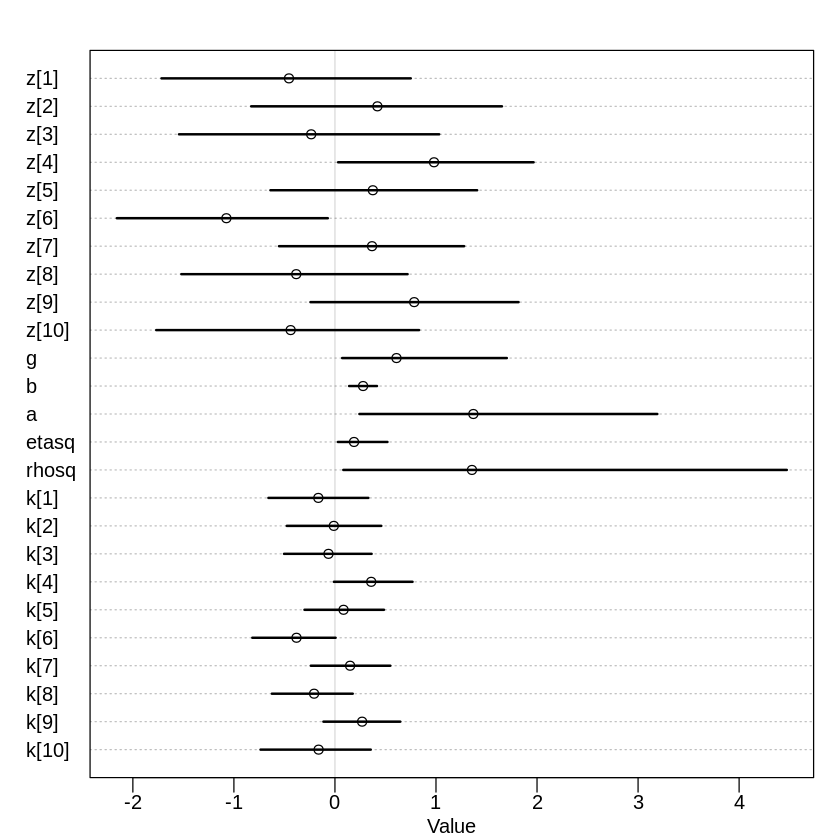

In [110]:
plot(precis(m14.7nc, depth=2))

In [114]:
compare(m14.7, m14.7nc)

WAIC     pWAIC    dWAIC     weight  SE       dSE      
m14.7nc 67.96033 4.241153 0.0000000 0.52835 2.382704        NA
m14.7   68.18737 4.313044 0.2270436 0.47165 2.384794 0.2509039

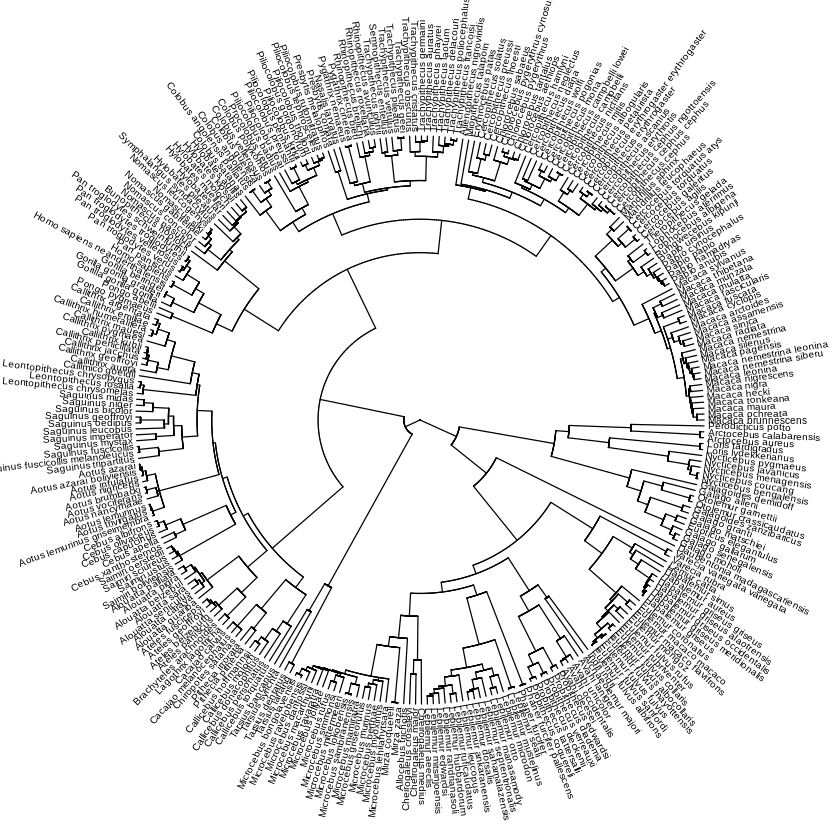

In [115]:
library(rethinking)
data(Primates301)
data(Primates301_nex)

# plot it
library(ape)
plot( ladderize(Primates301_nex) , type="fan" , font=1 , no.margin=TRUE , label.offset=1 , cex=0.5 )

In [127]:
d <- Primates301
d$name <- as.character(d$name)
dstan <- d[ complete.cases( d$group_size , d$body , d$brain ) , ]
spp_obs <- dstan$name
head(dstan)

name                        genus          species      subspecies spp_id
1 Allenopithecus_nigroviridis Allenopithecus nigroviridis NA         1     
3 Alouatta_belzebul           Alouatta       belzebul     NA         3     
4 Alouatta_caraya             Alouatta       caraya       NA         4     
5 Alouatta_guariba            Alouatta       guariba      NA         5     
6 Alouatta_palliata           Alouatta       palliata     NA         6     
7 Alouatta_pigra              Alouatta       pigra        NA         7     
  genus_id social_learning research_effort brain body group_size gestation
1 1        0                6              58.02 4655 40.0           NA   
3 3        0               15              52.84 6395  7.4           NA   
4 3        0               45              52.63 5383  8.9       185.92   
5 3        0               37              51.70 5175  7.4           NA   
6 3        3               79              49.88 6250 13.1       185.42   
7 3        0               25              51.13 8915  5.5       185.92   
  weaning longevity sex_maturity maternal_investment
1 106.15  276.0          NA          NA             
3     NA     NA          NA          NA             
4 323.16  243.6     1276.72      509.08             
5     NA     NA          NA          NA             
6 495.60  300.0     1578.42      681.02             
7     NA  240.0          NA          NA

In [129]:
dat_list <- list(
                    N_spp = nrow(dstan),
                    M = standardize(log(dstan$body)),
                    B = standardize(log(dstan$brain)),
                    G = standardize(log(dstan$group_size)),
                    Imat = diag( nrow(dstan) )
                )

In [130]:
m14.8 <- ulam(
            alist(
                G ~ multi_normal( mu , SIGMA ),
                mu <- a + bM*M + bB*B,
                matrix[N_spp,N_spp]: SIGMA <- Imat * sigma_sq,
                a ~ normal( 0 , 1 ),
                c(bM,bB) ~ normal( 0 , 0.5 ),
                sigma_sq ~ exponential( 1 )
            ), data=dat_list , chains=4 , cores=4 )

precis( m14.8 )

Cautionary note:
Variable Imat contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.


mean          sd         5.5%        94.5%      n_eff     Rhat    
a         0.0009870958 0.05804035 -0.09130158 0.09554843 1310.0133 1.001136
bB        1.0030667735 0.20881101  0.66327331 1.33258355  871.7662 1.004182
bM       -0.3365554059 0.20922209 -0.65962420 0.00207320  849.1898 1.004524
sigma_sq  0.5193759734 0.06269780  0.42726470 0.62581467 1167.6349 1.000908

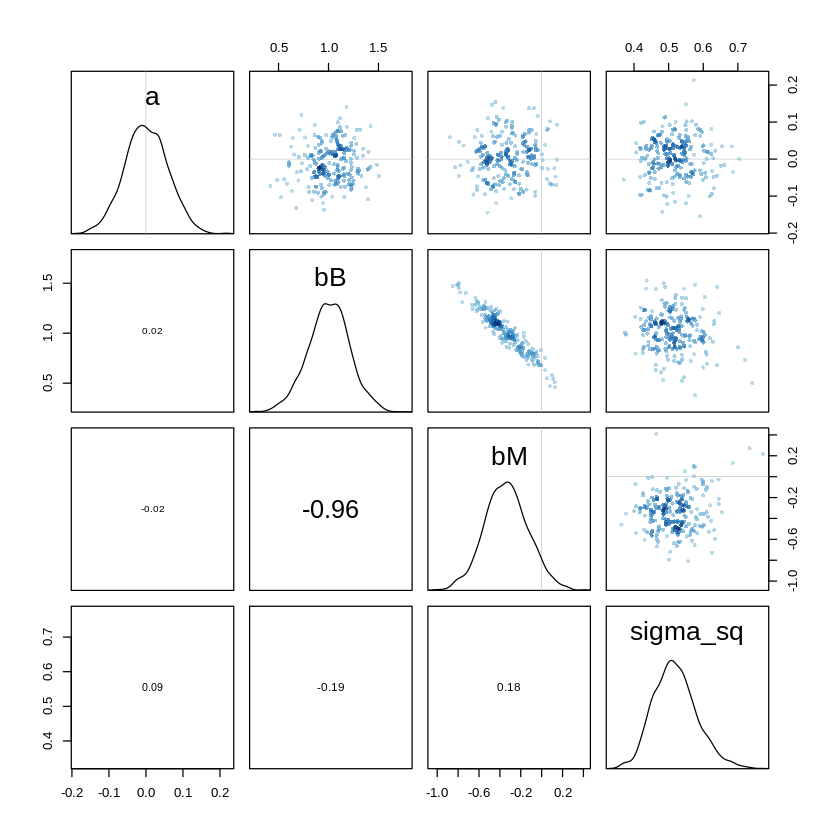

In [132]:
pairs(m14.8)

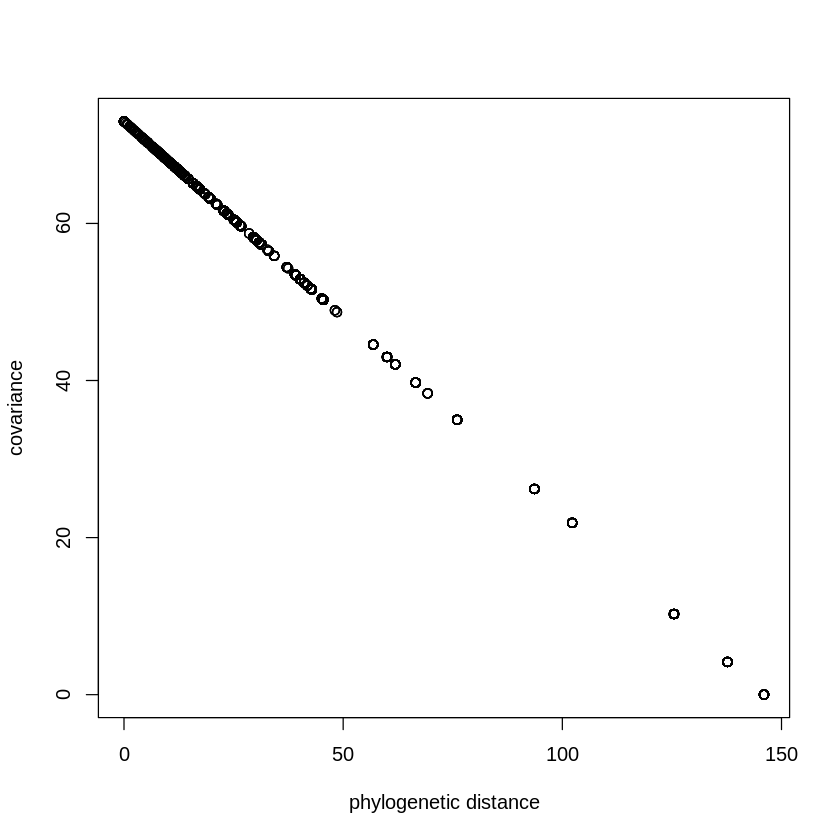

In [133]:
tree_trimmed <- keep.tip( Primates301_nex, spp_obs )
Rbm <- corBrownian( phy=tree_trimmed )
V <- vcv(Rbm)
Dmat <- cophenetic( tree_trimmed )
plot( Dmat , V , xlab="phylogenetic distance" , ylab="covariance" )

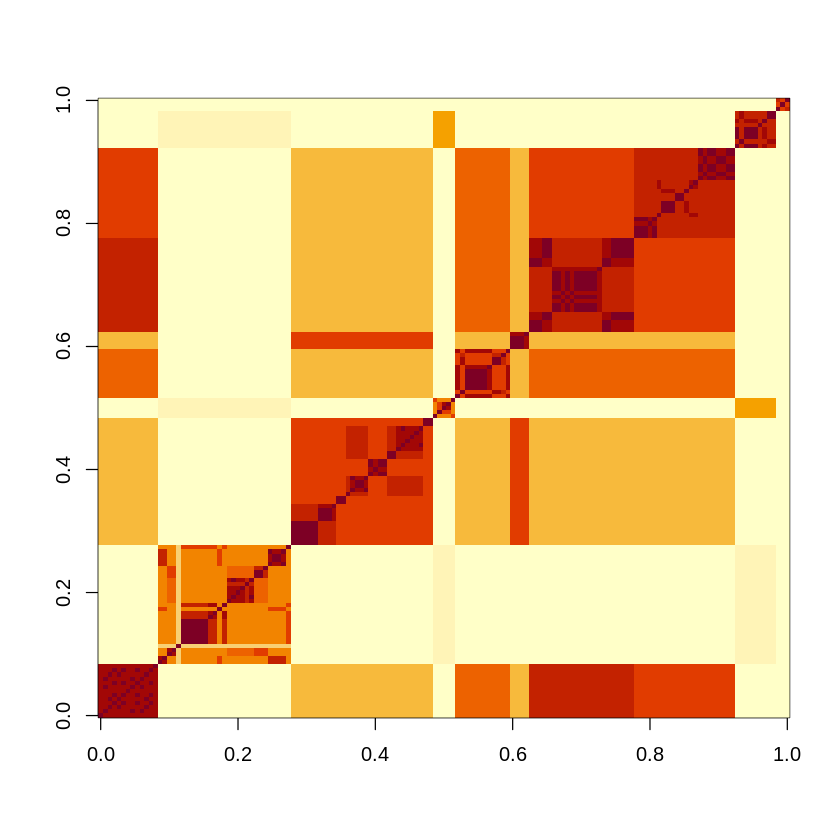

In [146]:
image(V)

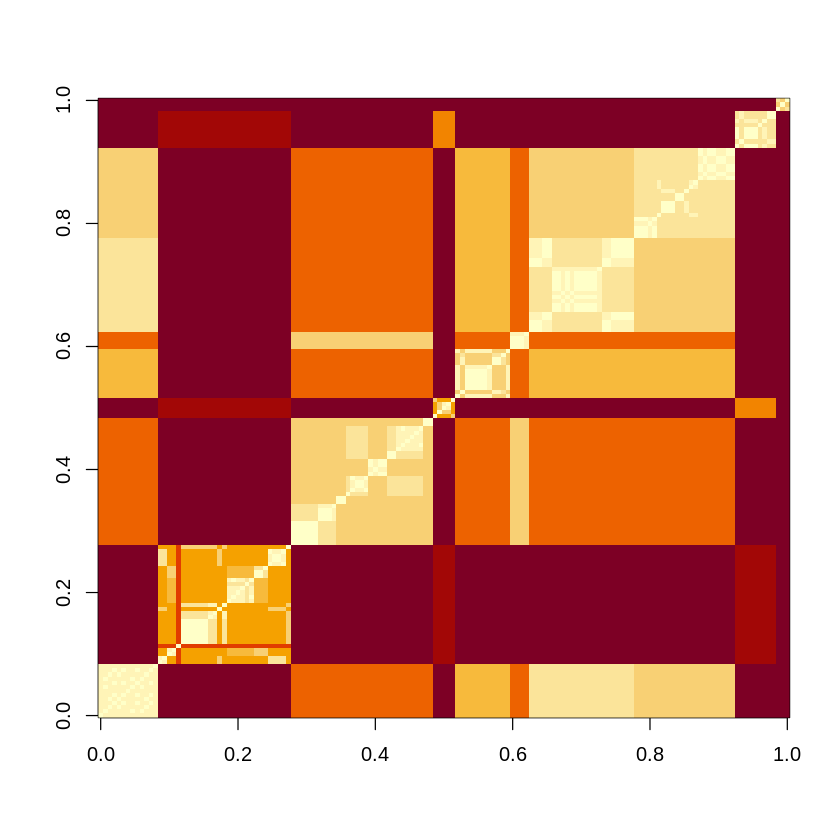

In [147]:
image(Dmat)

In [148]:
# put species in right order
dat_list$V <- V[ spp_obs , spp_obs ]

# convert to correlation matrix
dat_list$R <- dat_list$V / max(V)

# Brownian motion model
m14.9 <- ulam(
            alist(
                G ~ multi_normal( mu , SIGMA ),
                mu <- a + bM*M + bB*B,
                matrix[N_spp,N_spp]: SIGMA <- R * sigma_sq,
                a ~ normal( 0 , 1 ),
                c(bM,bB) ~ normal( 0 , 0.5 ),
                sigma_sq ~ exponential( 1 )
            ), data=dat_list , chains=4 , cores=4 )

precis( m14.9 )

Cautionary note:
Variable Imat contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.


mean        sd        5.5%       94.5%     n_eff     Rhat     
a        -0.43590362 0.5852306 -1.3591176 0.5163384 1869.3013 1.0007836
bB       -0.07742485 0.2655925 -0.4848719 0.3467060  949.6063 1.0045239
bM        0.34868930 0.2227619 -0.0169212 0.6889339  949.1692 1.0035869
sigma_sq  2.70615490 0.3091713  2.2483281 3.2181158 1556.2324 0.9996656

In [149]:
# add scaled and reordered distance matrix
dat_list$Dmat <- Dmat[ spp_obs , spp_obs ] / max(Dmat)

m14.10 <- ulam(
                alist(
                    G ~ multi_normal( mu , SIGMA ),
                    mu <- a + bM*M + bB*B,
                    matrix[N_spp,N_spp]: SIGMA <- cov_GPL2( Dmat , etasq , rhosq , 0.01 ),
                    a ~ normal(0,1),
                    c(bM,bB) ~ normal(0,0.5),
                    etasq ~ exponential(1),
                    rhosq ~ exponential(1)
                ), data=dat_list , chains=4 , cores=4 )

precis( m14.10 )

Cautionary note:
Variable Imat contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.


mean       sd        5.5%       94.5%      n_eff    Rhat    
a     -0.5097801 0.3914457 -1.1266155  0.1210497 1427.625 1.001108
bB    -0.1654381 0.2525820 -0.5787113  0.2275865 1182.323 1.002258
bM     0.5481145 0.2009548  0.2254176  0.8807489 1115.039 1.002837
etasq  2.7300540 0.8152702  1.7170258  4.2491390 1017.905 1.001557
rhosq 11.8358871 3.3924792  6.9572185 17.5239959 1039.619 1.000032

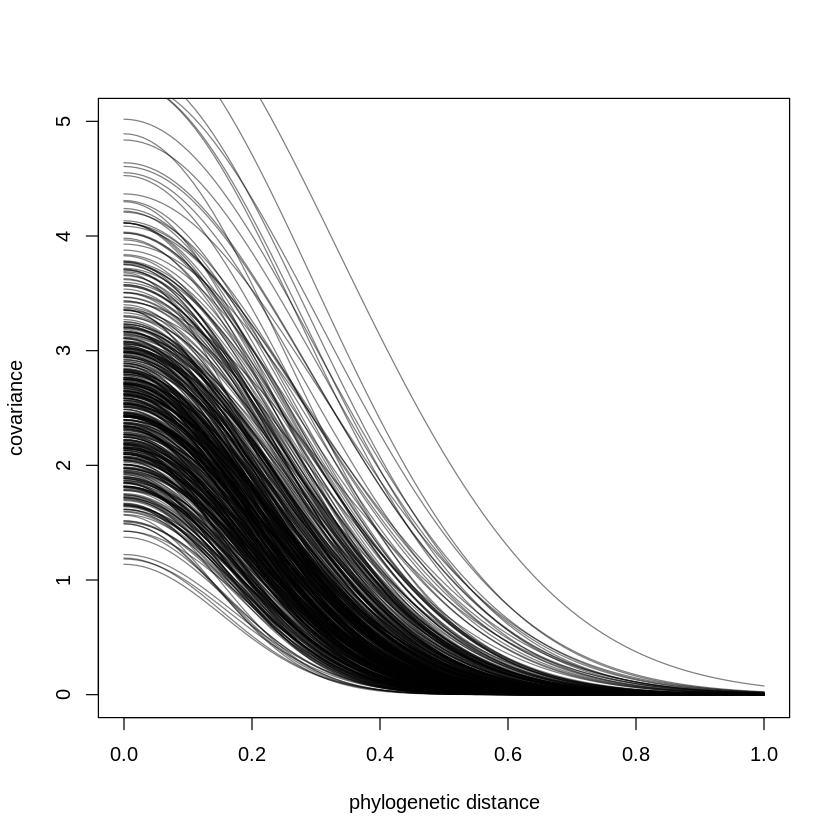

In [153]:
post <- extract.samples(m14.10)
plot( NULL , xlim=c(0,max(dat_list$Dmat)) , ylim=c(0,5) ,
xlab="phylogenetic distance" , ylab="covariance" )
for ( i in 1:500 ) curve( post$etasq[i]*exp(-post$rhosq[i]*x^2) , add=TRUE , col=grau() )

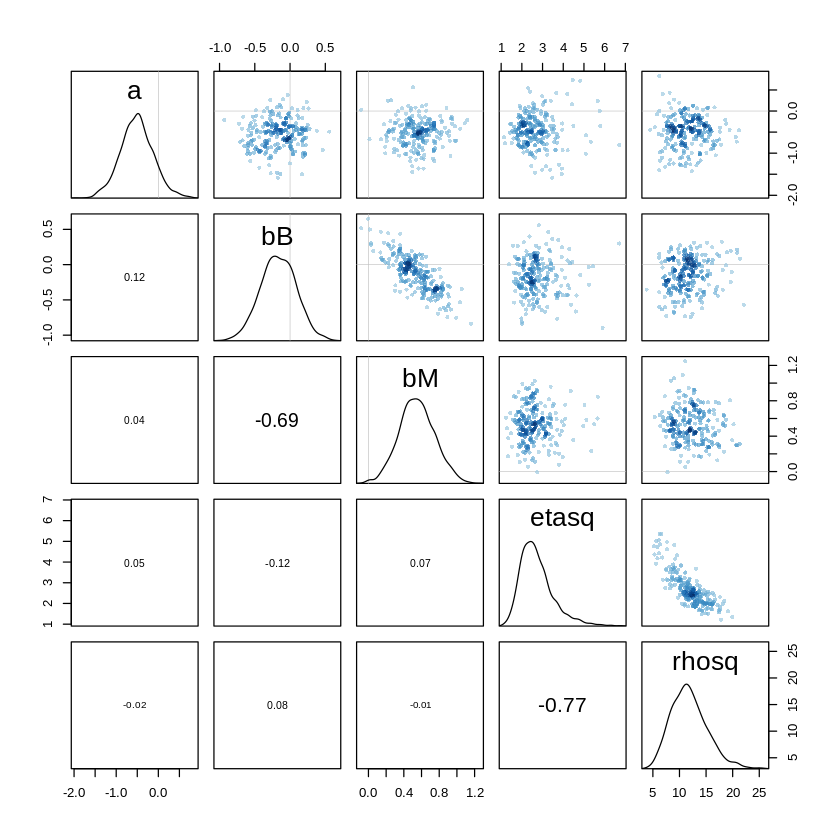

In [152]:
pairs(m14.10)

In [188]:
d[which(d$name=='Homo_sapiens'),]

name         genus species subspecies spp_id genus_id social_learning
130 Homo_sapiens Homo  sapiens NA         130    30       NA             
    research_effort brain body     group_size gestation weaning longevity
130 NA              NA    58540.63 NA         274.78    725.86  1470     
    sex_maturity maternal_investment
130 5582.93      1000.64

PRACTICE

13E1

13E2

From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch13_hw.R:

"
case 1)
Consider a hypothetical example of the average gas mileage of the ride. It depends on the car model (as a proxy of engine's volume) and the speed you travel. 
The faster you ride, the more gas you need. Also, car with larger engine volume uses more gas and needs more gas to accelerate per each next mile/hour.
Thus intercept(avg gas mileage for the car) and slope(increase per each next mile/hour)  are positively correlated. 

gas_mileage ~ a[model] + b[model]*speed

case 2)
Another possible example is a dependency between pollution in the region(county) and distance to the industrial area.
 pollution ~ a[county] + b[county]*is_industrial_area
If a county has a lot of factories than average pollution is large. But also the closer you are to the actual factory, the bigger is pollution. 
So a[county] and b[county] are positively correlated. Still, I'm not sure that such dependency holds on practice.
"

13E3

<s>It's possible for varying slopes models to have fewer effective parameters than fixed slopes models whenever adapative regularization is strong, i.e. the priors on the population parameters are narrow.</s>

From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch13_hw.R:
"
I assume it could happen when slopes and intercepts are highly correlated across groups. The unpooled model treats correlation between slope and intercept independently for each group, while pooled relies on common distribution that can reduce the number of parameters.
From another point of view, effective number of parameters is by construction an average variance of the likelihood across all cases in the sample, so in the pooled model this variability reduces due to shrinkage to the mean of slopes estimations.
There is an illustration of this phenomena in the exercise 13M2 
"

13M1

In [253]:
a <- 3.5
b <- (-1)
sigma_a <- 1
sigma_b <- 0.5
rho <- 0 #(-0.7)

Mu <- c( a , b )
# cov_ab <- sigma_a*sigma_b*rho
# Sigma <- matrix( c(sigma_a^2,cov_ab,cov_ab,sigma_b^2) , ncol=2 )
sigmas <- c(sigma_a,sigma_b) # standard deviations
Rho <- matrix( c(1,rho,rho,1) , nrow=2 ) # correlation matrix
# now matrix multiply to get covariance matrix
Sigma <- diag(sigmas) %*% Rho %*% diag(sigmas)

N_cafes <- 20

In [254]:
library(MASS)
set.seed(5) # used to replicate example
vary_effects <- mvrnorm( N_cafes , Mu , Sigma )

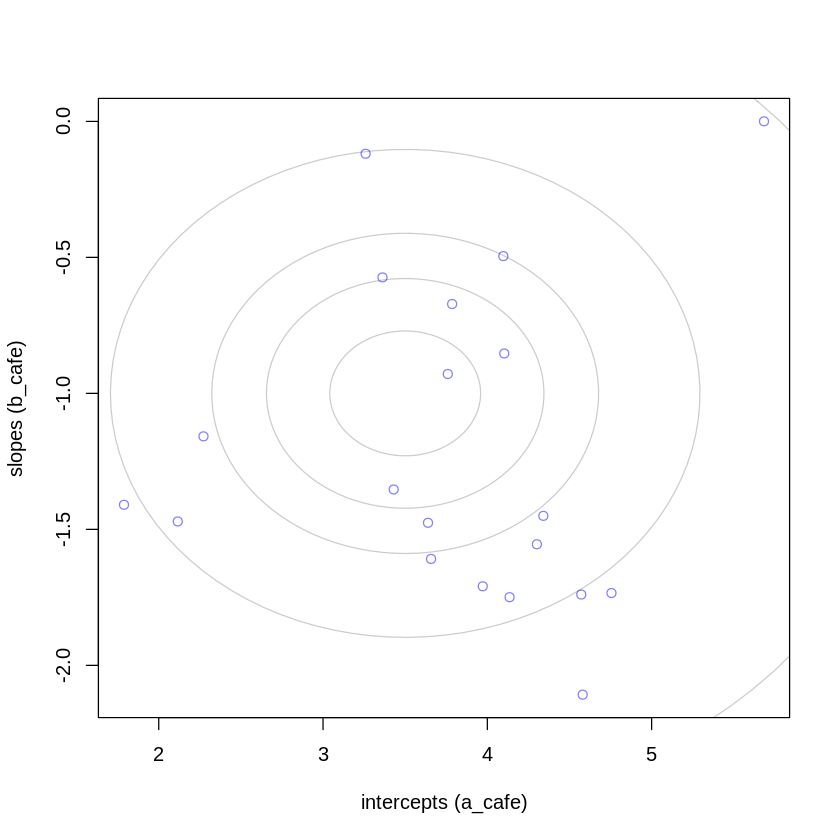

In [255]:
a_cafe <- vary_effects[,1]
b_cafe <- vary_effects[,2]

plot( a_cafe , b_cafe , col=rangi2 ,
xlab="intercepts (a_cafe)" , ylab="slopes (b_cafe)" )

# overlay population distribution
library(ellipse)
for ( l in c(0.1,0.3,0.5,0.8,0.99) )
lines(ellipse(Sigma,centre=Mu,level=l),col=col.alpha("black",0.2))

In [256]:
set.seed(22)
N_visits <- 10

afternoon <- rep(0:1,N_visits*N_cafes/2)
cafe_id <- rep( 1:N_cafes , each=N_visits )

mu <- a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma <- 0.5 # std dev within cafes
wait <- rnorm( N_visits*N_cafes , mu , sigma )
d <- data.frame( cafe=cafe_id , afternoon=afternoon , wait=wait )

In [257]:
m13M1 <- ulam(
            alist(
                wait ~ normal( mu , sigma ),
                mu <- a_cafe[cafe] + b_cafe[cafe]*afternoon,
                c(a_cafe,b_cafe)[cafe] ~ multi_normal( c(a,b) , Rho , sigma_cafe ),
                a ~ normal(5,2),
                b ~ normal(-1,0.5),
                sigma_cafe ~ exponential(1),
                sigma ~ exponential(1),
                Rho ~ lkj_corr(2)
            ) , data=d , chains=4 , cores=4 )

recompiling to avoid crashing R session


In [258]:
precis(m13M1, depth=3)

mean        sd           5.5%       94.5%      n_eff    
b_cafe[1]     -0.97750813 2.634405e-01 -1.4005054 -0.5431076 2651.2599
b_cafe[2]     -1.58009403 2.729548e-01 -2.0362206 -1.1456729 2374.5090
b_cafe[3]     -1.74856078 2.882406e-01 -2.2124789 -1.2848994 1988.9998
b_cafe[4]     -1.39170157 2.801782e-01 -1.8217657 -0.9316321 2551.8100
b_cafe[5]     -0.86151240 2.767015e-01 -1.3104247 -0.4209477 2237.5866
b_cafe[6]     -1.04526336 2.762093e-01 -1.4734087 -0.5993704 2733.6049
b_cafe[7]     -1.07355517 2.610668e-01 -1.4948961 -0.6659535 2404.4503
b_cafe[8]     -1.66025975 2.662477e-01 -2.1003497 -1.2421212 2264.0021
b_cafe[9]     -1.09971638 2.508537e-01 -1.4836825 -0.6949504 2724.1290
b_cafe[10]    -0.85504949 2.643238e-01 -1.2740554 -0.4262223 2651.4424
b_cafe[11]    -0.93603679 2.751991e-01 -1.3691749 -0.4892189 2012.0238
b_cafe[12]    -1.08847080 2.637836e-01 -1.5015374 -0.6718549 2272.4163
b_cafe[13]    -1.83252553 2.751377e-01 -2.2891364 -1.3910597 2043.2560
b_cafe[14]    -1.08894921 2.738161e-01 -1.5292724 -0.6484764 2517.5689
b_cafe[15]    -2.08573142 2.926717e-01 -2.5703316 -1.6181045 2013.8409
b_cafe[16]    -1.15153081 2.648655e-01 -1.5749093 -0.7232343 2545.2397
b_cafe[17]    -0.84401250 2.801507e-01 -1.2919447 -0.3935022 2472.5602
b_cafe[18]     0.13097144 2.783559e-01 -0.3165070  0.5683249 1920.4527
b_cafe[19]    -0.04256440 2.940387e-01 -0.5114892  0.4202833 1872.9158
b_cafe[20]    -0.94685318 2.656396e-01 -1.3775940 -0.5263218 2344.3052
a_cafe[1]      4.32694876 1.964731e-01  4.0118741  4.6462350 2620.3359
a_cafe[2]      2.23832772 2.022432e-01  1.9206131  2.5715162 2391.1175
a_cafe[3]      4.55813646 2.087280e-01  4.2269696  4.8914005 2180.3474
a_cafe[4]      3.31791231 2.079837e-01  2.9939353  3.6495643 2377.9519
a_cafe[5]      1.92469272 1.988734e-01  1.6107207  2.2556632 2604.8439
a_cafe[6]      4.25436300 2.030357e-01  3.9299410  4.5863257 2594.2727
a_cafe[7]      3.77846339 1.960465e-01  3.4565100  4.0927991 2160.8530
a_cafe[8]      4.11442877 1.953672e-01  3.8014852  4.4347913 2185.0730
a_cafe[9]      3.92084971 1.832772e-01  3.6294357  4.2064749 2403.3170
a_cafe[10]     3.46779079 1.980054e-01  3.1533777  3.7831191 2611.0744
a_cafe[11]     1.94899033 2.098718e-01  1.6041401  2.2842601 2190.8013
a_cafe[12]     3.98274859 1.929998e-01  3.6761243  4.2951239 2392.4650
a_cafe[13]     4.15113414 2.037742e-01  3.8303740  4.4873959 2200.2916
a_cafe[14]     3.31304458 1.987681e-01  3.0001030  3.6324128 2693.6725
a_cafe[15]     4.63138081 2.138806e-01  4.2845820  4.9814861 2264.0403
a_cafe[16]     3.49620382 2.015930e-01  3.1798491  3.8147362 2356.3507
a_cafe[17]     4.12079800 2.001780e-01  3.8001546  4.4255306 2674.9420
a_cafe[18]     5.58702202 1.933334e-01  5.2655244  5.8879194 2321.2392
a_cafe[19]     3.07061254 2.129302e-01  2.7271544  3.4003198 2222.3629
a_cafe[20]     3.72792484 1.967194e-01  3.4208002  4.0441549 2397.1291
a              3.71530548 2.243585e-01  3.3748862  4.0869252 2206.7956
b             -1.10218576 1.517193e-01 -1.3438950 -0.8639961 2246.3886
sigma_cafe[1]  0.98736516 1.774012e-01  0.7466907  1.2918331 2153.6984
sigma_cafe[2]  0.63864315 1.414107e-01  0.4466960  0.8810104 1787.4034
sigma          0.47301215 2.698900e-02  0.4323300  0.5191093 1680.1436
Rho[1,1]       1.00000000 0.000000e+00  1.0000000  1.0000000       NaN
Rho[1,2]      -0.05269847 2.315362e-01 -0.4227848  0.3245774 2140.7920
Rho[2,1]      -0.05269847 2.315362e-01 -0.4227848  0.3245774 2140.7920
Rho[2,2]       1.00000000 7.588873e-17  1.0000000  1.0000000  551.2835
              Rhat     
b_cafe[1]     0.9996089
b_cafe[2]     0.9998309
b_cafe[3]     0.9989253
b_cafe[4]     0.9995107
b_cafe[5]     0.9983017
b_cafe[6]     1.0004605
b_cafe[7]     1.0005175
b_cafe[8]     0.9985981
b_cafe[9]     1.0009440
b_cafe[10]    1.0005371
b_cafe[11]    0.9995516
b_cafe[12]    0.9990324
b_cafe[13]    0.9999187
b_cafe[14]    0.9987467
b_cafe[15]    0.9992693
b_cafe[16]    1.0002886
b_cafe[17]    0.9994577
b_cafe[18]    1.0023793
b_cafe[1

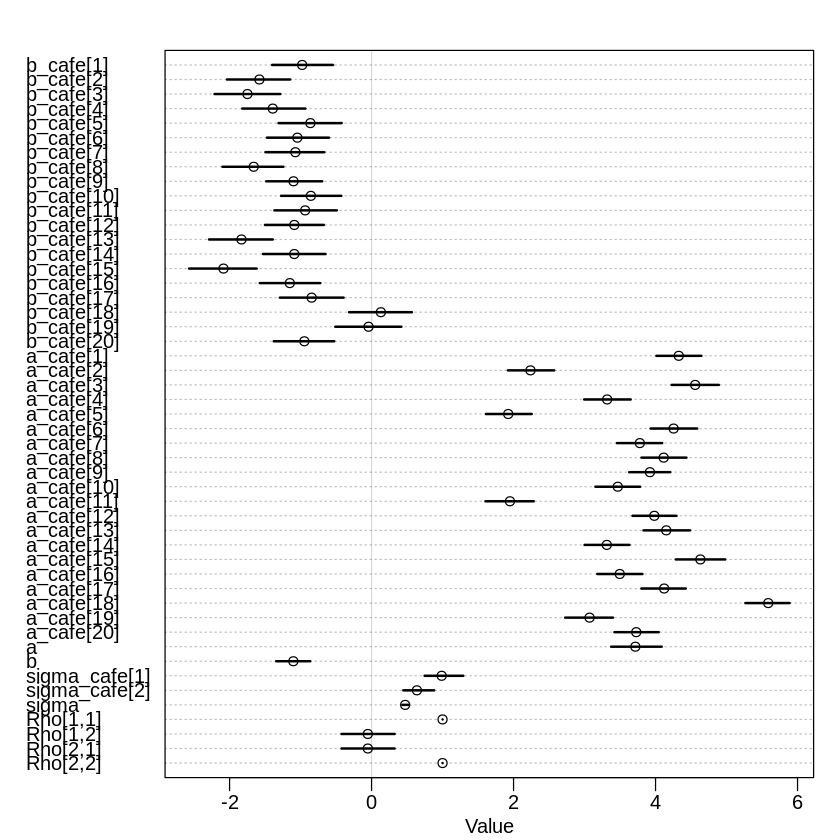

In [259]:
plot(precis(m13M1, depth=3))

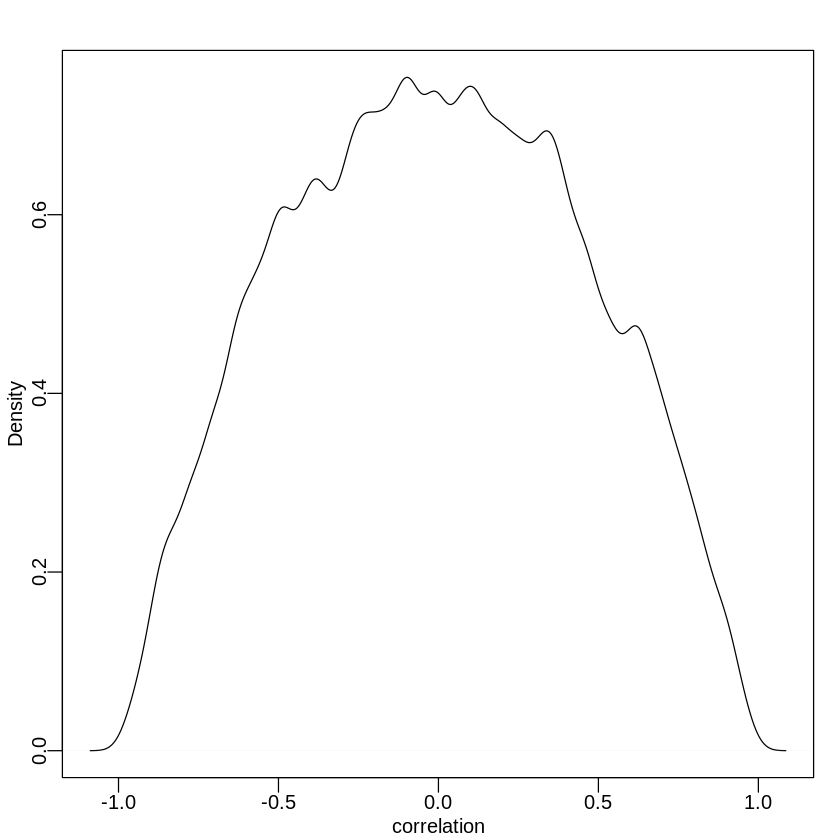

In [260]:
R <- rlkjcorr( 1e4 , K=2 , eta=2 )
dens( R[,1,2] , xlab="correlation" )

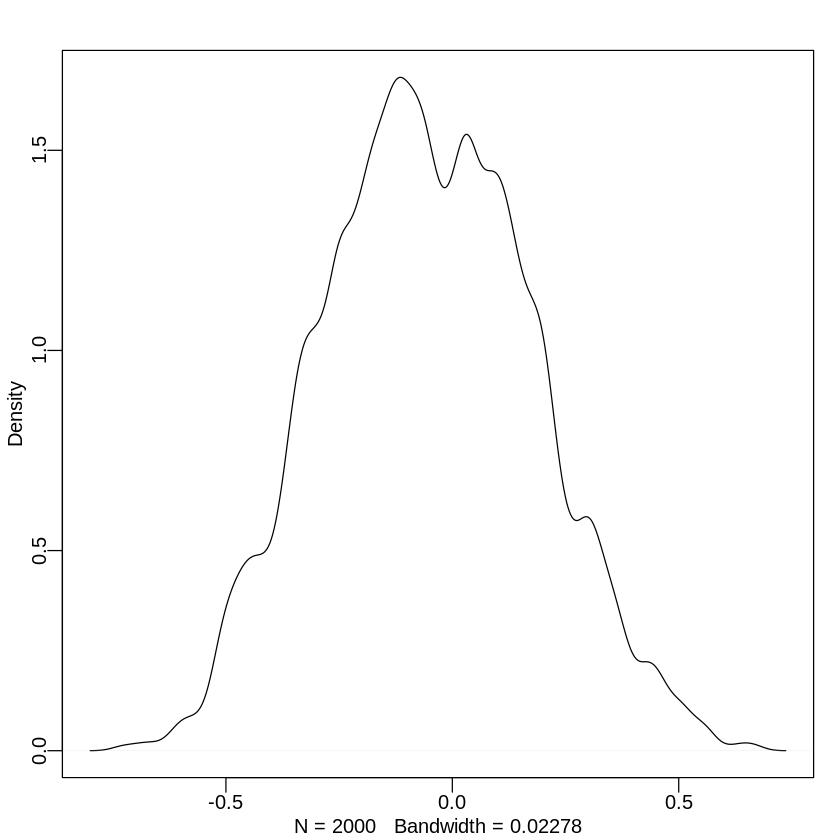

In [261]:
post <- extract.samples(m13M1, n=1e6)
dens( post$Rho[,1,2] )

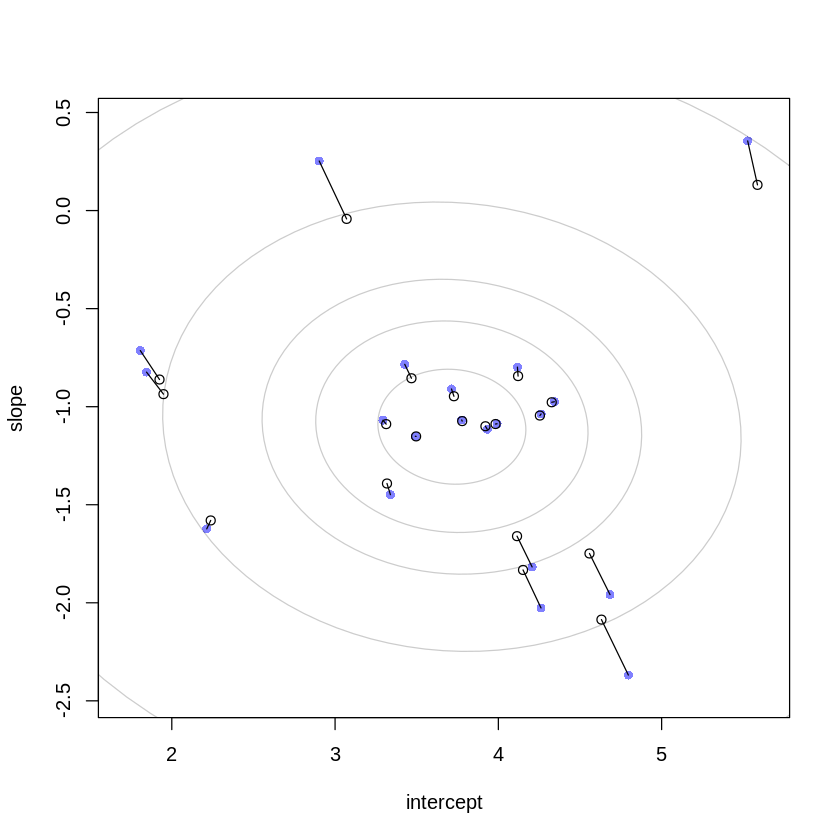

In [262]:
# compute unpooled estimates directly from data
a1 <- sapply( 1:N_cafes ,
function(i) mean(wait[cafe_id==i & afternoon==0]) )
b1 <- sapply( 1:N_cafes ,
function(i) mean(wait[cafe_id==i & afternoon==1]) ) - a1

# extract posterior means of partially pooled estimates
post <- extract.samples(m13M1)
a2 <- apply( post$a_cafe , 2 , mean )
b2 <- apply( post$b_cafe , 2 , mean )
# plot both and connect with lines
plot( a1 , b1 , xlab="intercept" , ylab="slope" ,
pch=16 , col=rangi2 , ylim=c( min(b1)-0.1 , max(b1)+0.1 ) ,
xlim=c( min(a1)-0.1 , max(a1)+0.1 ) )
points( a2 , b2 , pch=1 )
for ( i in 1:N_cafes ) lines( c(a1[i],a2[i]) , c(b1[i],b2[i]) )
             
# compute posterior mean bivariate Gaussian
Mu_est <- c( mean(post$a) , mean(post$b) )
rho_est <- mean( post$Rho[,1,2] )
sa_est <- mean( post$sigma_cafe[,1] )
sb_est <- mean( post$sigma_cafe[,2] )
cov_ab <- sa_est*sb_est*rho_est
Sigma_est <- matrix( c(sa_est^2,cov_ab,cov_ab,sb_est^2) , ncol=2 )

# draw contours
library(ellipse)
for ( l in c(0.1,0.3,0.5,0.8,0.99) )
lines(ellipse(Sigma_est,centre=Mu_est,level=l),
col=col.alpha("black",0.2))

13M2

In [2]:
a <- 3.5
b <- (-1)
sigma_a <- 1
sigma_b <- 0.5
rho <- (-0.7)

Mu <- c( a , b )
# cov_ab <- sigma_a*sigma_b*rho
# Sigma <- matrix( c(sigma_a^2,cov_ab,cov_ab,sigma_b^2) , ncol=2 )
sigmas <- c(sigma_a,sigma_b) # standard deviations
Rho <- matrix( c(1,rho,rho,1) , nrow=2 ) # correlation matrix
# now matrix multiply to get covariance matrix
Sigma <- diag(sigmas) %*% Rho %*% diag(sigmas)

N_cafes <- 20

In [3]:
library(MASS)
set.seed(5) # used to replicate example
vary_effects <- mvrnorm( N_cafes , Mu , Sigma )


Attaching package: ‘ellipse’

The following object is masked from ‘package:rethinking’:

    pairs

The following object is masked from ‘package:graphics’:

    pairs



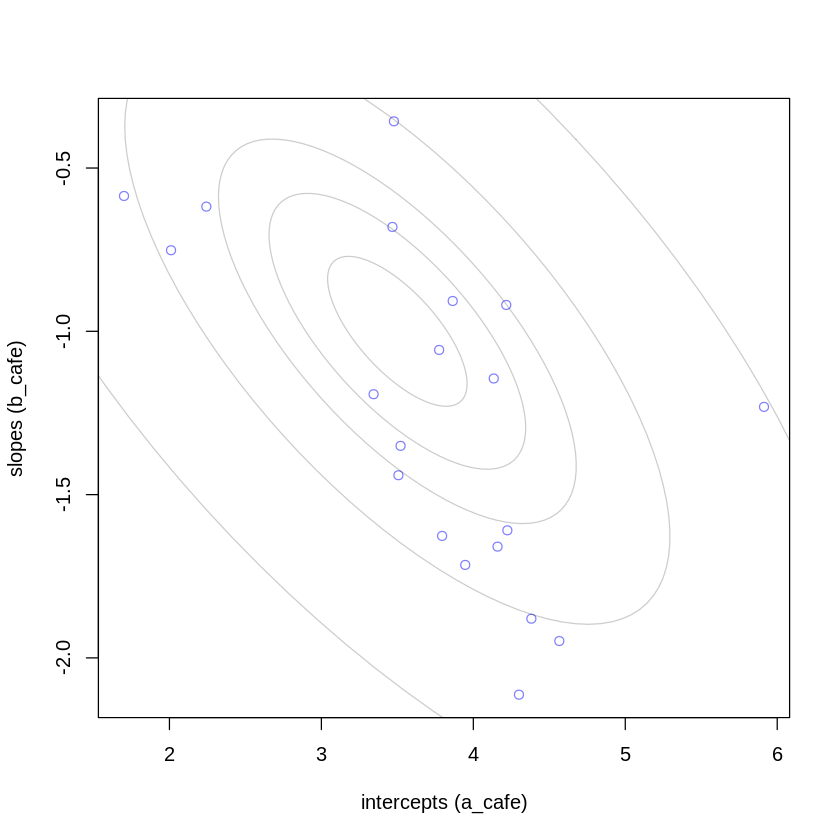

In [4]:
a_cafe <- vary_effects[,1]
b_cafe <- vary_effects[,2]

plot( a_cafe , b_cafe , col=rangi2 ,
xlab="intercepts (a_cafe)" , ylab="slopes (b_cafe)" )

# overlay population distribution
library(ellipse)
for ( l in c(0.1,0.3,0.5,0.8,0.99) )
lines(ellipse(Sigma,centre=Mu,level=l),col=col.alpha("black",0.2))

In [5]:
set.seed(22)
N_visits <- 10

afternoon <- rep(0:1,N_visits*N_cafes/2)
cafe_id <- rep( 1:N_cafes , each=N_visits )

mu <- a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma <- 0.5 # std dev within cafes
wait <- rnorm( N_visits*N_cafes , mu , sigma )
d <- data.frame( cafe=cafe_id , afternoon=afternoon , wait=wait )

In [17]:
m13M2multi <- ulam(
            alist(
                wait ~ normal( mu , sigma ),
                mu <- a_cafe[cafe] + b_cafe[cafe]*afternoon,
                c(a_cafe,b_cafe)[cafe] ~ multi_normal( c(a,b) , Rho , sigma_cafe ),
                a ~ normal(5,2),
                b ~ normal(-1,0.5),
                sigma_cafe ~ exponential(1),
                sigma ~ exponential(1),
                Rho ~ lkj_corr(2)
            ) , data=d , chains=4 , cores=4, log_lik=TRUE )

In [18]:
m13M2 <- ulam(
            alist(
                wait ~ normal( mu , sigma ),
                mu <- a_cafe[cafe] + b_cafe[cafe]*afternoon,
                a_cafe[cafe] ~ normal(a, sigma_a),
                b_cafe[cafe] ~ normal(b, sigma_b),
                a ~ normal(5,2),
                b ~ normal(-1,0.5),
                c(sigma_a, sigma_b) ~ exponential(1),
                sigma ~ exponential(1)
            ) , data=d , chains=4 , cores=4, log_lik=TRUE )

In [19]:
compare(m13M2multi, m13M2)

WAIC     pWAIC    dWAIC    weight    SE       dSE    
m13M2multi 304.6677 32.80529 0.000000 0.7687602 17.67556      NA
m13M2      307.0703 32.92431 2.402648 0.2312398 18.07940 2.35022

In [20]:
compare(m13M2multi, m13M2, func=LOO)

Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”

LOO      pLOO     dLOO     weight    SE       dSE     
m13M2multi 306.4999 33.72139 0.000000 0.7737807 17.85282       NA
m13M2      308.9595 33.86887 2.459567 0.2262193 18.25638 2.387694

The difference between the two models is small, with dSE around the same value as dWAIC or dLOO.  Although the m13M2multi model (i.e. the one in the chapter) has one extra parameter, that of the correlation between a and b as part of the Rho matrix, m13M2multi still manages to 1) retrodict better the data, and 2) have fewer effective parameters.  

Basically, the multivariate version treats the a and b (intercept and slope parameters) together rather than independently, so the effective parameters are smaller, and the fit is better because it captures the inter-relationship between the intercept and slopes, whereas the m13M2 model assumes a correlation of 0.


From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch13_hw.R:
"
First model (with multi-variate Gaussian priors(MVN)) has smaller WAIC and smaller number of effective parameters, thus it is better.
Smaller number of effective parameters can be explained by the fact that MVN takes into account correlation between slope and intercept and therefore requires fewer parameters to describe data. 
The second model(m13M2) treats intercept and slope independently and uses more parameters.
"

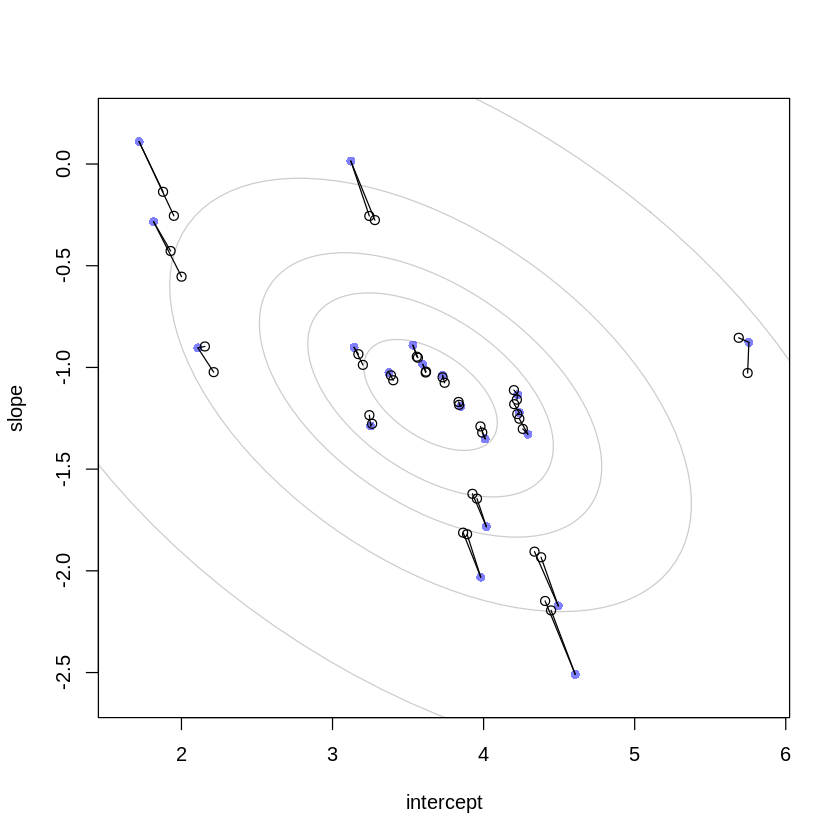

In [27]:
# compute unpooled estimates directly from data
a1 <- sapply( 1:N_cafes ,
function(i) mean(wait[cafe_id==i & afternoon==0]) )
b1 <- sapply( 1:N_cafes ,
function(i) mean(wait[cafe_id==i & afternoon==1]) ) - a1

# extract posterior means of partially pooled estimates
post <- extract.samples(m13M2multi)
a2 <- apply( post$a_cafe , 2 , mean )
b2 <- apply( post$b_cafe , 2 , mean )

# extract posterior means of partially pooled estimates
post3 <- extract.samples(m13M2)
a3 <- apply( post3$a_cafe , 2 , mean )
b3 <- apply( post3$b_cafe , 2 , mean )

             
# plot both and connect with lines
plot( a1 , b1 , xlab="intercept" , ylab="slope" ,
pch=16 , col=rangi2 , ylim=c( min(b1)-0.1 , max(b1)+0.1 ) ,
xlim=c( min(a1)-0.1 , max(a1)+0.1 ) )
points( a2 , b2 , pch=1 )
for ( i in 1:N_cafes ) lines( c(a1[i],a2[i]) , c(b1[i],b2[i]) )
points( a3 , b3 , pch=1 )
for ( i in 1:N_cafes ) lines( c(a1[i],a3[i]) , c(b1[i],b3[i]) )
             
# compute posterior mean bivariate Gaussian
Mu_est <- c( mean(post$a) , mean(post$b) )
rho_est <- mean( post$Rho[,1,2] )
sa_est <- mean( post$sigma_cafe[,1] )
sb_est <- mean( post$sigma_cafe[,2] )
cov_ab <- sa_est*sb_est*rho_est
Sigma_est <- matrix( c(sa_est^2,cov_ab,cov_ab,sb_est^2) , ncol=2 )

# draw contours
library(ellipse)
for ( l in c(0.1,0.3,0.5,0.8,0.99) )
lines(ellipse(Sigma_est,centre=Mu_est,level=l),
col=col.alpha("black",0.2))
             
             

13M3

Treat the slope 'b' in this model as the coefficient to a dummy female variable.  Thus, the slope acts as an adjustment to the 'base' male case that is represented by the intercept 'a'.

In [16]:
library(rethinking)
data(UCBadmit)
d <- UCBadmit
d$dFemale <- ifelse(d$applicant.gender=="male",0L,1L)
dat <- list(dept=as.integer(d$dept),admit=d$admit, applications=d$applications, dFemale=d$dFemale)
dat

$dept
 [1] 1 1 2 2 3 3 4 4 5 5 6 6

$admit
 [1] 512  89 353  17 120 202 138 131  53  94  22  24

$applications
 [1] 825 108 560  25 325 593 417 375 191 393 373 341

$dFemale
 [1] 0 1 0 1 0 1 0 1 0 1 0 1

In [17]:
m13M3dummy <- ulam(
            alist(
                admit ~ dbinom( applications , p ),
                logit(p) <- a_dept[dept] + b_dept[dept]*dFemale,
                c(a_dept,b_dept)[dept] ~ multi_normal( c(a,b) , Rho , sigma_dept ),
                a ~ normal(0,1),
                b ~ normal(0,1),
                sigma_dept ~ exponential(1),
                Rho ~ lkj_corr(2)
            ) , data=dat , chains=4 , cores=4, log_lik=TRUE )

Warning message:
“There were 37 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

Waiting to draw page 2 of 2


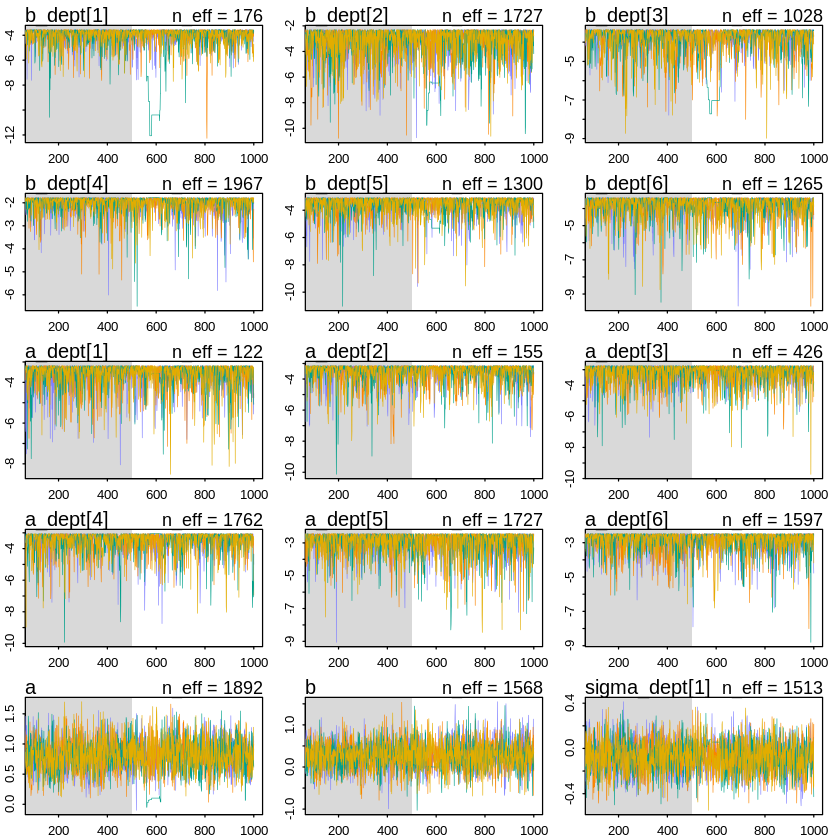

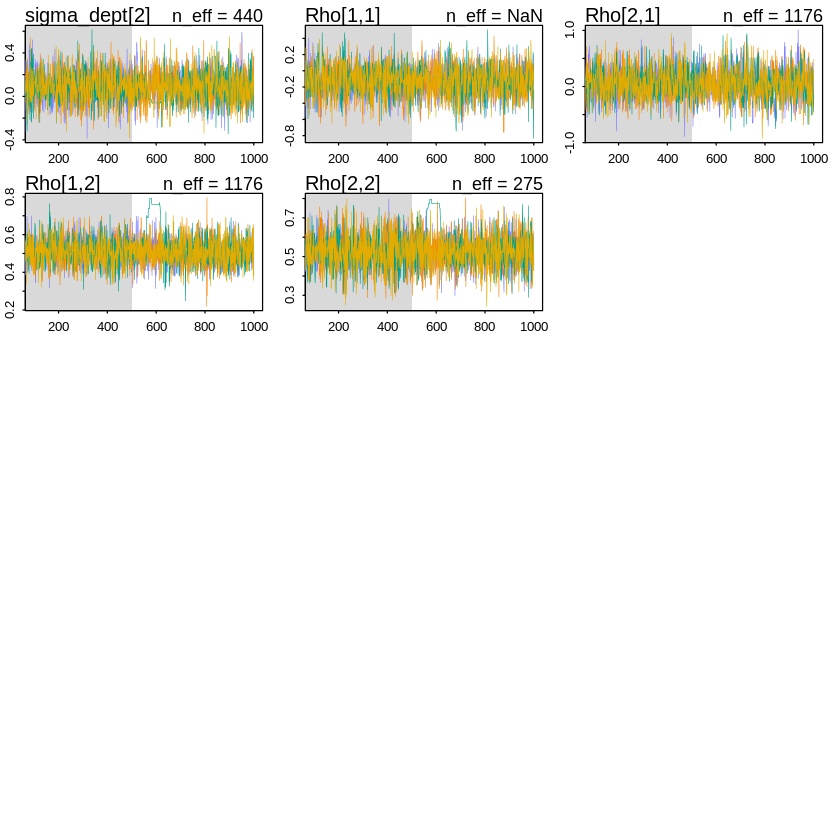

In [19]:
traceplot(m13M3dummy)

In [20]:
precis(m13M3dummy,depth=3)

mean        sd           5.5%       94.5%      n_eff    
b_dept[1]      0.80362946 2.870598e-01  0.3413825  1.2432258  176.0415
b_dept[2]      0.26251850 3.429534e-01 -0.2462101  0.8306234 1727.3445
b_dept[3]     -0.07555331 1.402970e-01 -0.3006868  0.1403315 1027.6038
b_dept[4]      0.08482136 1.428299e-01 -0.1326474  0.3227313 1967.2779
b_dept[5]     -0.12780485 1.867469e-01 -0.4445202  0.1554226 1299.7067
b_dept[6]      0.04256647 2.784768e-01 -0.3848188  0.5147648 1265.3881
a_dept[1]      0.51635697 8.139387e-02  0.3999024  0.6480546  121.7159
a_dept[2]      0.53194597 9.329643e-02  0.3917895  0.6895286  155.4710
a_dept[3]     -0.57388423 1.169987e-01 -0.7585470 -0.3855653  426.3619
a_dept[4]     -0.70570316 1.014971e-01 -0.8716396 -0.5505019 1762.3514
a_dept[5]     -1.00699019 1.516574e-01 -1.2412892 -0.7600798 1727.1797
a_dept[6]     -2.67274272 2.130091e-01 -3.0383511 -2.3461752 1596.9914
a             -0.51472809 4.719511e-01 -1.2030147  0.2858108 1892.3732
b              0.16481082 2.371916e-01 -0.1992334  0.5475514 1568.0374
sigma_dept[1]  1.31821416 4.853414e-01  0.7771314  2.1500769 1513.4426
sigma_dept[2]  0.48437238 2.463404e-01  0.1839063  0.9247494  439.6656
Rho[1,1]       1.00000000 0.000000e+00  1.0000000  1.0000000       NaN
Rho[1,2]       0.26370701 3.471255e-01 -0.3205083  0.7735942 1176.3384
Rho[2,1]       0.26370701 3.471255e-01 -0.3205083  0.7735942 1176.3384
Rho[2,2]       1.00000000 7.336872e-17  1.0000000  1.0000000  275.4353
              Rhat     
b_dept[1]     1.0208294
b_dept[2]     1.0027983
b_dept[3]     1.0021066
b_dept[4]     1.0019063
b_dept[5]     0.9994494
b_dept[6]     1.0024804
a_dept[1]     1.0323848
a_dept[2]     1.0292785
a_dept[3]     1.0092946
a_dept[4]     1.0015668
a_dept[5]     0.9989309
a_dept[6]     1.0008159
a             0.9996326
b             1.0030603
sigma_dept[1] 1.0013696
sigma_dept[2] 1.0090736
Rho[1,1]            NaN
Rho[1,2]      0.9997744
Rho[2,1]      0.9997744
Rho[2,2]      0.9979980

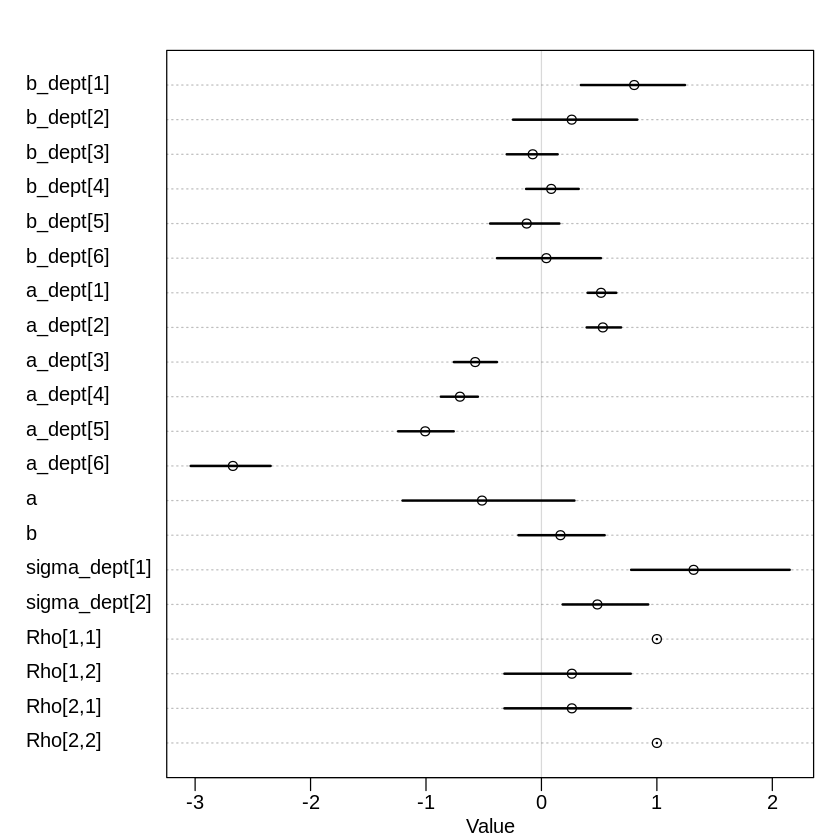

In [21]:
plot(precis(m13M3dummy,depth=3))

The university (population)-wide parameter a has a mean value less an 0, reflecting the data where the probability of admission of males is less than 50% (which corresponds to logit(p)=0).  The university (population)-wide parameter b is close to 0, reflecting no significant gender bias, although as the mean is above 0, there is an argument that if anything, females are more likely to be admitted on a university wide basis.

On a departmental basis, all b_dept coefficients are around 0 except dept 1 which is significantly positive.  This suggests there was no discrimination against females and in fact an advantage for females in department 1, however that department already had a high probability of admission for males (as a_dept[1] is significantly above zero.

The correlation (Rho[1,2]) is near 0, with a mean of 0.25.  This suggests that the greater the probability of admission for males, females experience an even greater probability of admission, although the advantage (correlation) is not that big.

The comparison of sigma_dept[1] and [2] magnitudes may not be very fair, because of the problem with using dummy variables, where the prior variance of (a+b) is greater than the prior variance of (a).  Despite this issue, it appears that there is much greater variance in the probability of admission among males than females (sigma_dept[1] corresponds to the intercept parameter a, which is greater than sigma_dept[2], which corresponds to the slope parameter b).  However, when we reformulate in terms of index variables for gender, rather than the dummy variable, this effect disappears.

Note that the sampling n_eff may not be very good for some of the variables, though it seems to be quite stochastic, depending on the random seed.


In [22]:
gender <- ifelse(d$applicant.gender=="male",1L,2L)
dat <- list(dept=as.integer(d$dept),admit=d$admit, applications=d$applications, gender=gender)
dat

$dept
 [1] 1 1 2 2 3 3 4 4 5 5 6 6

$admit
 [1] 512  89 353  17 120 202 138 131  53  94  22  24

$applications
 [1] 825 108 560  25 325 593 417 375 191 393 373 341

$gender
 [1] 1 2 1 2 1 2 1 2 1 2 1 2

In [23]:
m13M3idx <- ulam(
            alist(
                admit ~ dbinom( applications , p ),
                logit(p) <- alpha[dept,gender],
                
                transpars> matrix[6,2]:alpha ~ multi_normal( c(a,b) , Rho , sigma_dept ),                
#                 # adaptive priors - non-centered
#                 transpars> matrix[dept,2]:alpha <- compose_noncentered( sigma_dept , L_Rho , z ),
                
#                 vector[2]:a ~ normal(0,1),
                a ~ normal(0,1),
                b ~ normal(0,1),
#                 matrix[2,dept]:z ~ normal( 0 , 1 ),
                
                sigma_dept ~ exponential(1),
#                 vector[2]:sigma_dept ~ exponential(1),
                
                Rho ~ lkj_corr(2)
                
            ) , data=dat , chains=4 , cores=4, log_lik=TRUE )

recompiling to avoid crashing R session
Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [24]:
precis(m13M3idx, depth=3)

mean       sd           5.5%       94.5%       n_eff    Rhat     
alpha[1,1]     0.4945494 6.942450e-02  0.3840900  0.60464074 3038.302 0.9993626
alpha[1,2]     1.4539798 2.499089e-01  1.0596912  1.87492764 2220.268 1.0025742
alpha[2,1]     0.5259762 8.660475e-02  0.3887530  0.66362288 2478.327 0.9990135
alpha[2,2]     0.7417614 3.900342e-01  0.1173914  1.36474877 2904.674 0.9989532
alpha[3,1]    -0.5459298 1.133523e-01 -0.7285144 -0.35776727 2901.977 1.0000869
alpha[3,2]    -0.6552867 8.746819e-02 -0.7986363 -0.51694582 2179.175 0.9991909
alpha[4,1]    -0.7083117 1.066843e-01 -0.8750649 -0.53946514 2463.014 1.0007401
alpha[4,2]    -0.6221024 1.083529e-01 -0.7945628 -0.44799962 2588.273 0.9999262
alpha[5,1]    -0.9679481 1.567902e-01 -1.2232357 -0.71908070 2599.578 1.0007438
alpha[5,2]    -1.1501548 1.158737e-01 -1.3424451 -0.96597338 3055.503 1.0000569
alpha[6,1]    -2.6869887 2.090180e-01 -3.0301337 -2.36184749 2808.273 1.0003141
alpha[6,2]    -2.5754073 2.004949e-01 -2.9025777 -2.26229183 2958.486 0.9994255
a             -0.5108305 3.894542e-01 -1.1244288  0.09620444 1177.873 1.0001964
b             -0.3096253 4.545452e-01 -1.0198791  0.42708889 1677.805 1.0001333
sigma_dept[1]  1.0995568 3.258660e-01  0.7089398  1.69331785  945.670 1.0041389
sigma_dept[2]  1.3074708 3.861446e-01  0.8392962  2.00593595 1248.192 1.0021615
Rho[1,1]       1.0000000 0.000000e+00  1.0000000  1.00000000      NaN       NaN
Rho[1,2]       0.6823725 2.499853e-01  0.1963371  0.94773054 1456.625 1.0020104
Rho[2,1]       0.6823725 2.499853e-01  0.1963371  0.94773054 1456.625 1.0020104
Rho[2,2]       1.0000000 5.828806e-17  1.0000000  1.00000000  869.949 0.9979980

With the index variable for gender, the sampling seems better than when using the dummy variable formulation.  I'm not sure if this is robust to using a different random seed though.

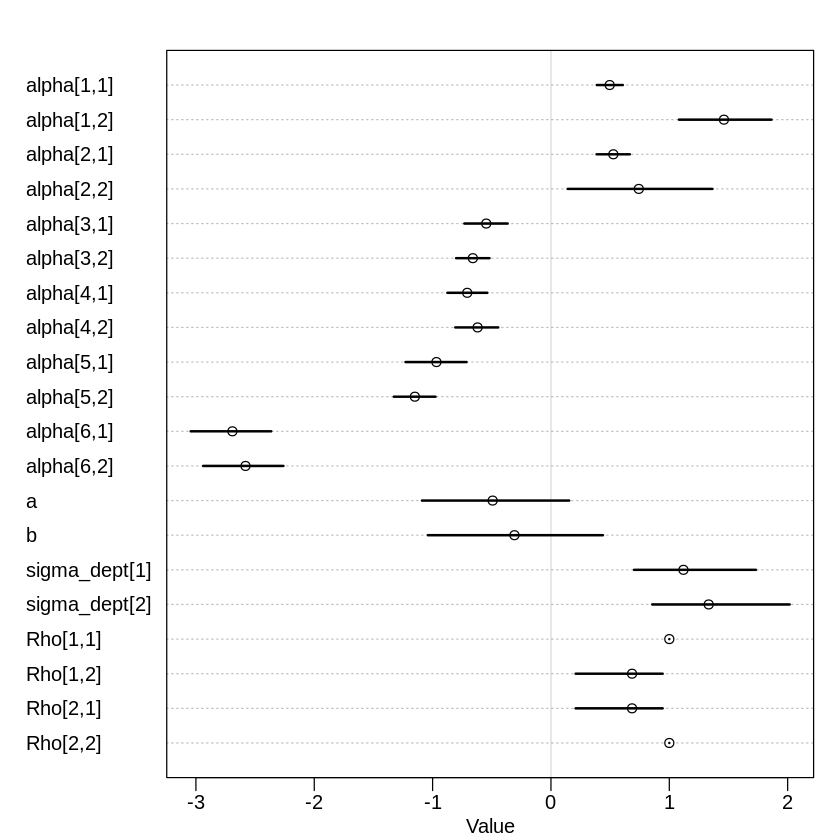

In [14]:
plot(precis(m13M3idx, depth=3))

To interpret this, I suppose the alphas correspond to combinations of a and a+b:  alpha[dept, 1] is equivalent to a[dept] in the m13M3dummy formulation, while alpha[dept, 2] is equivalent to a[dept]+b[dept].  

The alphas corroborate that found using the dummy variables: there is no bias against females when judged on a department-wide basis; in fact department 1 tends to favour females (a[1,2] > a[1,1]).

In this formulation, the sigma_dept[1] and [2] are much more similar, perhaps because we are treating the priors for sigma_dept equally in the two genders, which is not possible using a dummy variable for Females, as we tried previously in m13M3dummy.

Note that the correlation Rho[1,2] is much larger in this formulation using an index variable for gender (at aorund 0.7), as opposed to the dummy variable for female used previously, where the correlation was only around 0.25.

Let's now do the non-centered parameterization to try to remove the divergent transitions:

In [25]:
m13M3nc <- ulam(
            alist(
                admit ~ dbinom( applications , p ),
                logit(p) <- alpha[dept,gender],
                
#                 c(a_dept,b_dept)[dept] ~ multi_normal( c(a,b) , Rho , sigma_dept ),                
                # adaptive priors - non-centered
                transpars> matrix[dept,2]:alpha <- compose_noncentered( sigma_dept , L_Rho , z ),
                
#                 a ~ normal(0,2),
#                 b ~ normal(0,2),
                matrix[2,dept]:z ~ normal( 0 , 1 ),
                
#                 sigma_dept ~ exponential(1),
                vector[2]:sigma_dept ~ exponential(1),
                
#                 Rho ~ lkj_corr(2)
                cholesky_factor_corr[2]:L_Rho ~ lkj_corr_cholesky( 2 ),
                
                # compute ordinary correlation matrixes from Cholesky factors
                gq> matrix[2,2]:Rho <<- multiply_lower_tri_self_transpose(L_Rho)
                
            ) , data=dat , chains=4 , cores=4, log_lik=TRUE )

In [26]:
precis(m13M3nc, depth=3)

mean       sd           5.5%       94.5%      n_eff     Rhat     
z[1,1]         0.4713645 1.366438e-01  0.2737509  0.7053958  374.3913 1.0069119
z[1,2]         0.5014412 1.510672e-01  0.2851249  0.7636717  355.3859 1.0049578
z[1,3]        -0.5026953 1.660190e-01 -0.7992182 -0.2605344  441.9460 1.0066288
z[1,4]        -0.6549968 1.882957e-01 -0.9894197 -0.3896013  338.0296 1.0063345
z[1,5]        -0.8872758 2.588361e-01 -1.3348130 -0.5032293  393.7804 1.0038215
z[1,6]        -2.5082683 5.870560e-01 -3.4796400 -1.5857837  337.3955 1.0051708
z[2,1]         1.3987641 4.952150e-01  0.6873471  2.2739567  825.8627 0.9994194
z[2,2]         0.3348320 5.735376e-01 -0.5670150  1.2704477 1296.0678 1.0034194
z[2,3]        -0.2846618 2.870756e-01 -0.7160051  0.1880614  778.7966 1.0028640
z[2,4]        -0.0331444 3.477917e-01 -0.5244234  0.5763307  557.0012 1.0024596
z[2,5]        -0.4813560 4.248518e-01 -1.1144618  0.2111438  901.4100 1.0007892
z[2,6]        -0.4258721 9.104194e-01 -1.8615530  1.0529377  675.9777 1.0019930
sigma_dept[1]  1.1367116 3.116002e-01  0.7491113  1.7026569  387.3601 1.0015898
sigma_dept[2]  1.2499113 3.214366e-01  0.8420461  1.8319049  591.4161 0.9999647
L_Rho[1,1]     1.0000000 0.000000e+00  1.0000000  1.0000000       NaN       NaN
L_Rho[1,2]     0.0000000 0.000000e+00  0.0000000  0.0000000       NaN       NaN
L_Rho[2,1]     0.7204869 2.018849e-01  0.3264236  0.9429330  756.7343 1.0004357
L_Rho[2,2]     0.6355364 1.904551e-01  0.3329818  0.9452235  728.3261 0.9996351
Rho[1,1]       1.0000000 0.000000e+00  1.0000000  1.0000000       NaN       NaN
Rho[1,2]       0.7204869 2.018849e-01  0.3264236  0.9429330  756.7343 1.0004357
Rho[2,1]       0.7204869 2.018849e-01  0.3264236  0.9429330  756.7343 1.0004357
Rho[2,2]       1.0000000 4.531333e-17  1.0000000  1.0000000  486.6594 0.9979980
alpha[1,1]     0.5018362 7.259391e-02  0.3864248  0.6157810 2486.3769 0.9995806
alpha[1,2]     1.4166592 2.444684e-01  1.0334753  1.8162537 2473.5502 1.0000748
alpha[2,1]     0.5336975 8.595965e-02  0.3968694  0.6705225 2542.7826 0.9996892
alpha[2,2]     0.6992155 3.779310e-01  0.1076876  1.2978152 2041.7344 1.0005764
alpha[3,1]    -0.5351038 1.136486e-01 -0.7193507 -0.3469839 1690.3954 1.0005654
alpha[3,2]    -0.6563722 8.372008e-02 -0.7859094 -0.5235593 2554.3985 1.0001893
alpha[4,1]    -0.6983065 1.030870e-01 -0.8673391 -0.5395058 2555.0749 0.9984594
alpha[4,2]    -0.6231270 1.077255e-01 -0.7943238 -0.4469773 2354.0667 0.9992303
alpha[5,1]    -0.9473097 1.575450e-01 -1.1980191 -0.7029549 2598.8647 0.9985914
alpha[5,2]    -1.1487012 1.167012e-01 -1.3352617 -0.9724307 2198.6746 1.0002323
alpha[6,1]    -2.6876450 2.160586e-01 -3.0366909 -2.3431650 1787.0820 1.0000973
alpha[6,2]    -2.5765292 2.053413e-01 -2.9207307 -2.2524354 2144.9743 0.9989619

Note that the sampling n_eff doesn't appear to be significantly better than that of m13M3idx, however in the non-centered parameterization case, there are no divergent transitions unlike in m13M3idx.

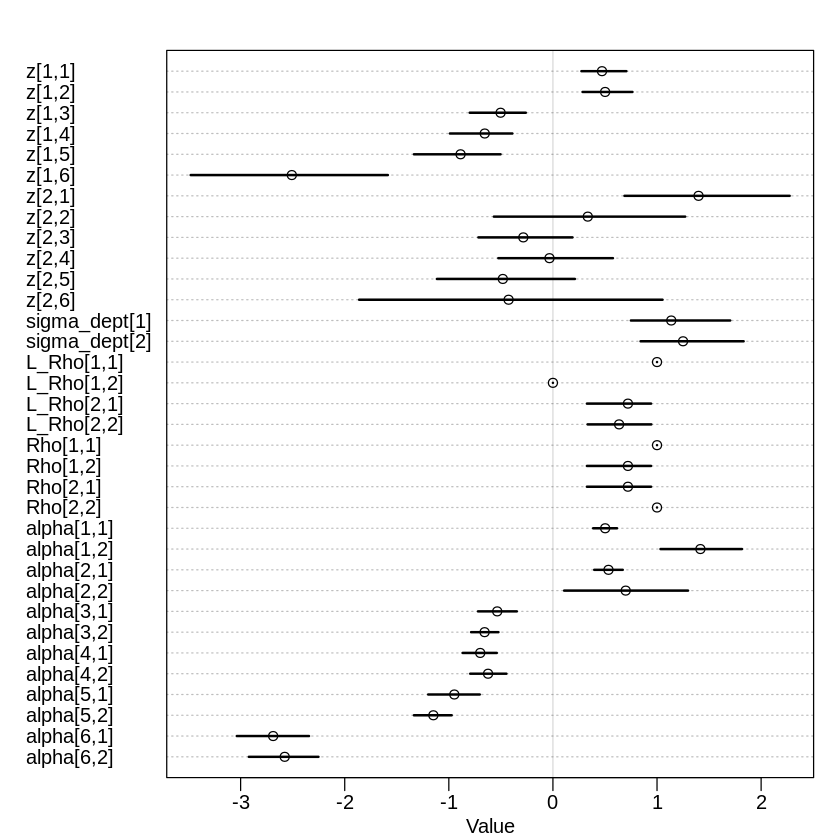

In [28]:
plot(precis(m13M3nc, depth=3))

The estimates here are similar to the m13M3idx model, with correlation Rho[1,2] around 0.7, and the same shape of alphas and sigma_depts.

The z scores seem to be related to the alphas in some way - the alpha[dept, 1]s look like the z[1, dept], and the z[2, dept] look like some sort of adjustmen to z[1, dept].  The scales may be different between the z's and alpha's, so this also causes issues trying to interpret the z's.

In [29]:
compare(m13M3dummy, m13M3idx, m13M3nc)

WAIC     pWAIC    dWAIC     weight     SE       dSE      
m13M3idx   89.06536 5.957799 0.0000000 0.51077510 3.612219        NA
m13M3nc    89.31595 6.041665 0.2505821 0.45062626 3.588796 0.6805609
m13M3dummy 94.23079 8.309304 5.1654246 0.03859864 5.335370 3.5197949

In [31]:
compare(m13M3dummy, m13M3idx, m13M3nc, func=LOO)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

LOO       pLOO      dLOO      weight      SE       dSE     
m13M3nc     95.05873  8.913056 0.0000000 0.548589658 4.117048       NA
m13M3idx    95.48732  9.168776 0.4285895 0.442772439 4.014324 1.897206
m13M3dummy 103.36111 12.874465 8.3023816 0.008637904 8.141908 5.008640

The LOO favours the nc version more than idx, contradicting WAIC, but the weights suggest the difference is small, and dSE is much largers than dLOO.  The effective parameters is estimated as much higher by LOO than WAIC.  In both WAIC and LOO, the dummy forumation is the worst with a very low weight.

13M4

In [2]:
library(rethinking)
data(Kline)
d <- Kline

In [9]:
d$P <- scale( log(d$population) )
d$contact_id <- ifelse( d$contact=="high" , 2L , 1L )

In [10]:
dat <- list(
T = d$total_tools ,
P = d$P ,
cid = d$contact_id )

In [11]:
# geocentric interaction model
m11.10 <- ulam(
                alist(
                    T ~ dpois( lambda ),
                    log(lambda) <- a[cid] + b[cid]*P,
                    a[cid] ~ dnorm( 3 , 0.5 ),
                    b[cid] ~ dnorm( 0 , 0.2 )
                ), data=dat , chains=4 , cores=4, log_lik=TRUE )

In [13]:
dat2 <- list( T=d$total_tools, P=d$population, cid=d$contact_id )

#'scientific' model
m11.11 <- ulam(
                alist(
                    T ~ dpois( lambda ),
                    lambda <- exp(a[cid])*P^b[cid]/g,
                    a[cid] ~ dnorm(1,1),
                    b[cid] ~ dexp(1),
                    g ~ dexp(1)
                ), data=dat2 , chains=4 , cores=4, log_lik=TRUE )

recompiling to avoid crashing R session


In [16]:
data(Kline2) # load the ordinary data, now with coordinates
d <- Kline2
d$society <- 1:10 # index observations

data(islandsDistMatrix)
# display (measured in thousands of km)
Dmat <- islandsDistMatrix
colnames(Dmat) <- c("Ml","Ti","SC","Ya","Fi","Tr","Ch","Mn","To","Ha")
#round(Dmat,1)

dat_list <- list(
                T = d$total_tools,
                P = d$population,
                society = d$society,
                Dmat=islandsDistMatrix )

# # varying effects model
# m14.7 <- ulam(
#               alist(
#                   T ~ dpois(lambda),
#                   lambda <- (a*P^b/g)*exp(k[society]),
#                   vector[10]:k ~ multi_normal( 0 , SIGMA ),
#                   matrix[10,10]:SIGMA <- cov_GPL2( Dmat , etasq , rhosq , 0.01 ),
#                   c(a,b,g) ~ dexp( 1 ),
#                   etasq ~ dexp( 2 ),
#                   rhosq ~ dexp( 0.5 )
#               ), data=dat_list , chains=4 , cores=4 , iter=2000 )

# # varying effects model
m14.7nc <- ulam(
                alist(
                    T ~ dpois(lambda),
                    lambda <- (a*P^b/g)*exp(k[society]),

                    # non-centered Gaussian Process prior
                    transpars> vector[10]: k <<- L_SIGMA * z,
                    vector[10]: z ~ normal( 0 , 1 ),
                    transpars> matrix[10,10]: L_SIGMA <<- cholesky_decompose( SIGMA ),
                    transpars> matrix[10,10]: SIGMA <- cov_GPL2( Dmat , etasq , rhosq , 0.01 ),
                    c(a,b,g) ~ dexp( 1 ),
                    etasq ~ dexp( 2 ),
                    rhosq ~ dexp( 0.5 )
                    ), data=dat_list , chains=4 , cores=4 #, iter=2000 
                , log_lik=TRUE
                )

recompiling to avoid crashing R session


In [17]:
compare(m11.10, m11.11, m14.7nc)

WAIC     pWAIC    dWAIC    weight       SE        dSE     
m14.7nc 67.51683 4.041506  0.00000 0.9979942143  2.158646       NA
m11.11  80.33437 5.032823 12.81754 0.0016437464 11.361905 11.49946
m11.10  83.36033 5.972726 15.84350 0.0003620393 12.150214 12.18410

In [18]:
compare(m11.10, m11.11, m14.7nc, func=LOO)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

LOO      pLOO     dLOO     weight       SE        dSE     
m14.7nc 70.15544 5.360809  0.00000 0.9951290163  2.569748       NA
m11.11  81.06566 5.398465 10.91022 0.0042535888 12.018604 11.46056
m11.10  84.92568 6.755398 14.77024 0.0006173949 13.188332 12.42343

The gaussian process model is rated the best for retrodiction of the data, although the dWAIC and dLOOs have very similar magnitudes to dSE, so it is not a massively significant improvement on the other models.

The effective number of parameters is smallest for m14.7nc, as measured by WAIC, but equal between this model and m11.11 as rated by LOO.  The adaptive regularization does a great job and limiting the overfitting possibilities of including the extra parameters of the covariance matrix and the society specific k parameters.  The fixed effect models have 4 or 5 actual parameters, while the gaussian process model has 15 parameters, however the effective parameters for the gaussian process model is less than the fixed effects models.

In [19]:
( k <- LOOPk(m11.10) )

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

[1] 0.5175895 0.5171929 0.3729367 0.6154988 0.3261317 0.5864314 0.2494582
 [8] 0.3155030 0.8037720 0.8324242

In [20]:
( k <- LOOPk(m11.11) )

Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”

[1] 0.6060717 0.2012521 0.1504348 0.5708937 0.3052138 0.5611417 0.1202756
 [8] 0.2669439 0.4942413 0.6756659

In [21]:
( k <- LOOPk(m14.7nc) )

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

[1] 0.8327341 0.6241877 0.7408479 0.6123854 0.8952256 0.6144754 0.7692609
 [8] 0.7609937 0.7488860 0.8391865

The varying effects model has greater pareto-k-diagnostics (a bad thing) than the scientific model of fixed effects.

13H1 and Homework Week 9 Question 1

In [2]:
data(bangladesh)
d <- bangladesh

In [3]:
sort(unique(d$district))
d$district_id <- as.integer(as.factor(d$district))
sort(unique(d$district_id))

head(d)

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 55 56 57 58 59 60 61

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60

woman district use.contraception living.children age.centered urban
1 1     1        0                 4                18.4400     1    
2 2     1        0                 1                -5.5599     1    
3 3     1        0                 3                 1.4400     1    
4 4     1        0                 4                 8.4400     1    
5 5     1        0                 1               -13.5590     1    
6 6     1        0                 1               -11.5600     1    
  district_id
1 1          
2 1          
3 1          
4 1          
5 1          
6 1

In [4]:
dat = list(C=d$use.contraception, did=d$district_id, U=d$urban)

In [5]:
m13H1 <- ulam(
            alist(
                C ~ dbinom( 1, p ),
                logit( p ) <- a_did[did] + b_did[did] * U,
                
                c(a_did, b_did)[did] ~ multi_normal(c(a, b), Rho, sigma),
                c(a, b) ~ dnorm(0, 2),
                sigma ~ dexp(1),
                Rho ~ lkj_corr(2)
            
            ), data=dat, chains=4, cores=4, log_lik=TRUE
        )

In [6]:
precis(m13H1)

126 vector or matrix parameters hidden. Use depth=2 to show them.


mean       sd        5.5%       94.5%      n_eff     Rhat    
b  0.7177602 0.1703483  0.4478990  0.9877319  988.9846 1.001350
a -0.7149973 0.1008905 -0.8765792 -0.5619713 1713.8696 1.001105

126 vector or matrix parameters hidden. Use depth=2 to show them.


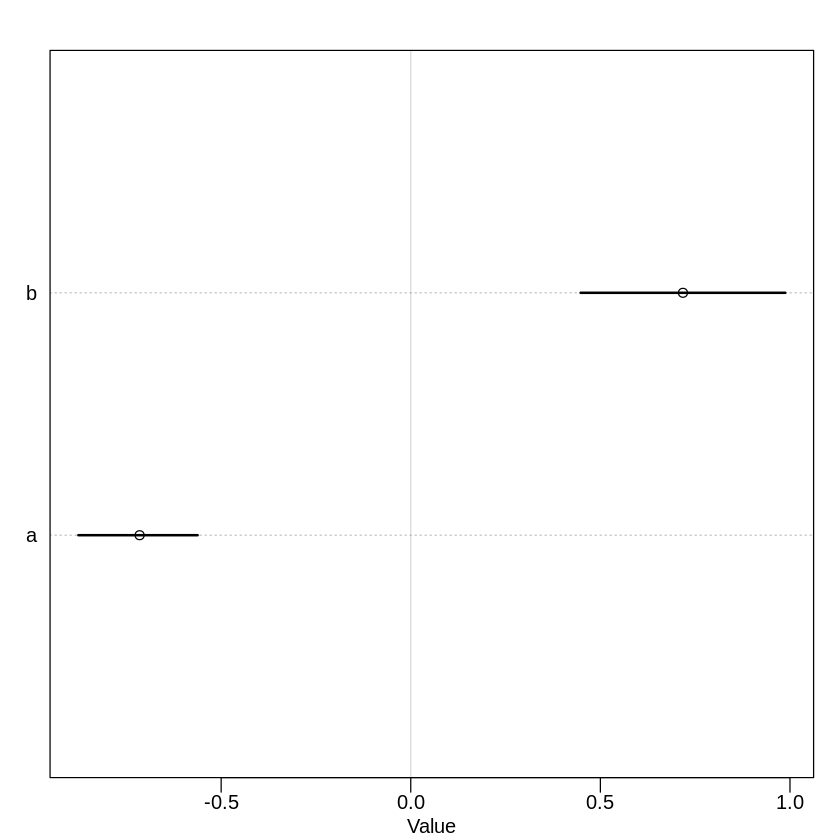

In [9]:
plot(precis(m13H1))

In [8]:
precis( m13H1 , depth=3 , pars=c("Rho","sigma") )

mean       sd           5.5%       94.5%      n_eff    Rhat    
Rho[1,1]  1.0000000 0.000000e+00  1.0000000  1.0000000      NaN      NaN
Rho[1,2] -0.6660025 1.643760e-01 -0.8683008 -0.3689999 340.0594 1.015974
Rho[2,1] -0.6660025 1.643760e-01 -0.8683008 -0.3689999 340.0594 1.015974
Rho[2,2]  1.0000000 6.321081e-17  1.0000000  1.0000000 481.5256 0.997998
sigma[1]  0.5807789 9.597871e-02  0.4418173  0.7409450 746.7182 1.008455
sigma[2]  0.7974670 1.988943e-01  0.5041390  1.1348159 329.2568 1.007381

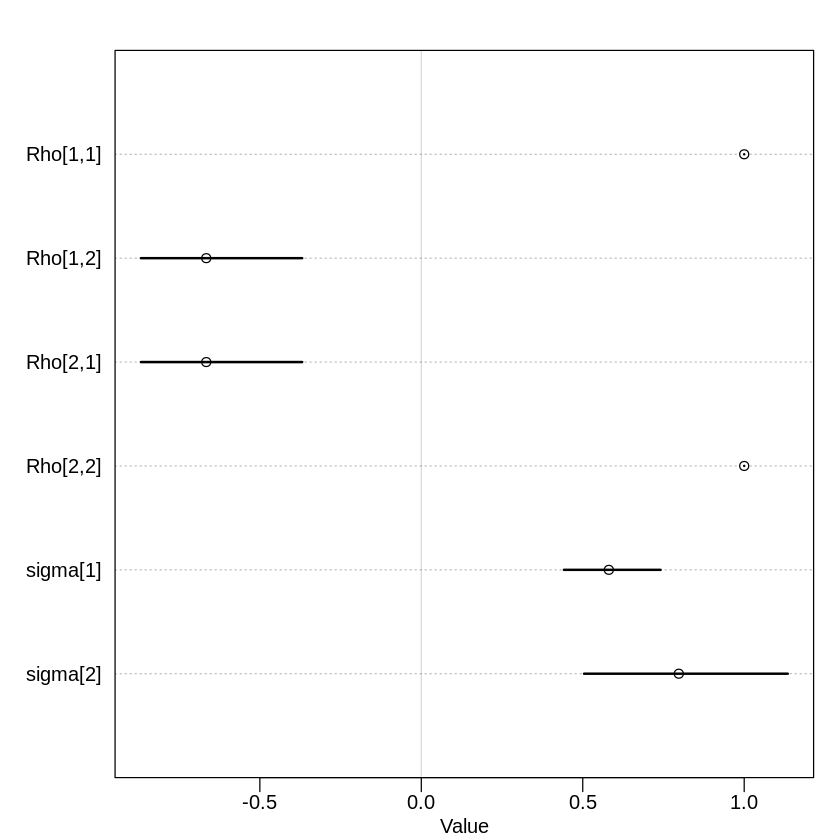

In [10]:
plot(precis( m13H1 , depth=3 , pars=c("Rho","sigma") ))

The correlation is around -0.65, suggesting a strong negative correlation between the intercept and slope.  Intercepts reflect the probability of contraception use in rural areas within districts, and the slopes the adjustment to the intercept to urban areas within districts.  The negative correlation means that areas with very low rural contraception use have relatively high contraception use, despite the low rural base.   Or conversely, districts with high rural use of contraception have urban rates that are not very different from the rural area.

The population wide intercept at -0.71 demonstrates the low rate of contraception across the population, while the slope of +0.71 (an almost exact magnitude of adjustment) puts the average urban rate at about 50% (because the inverse logit of 0 is 50%).

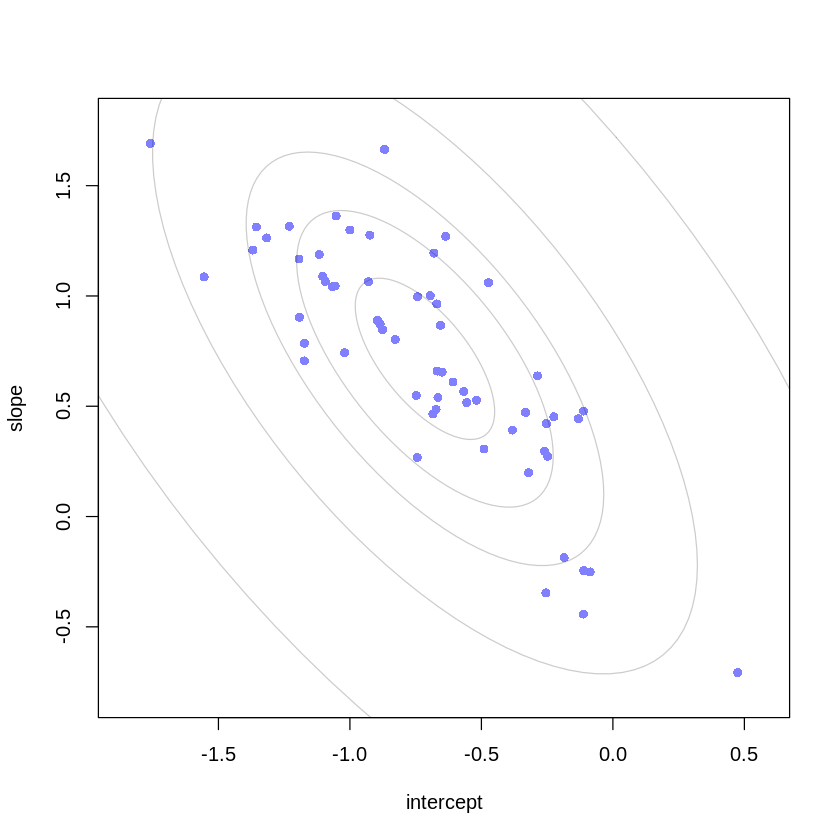

In [62]:
# N_did <- max(dat$did)
# # compute unpooled estimates directly from data
# a1 <- sapply( 1:N_did ,
# function(i) mean(dat$C[dat$did==i & dat$U==0]) )
# b1 <- sapply( 1:N_did ,
# function(i) mean(dat$C[dat$did==i & dat$U==1]) ) - a1

# extract posterior means of partially pooled estimates
post <- extract.samples(m13H1)
a2 <- apply( post$a_did , 2 , mean )
b2 <- apply( post$b_did , 2 , mean )

# plot both and connect with lines
plot( a2 , b2 , xlab="intercept" , ylab="slope" ,
pch=16 , col=rangi2 , ylim=c( min(b2)-0.1 , max(b2)+0.1 ) ,
xlim=c( min(a2)-0.1 , max(a2)+0.1 ) )
# points( a2 , b2 , pch=1 )
# for ( i in 1:N_did ) lines( c(a1[i],a2[i]) , c(b1[i],b2[i]) )
             
             
# compute posterior mean bivariate Gaussian
Mu_est <- c( mean(post$a) , mean(post$b) )
rho_est <- mean( post$Rho[,1,2] )
sa_est <- mean( post$sigma[,1] )
sb_est <- mean( post$sigma[,2] )
cov_ab <- sa_est*sb_est*rho_est
Sigma_est <- matrix( c(sa_est^2,cov_ab,cov_ab,sb_est^2) , ncol=2 )

# draw contours
library(ellipse)
for ( l in c(0.1,0.3,0.5,0.8,0.99) )
lines(ellipse(Sigma_est,centre=Mu_est,level=l),
col=col.alpha("black",0.2))    
             

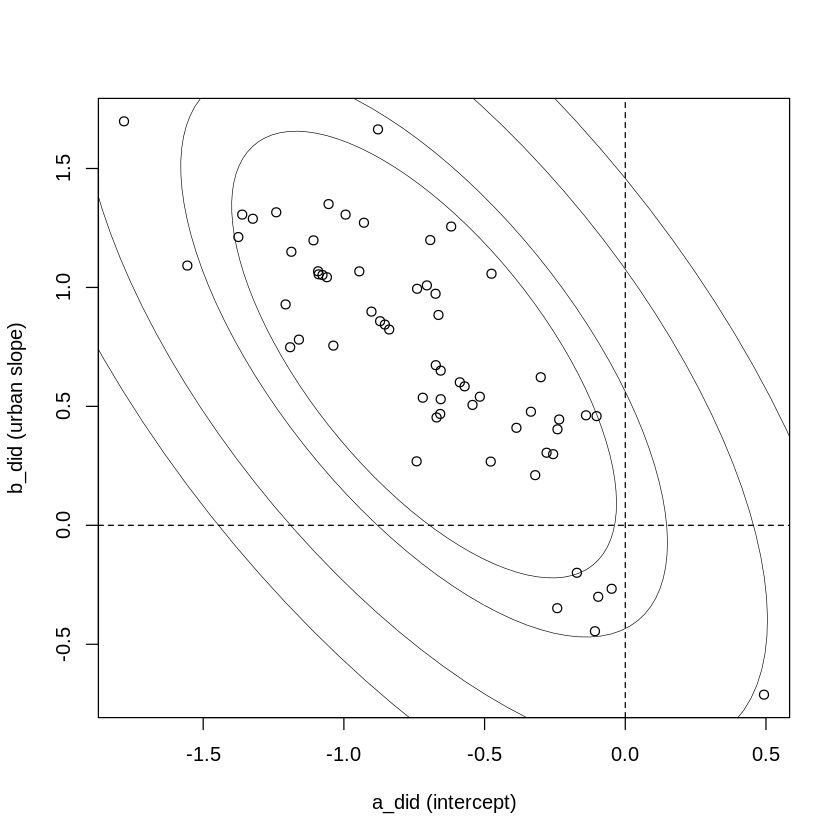

In [15]:
# From the solutions to the homework:

post <- extract.samples(m13H1)
a_did <- apply( post$a_did , 2 , mean )
b_did <- apply( post$b_did , 2 , mean )
plot( a_did, b_did , xlab="a_did (intercept)" , ylab="b_did (urban slope)" )
abline( h=0 , lty=2 )
abline( v=0 , lty=2 )
library(ellipse)
R <- apply( post$Rho , 2:3 , mean )
s <- apply( post$sigma , 2 , mean )
S <- diag(s) %*% R %*% diag(s)
ll <- c( 0.5 , 0.67 , 0.89 , 0.97 )
for ( l in ll ) {
el <- ellipse( S , centre=c( mean(post$a) , mean(post$b) ) , level=l )
lines( el , col="black" , lwd=0.5 )
}

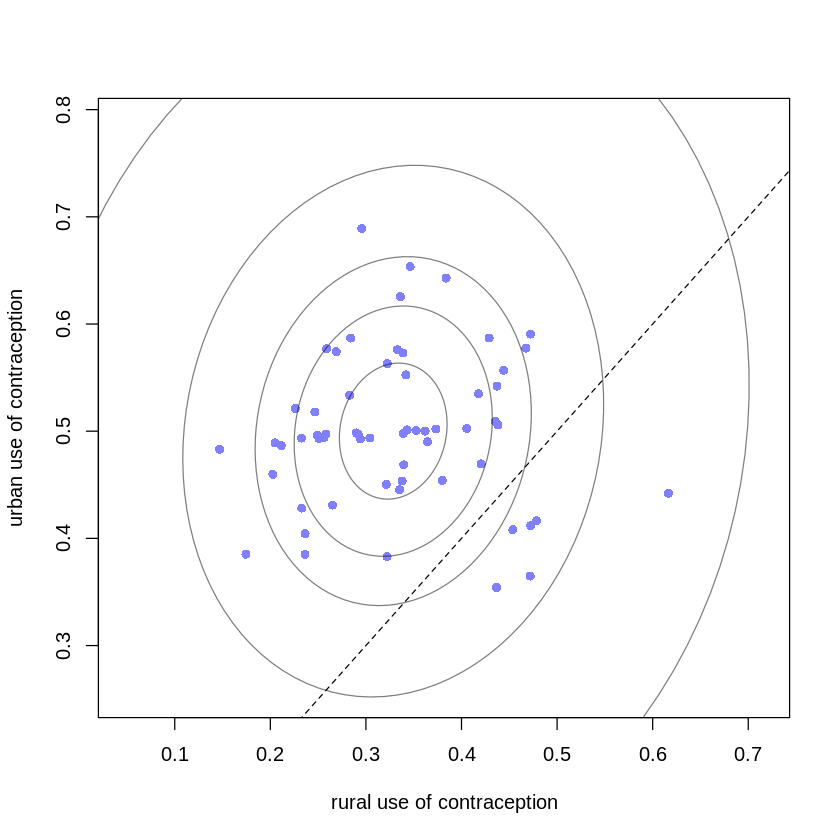

In [76]:
# convert varying effects to estimated proportions
# wait_morning_1 <- (a1)
# wait_afternoon_1 <- (a1 + b1)
rural_C <- inv_logit(a2)
urban_C <- inv_logit(a2 + b2)

# plot both and connect with lines
plot( rural_C , urban_C , xlab="predicted rural use of contraception" ,
ylab="predicted urban use of contraception" , pch=16 , col=rangi2 ,
ylim=c( min(urban_C)-0.1 , max(urban_C)+0.1 ) ,
xlim=c( min(rural_C)-0.1 , max(rural_C)+0.1 ) )
# points( wait_morning_2 , wait_afternoon_2 , pch=1 )
# for ( i in 1:N_cafes )
# lines( c(wait_morning_1[i],wait_morning_2[i]) ,
# c(wait_afternoon_1[i],wait_afternoon_2[i]) )
abline( a=0 , b=1 , lty=2 )

library(MASS)
# now shrinkage distribution by simulation
v <- mvrnorm( 1e4 , Mu_est , Sigma_est )
v[,2] <- v[,1] + v[,2] # calculate afternoon wait
v <- inv_logit(v)
Sigma_est2 <- cov(v)
Mu_est2 <- Mu_est
Mu_est2[2] <- Mu_est[1]+Mu_est[2]
Mu_est2 <- inv_logit(Mu_est2)

# draw contours
library(ellipse)
for ( l in c(0.1,0.3,0.5,0.8,0.99) )
lines(ellipse(Sigma_est2,centre=Mu_est2,level=l),
col=col.alpha("black",0.5))

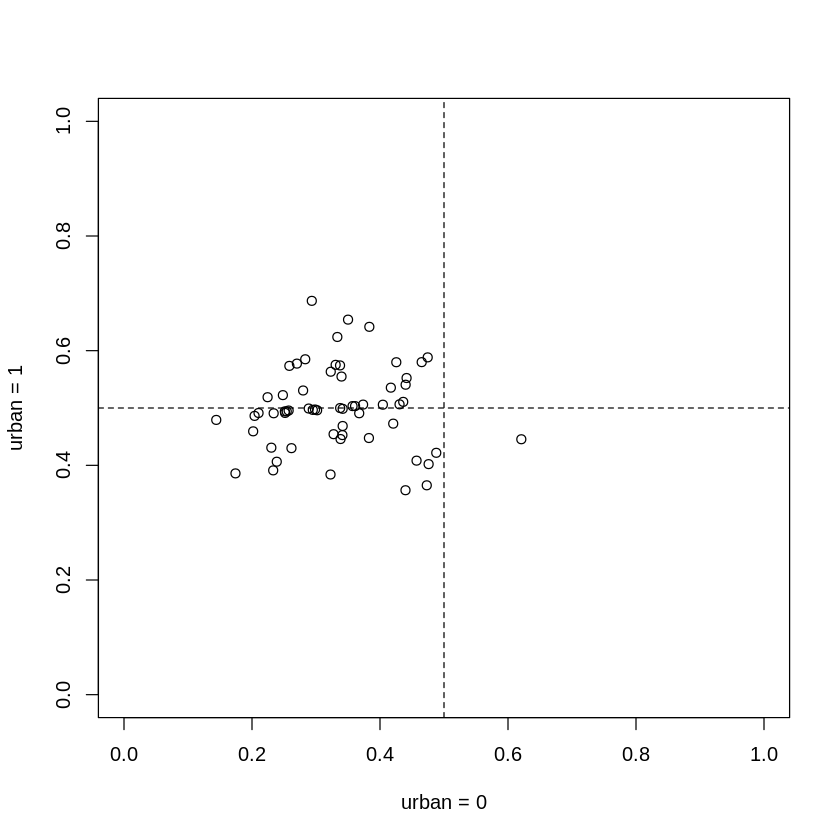

In [16]:
# From the homework solutions:
# "On the outcome scale, what this ends up meaning is that urban places are much
# the same in all districts, but rural areas vary a lot.  Plotting now in the outcome scale:"

u0 <- inv_logit( a_did )
u1 <- inv_logit( a_did + b_did )
plot( u0 , u1 , xlim=c(0,1) , ylim=c(0,1) , xlab="urban = 0" , ylab="urban = 1" )
abline( h=0.5 , lty=2 )
abline( v=0.5 , lty=2 )

In [77]:
cov2cor(Sigma_est2)

[,1]      [,2]     
[1,] 1.0000000 0.1023712
[2,] 0.1023712 1.0000000

On the whole, more women in urban areas of a district use contraception than those in rural areas of the same district, which is why most data points are above the diagonal line.

<s>There is a mild positive correlation in the outcome space of 0.1, where an increase in contraception use in rural areas is associasted with a mild increase in contraception use in an urban areas.</s>

From the homework solutions:
"On the outcome scale, what this ends up meaning is that urban places are much the same in all districts, but rural areas vary a lot.

This plot is on the probability scale. The horizontal axis is probability of contracep-
tive use in rural area of a district. The vertical is the probability in urban area of same
district. The urban areas all straddle 0.5. Most the of the rural areas are below 0.5.
The negative correlation between the intercepts and slopes is necessary to encode
this pattern.

In fact, if we fit the model so it instead has two intercepts, one for rural and one for
urban, there is no strong correlation between those intercepts. Here’s such a model:"

In [38]:
# version with matrix instead of slopes
dat$uid <- dat$U + 1L

In [23]:
m1.2 <- ulam(
            alist(
                C ~ bernoulli( p ),
                logit(p) <- a[did,uid],
                vector[2]:a[did] ~ multi_normal( c(abar,bbar) , Rho , Sigma ),
                abar ~ normal(0,1),
                bbar ~ normal(0,1),
                Rho ~ lkj_corr(2),
                Sigma ~ exponential(1)
            ) , data=dat, chains=4, cores=4, log_lik=TRUE )

precis( m1.2 , depth=3 , pars="Rho" )

Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

mean        sd           5.5%       94.5%     n_eff    Rhat    
Rho[1,1]  1.00000000 0.000000e+00  1.0000000 1.0000000      NaN      NaN
Rho[1,2] -0.08827872 2.873615e-01 -0.5378544 0.3775403 432.9620 1.003420
Rho[2,1] -0.08827872 2.873615e-01 -0.5378544 0.3775403 432.9620 1.003420
Rho[2,2]  1.00000000 7.645537e-17  1.0000000 1.0000000 244.8957 0.997998

"Correlation gone"

Homework 9 Question 2

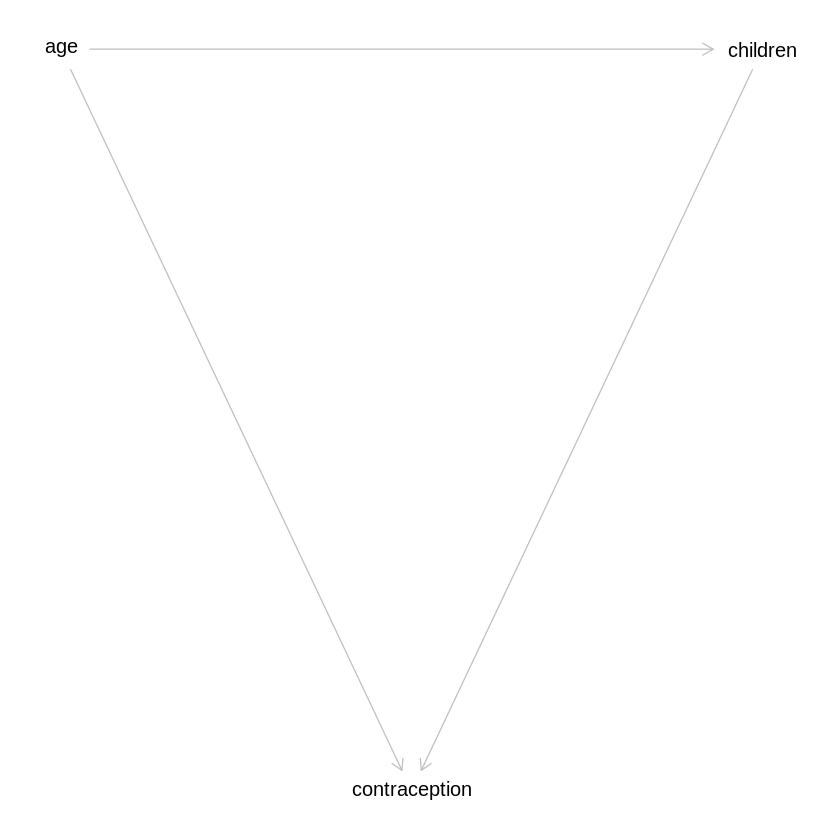

In [5]:
library(dagitty)

dag <- dagitty( "Dag {
                    age -> children -> contraception
                    age -> contraception
                    }")

coordinates( dag ) <- list( x=c(age=0,children=2,contraception=1) , y=c(age=0,children=0,contraception=1) ) 

plot( dag )

In [1]:
options(mc.cores = parallel::detectCores())
library(rethinking)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


In [2]:
data(bangladesh)
d <- bangladesh

d$district_id <- as.integer(as.factor(d$district))
age_std <- standardize(d$age.centered)
child_std <- standardize(d$living.children)

dat = list(C=d$use.contraception, did=d$district_id, U=d$urban, age_std=age_std, child_std=child_std)

In [11]:
m2.1 <- ulam(
            alist(
                C ~ dbinom( 1, p ),
                logit( p ) <- a_did[did] + bU[did] * U + bA[did] * age_std,
                
                c(a_did, bU, bA)[did] ~ multi_normal(c(abar, bUbar, bAbar), Rho, sigma),
                abar ~ dnorm(0, 1),
                c(bUbar, bAbar) ~ dnorm(0, 0.5),
                sigma ~ dexp(1),
                Rho ~ lkj_corr(2)
            
            ), data=dat, chains=4, cores=4, log_lik=TRUE
        )

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [12]:
precis(m2.1)

192 vector or matrix parameters hidden. Use depth=2 to show them.


mean        sd         5.5%         94.5%      n_eff     Rhat    
abar  -0.68736823 0.09805126 -0.843965102 -0.5347515 1827.6294 1.001749
bAbar  0.08172288 0.05478027 -0.007550511  0.1704799  459.3666 1.001727
bUbar  0.63015384 0.15884024  0.384933472  0.8898635 1281.9810 1.004596

In this model, the total causal effect of age is positive and very small. Older individ-
uals use slightly more contraception.

In [13]:
m2.2 <- ulam(
            alist(
                C ~ dbinom( 1, p ),
                logit( p ) <- a_did[did] + bU[did] * U + bA[did] * age_std + bLC[did] * child_std,
                
                c(a_did, bU, bA, bLC)[did] ~ multi_normal(c(abar, bUbar, bAbar, bLCbar), Rho, sigma),

                abar ~ dnorm(0, 1),
                c(bUbar, bAbar, bLCbar) ~ dnorm(0, 0.5),
                sigma ~ dexp(1),
                Rho ~ lkj_corr(2)
            
            ), data=dat, chains=4, cores=4, log_lik=TRUE
        )

Warning message:
“There were 46 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [14]:
precis(m2.2)

260 vector or matrix parameters hidden. Use depth=2 to show them.


mean       sd         5.5%       94.5%      n_eff     Rhat     
abar   -0.7232582 0.09698722 -0.8759972 -0.5605201 1454.0400 0.9998092
bLCbar  0.5091177 0.08262492  0.3806537  0.6401286  166.3998 1.0233113
bAbar  -0.2671728 0.07752757 -0.3983829 -0.1516971  131.9130 1.0245940
bUbar   0.6874377 0.15227387  0.4392718  0.9240948 1067.2612 0.9998915

In this model, the direct effect of age is negative, and much farther from zero than
before. The effect of number of children is strong and positive. These results are
consistent with the DAG, because they imply that the reason the total effect of age,
from m2.1 , is positive is that older individuals also have more kids. Having more
kids increases contraception. Being older, controlling for kids, actually makes con-
traception less likely.

Homework 9 Question 3

In [8]:
min(d$living.children)
max(d$living.children)

[1] 1

[1] 4

So there are no 0 children in the data.  The number of children runs from 1 to 4, similar to the education levels in the example in chapter 12 (with levels 1 to 8).

In [3]:
alpha = rep(2,3)    # delta prior

dat = list(C=d$use.contraception, did=d$district_id, U=d$urban, age_std=age_std, 
               child=d$living.children, alpha=alpha)

m3 <- ulam(
            alist(
                C ~ dbinom( 1, p ),
                logit( p ) <- a_did[did] + bU[did] * U + bA[did] * age_std + 
                                                            bLC[did] * sum( delta_LC[1:child] ),
                
                c(a_did, bU, bA, bLC)[did] ~ multi_normal(c(abar, bUbar, bAbar, bLCbar), Rho, sigma),

                vector[4]: delta_LC <<- append_row(0, delta),
                simplex[3]: delta ~ dirichlet( alpha ),
                
                abar ~ dnorm(0, 1),
                c(bUbar, bAbar, bLCbar) ~ dnorm(0, 0.5),
                sigma ~ dexp(1),
                Rho ~ lkj_corr(2)
            
            ), data=dat, chains=4, cores=4, log_lik=TRUE,
        )

Cautionary note:
Variable alpha contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.
Warning message:
“There were 61 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 40 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [4]:
precis(m3)

263 vector or matrix parameters hidden. Use depth=2 to show them.


mean       sd         5.5%       94.5%      n_eff     Rhat    
abar   -1.5498822 0.16329525 -1.8119249 -1.2958611  358.2933 1.014290
bLCbar  1.2515080 0.17274433  0.9720371  1.5259327  256.1630 1.028282
bAbar  -0.2357781 0.06682233 -0.3435784 -0.1274978  123.3164 1.031968
bUbar   0.6837034 0.16187516  0.4166414  0.9334209 1045.5026 1.001972

So the general effects are the same—age reduces use and kids increase it. Let’s look
at the individual kid parameters now:

In [5]:
precis( m3 , depth=3 , pars="delta" )

mean      sd         5.5%       94.5%     n_eff    Rhat    
delta[1] 0.7404671 0.08596493 0.59071603 0.8661959 242.4471 1.024391
delta[2] 0.1582578 0.07736697 0.04610991 0.2886511 789.6508 1.013370
delta[3] 0.1012752 0.05629153 0.02710303 0.2023172 677.9609 1.005136

The greatest increase in probability of using contraception is by going from delta_0 (1 child) to delta_1 (2 children).  After 2 children, additional children don't change the probability of using contraception too much, though it does increase it.

13H2

In [138]:
data(Oxboys)
d <- Oxboys
head(d)

Subject age     height Occasion
1 1       -1.0000 140.5  1       
2 1       -0.7479 143.4  2       
3 1       -0.4630 144.8  3       
4 1       -0.1643 147.1  4       
5 1       -0.0027 147.7  5       
6 1        0.2466 150.2  6

In [139]:
dat = list(height_std=standardize(d$height), Sid=d$Subject, age=d$age)

In [140]:
m13H2 <- ulam(
            alist(
                height_std ~ normal(mu, sigma),
                
                mu <- a[Sid] + b[Sid] * age,
                
                c(a, b)[Sid] ~ multi_normal( c(a_bar, b_bar), Rho, sigma_bar ),
                
                c(a_bar, b_bar) ~ dnorm(0, 1),
                
                sigma_bar ~ dexp(1),
                sigma ~ dexp(1),
            
                Rho ~ lkj_corr(2)
            
            ), data=dat, chains=4, cores=4 )

recompiling to avoid crashing R session


In [141]:
precis(m13H2)

58 vector or matrix parameters hidden. Use depth=2 to show them.


mean        sd         5.5%        94.5%      n_eff    Rhat     
b_bar  0.71457878 0.03856157  0.65360351 0.77573240 2039.865 1.0007146
a_bar -0.01698944 0.17695107 -0.29787921 0.25632590 2288.691 1.0001660
sigma  0.07301027 0.00380307  0.06732399 0.07934712 2046.691 0.9999493

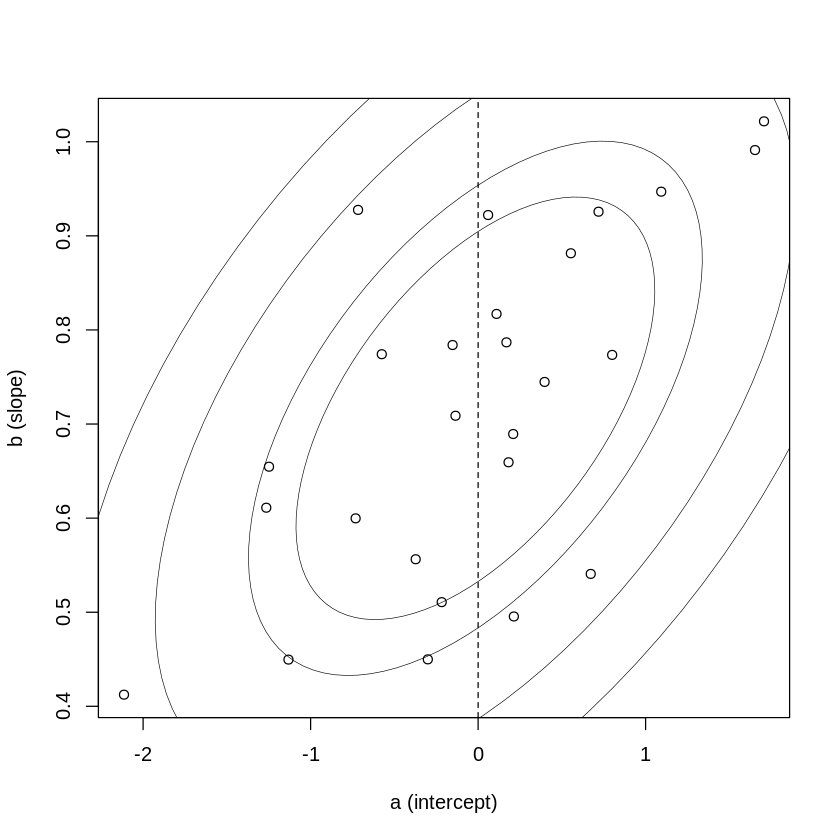

In [142]:
post <- extract.samples(m13H2)
a <- apply( post$a , 2 , mean )
b <- apply( post$b , 2 , mean )
plot( a, b , xlab="a (intercept)" , ylab="b (slope)" )
abline( h=0 , lty=2 )
abline( v=0 , lty=2 )

library(ellipse)
R <- apply( post$Rho , 2:3 , mean )
s <- apply( post$sigma_bar , 2 , mean )
S <- diag(s) %*% R %*% diag(s)
ll <- c( 0.5 , 0.67 , 0.89 , 0.97 )
for ( l in ll ) {
    el <- ellipse( S , centre=c( mean(post$a) , mean(post$b) ) , level=l )
    lines( el , col="black" , lwd=0.5 )
}

In [143]:
precis(m13H2, depth=3, pars="sigma_bar")

mean      sd         5.5%      94.5%     n_eff    Rhat     
sigma_bar[1] 0.9097772 0.13326953 0.7212346 1.1352907 2551.033 0.9999741
sigma_bar[2] 0.1906904 0.02833463 0.1503820 0.2408332 2160.132 0.9996302

The sigma_bar[1] corresponds to variation among the population of intercepts (a's), and sigma_bar[2] corresponds to variation among the population of slopes (b's).

Most of the variation can be attributed to the intercepts as sigma_bar[1] is bigger than [2], however is this the correct way to judge this issue?

13H3

In [144]:
precis(m13H2, depth=3, pars="Rho")

mean      sd           5.5%      94.5%     n_eff     Rhat     
Rho[1,1] 1.0000000 0.000000e+00 1.0000000 1.0000000       NaN       NaN
Rho[1,2] 0.5599001 1.364546e-01 0.3170393 0.7515794 2548.2629 0.9982146
Rho[2,1] 0.5599001 1.364546e-01 0.3170393 0.7515794 2548.2629 0.9982146
Rho[2,2] 1.0000000 7.027811e-17 1.0000000 1.0000000  249.1102 0.9979980

On a standardized height scale, the correlation between slopes (b) and intercepts (a) is strong (+0.56), with taller people (larger a's) tending to grow faster with age (larger b's).

13H4

In [145]:
library(MASS)
set.seed(5) # used to replicate example

Mu <- c(mean(post$a_bar), mean(post$b_bar))

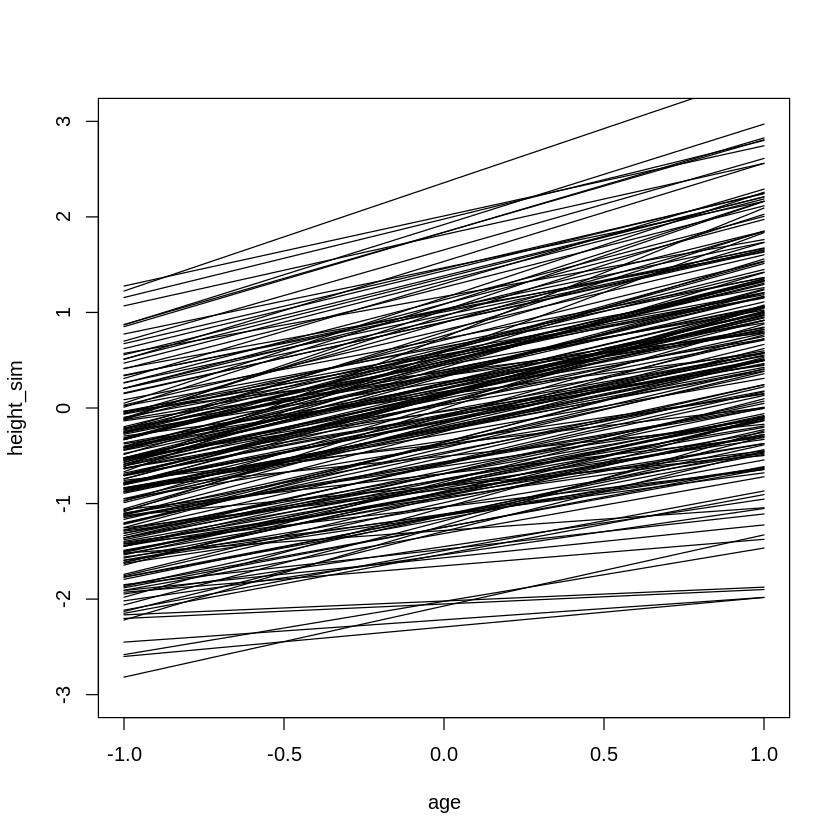

In [147]:
Nboys <- 200

boys <- mvrnorm( Nboys , Mu , S )
a_boy <- boys[,1]
b_boy <- boys[,2]
sigma <- mean(post$sigma)
age.seq <- seq( from=-1 , to=1 , length.out=30 )

plot( NULL, col=rangi2, xlab="age" , ylab="height_sim", xlim=c(-1,1), ylim=c(-3,3) )
for ( i in 1:Nboys ) lines( age.seq , a_boy[i] + b_boy[i]*age.seq + rnorm(1, 0, sigma) )

Not sure if the following is a valid way to recover the height scale (instead of standardized height)...  Seem to get some very steep slopes.

[1] 149.5194

[1] 9.10321

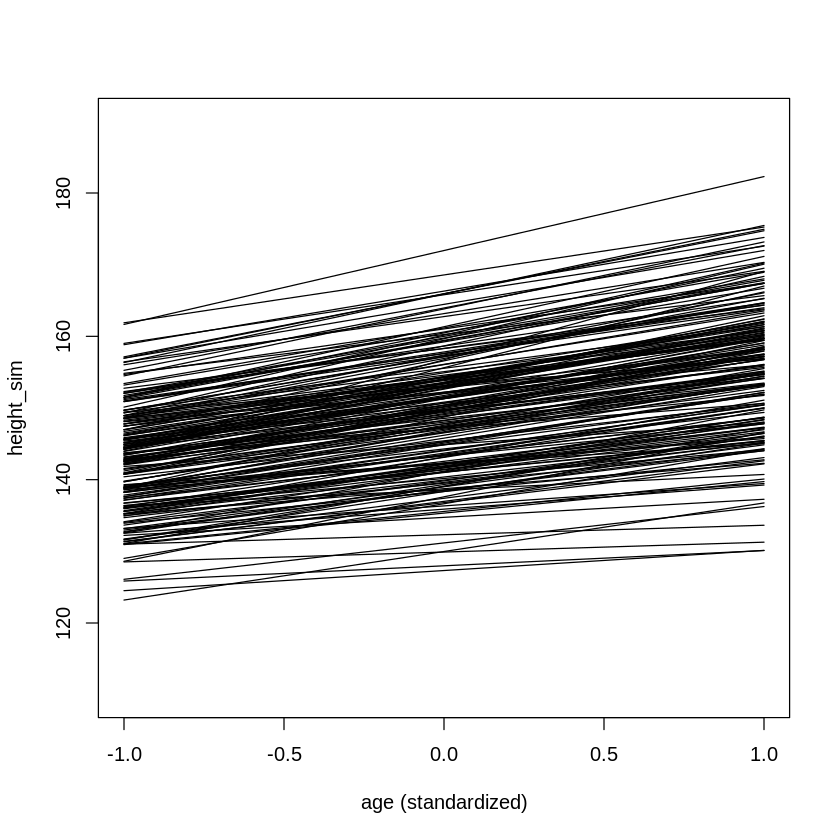

In [148]:
mean(d$height)
sd(d$height)


plot( NULL, col=rangi2, xlab="age (standardized)" , ylab="height_sim", xlim=c(-1,1), ylim=c(110,190) )
for ( i in 1:Nboys ) lines( age.seq , mean(d$height) + sd(d$height) * (a_boy[i] + b_boy[i]*age.seq + rnorm(1, 0, sigma) ) )

Let's try this analysis again, but instead of standardizing height, let's keep it on this scale.

In [149]:
head(d)

Subject age     height Occasion
1 1       -1.0000 140.5  1       
2 1       -0.7479 143.4  2       
3 1       -0.4630 144.8  3       
4 1       -0.1643 147.1  4       
5 1       -0.0027 147.7  5       
6 1        0.2466 150.2  6

In [150]:
(height.mean <- mean(d$height))

(height.sd.inv <- 1/sd(d$height))

(slope.max.inv <- (max(d$age) - min(d$age))/(max(d$height)-min(d$height)))

[1] 149.5194

[1] 0.1098514

[1] 0.04126543

In [151]:
m13H2.2 <- ulam(
            alist(
                height ~ normal(mu, sigma),
                
                mu <- a[Subject] + b[Subject] * age,
                
                c(a, b)[Subject] ~ multi_normal( c(a_bar, b_bar), Rho, sigma_bar ),
                
                a_bar ~ dnorm(150, 5),        # Use mean height for mu
                b_bar ~ dexp(0.08),               # Take half of slope max and invert = 2/24
                sigma_bar ~ dexp(0.1),
                sigma ~ dexp(1),                # Take 1 / sd(height)
            
                Rho ~ lkj_corr(2)
            
            ), data=d, chains=4, cores=4
            , control=list(max_treedepth=15)
            )

recompiling to avoid crashing R session


In [152]:
precis(m13H2.2)

58 vector or matrix parameters hidden. Use depth=2 to show them.


mean        sd         5.5%       94.5%       n_eff    Rhat     
a_bar 149.3888977 1.49349475 146.917138 151.7350736 2375.637 1.0004366
b_bar   6.5255977 0.33402850   5.992839   7.0549795 2252.700 0.9998677
sigma   0.6636426 0.03388993   0.610940   0.7183183 1789.415 0.9996069

In [153]:
precis(m13H2.2, depth=3, pars="Rho")

mean      sd           5.5%      94.5%     n_eff      Rhat     
Rho[1,1] 1.0000000 0.000000e+00 1.0000000 1.0000000        NaN       NaN
Rho[1,2] 0.5651757 1.382003e-01 0.3203241 0.7553229 2396.44495 0.9995748
Rho[2,1] 0.5651757 1.382003e-01 0.3203241 0.7553229 2396.44495 0.9995748
Rho[2,2] 1.0000000 6.804932e-17 1.0000000 1.0000000   94.91349 0.9979980

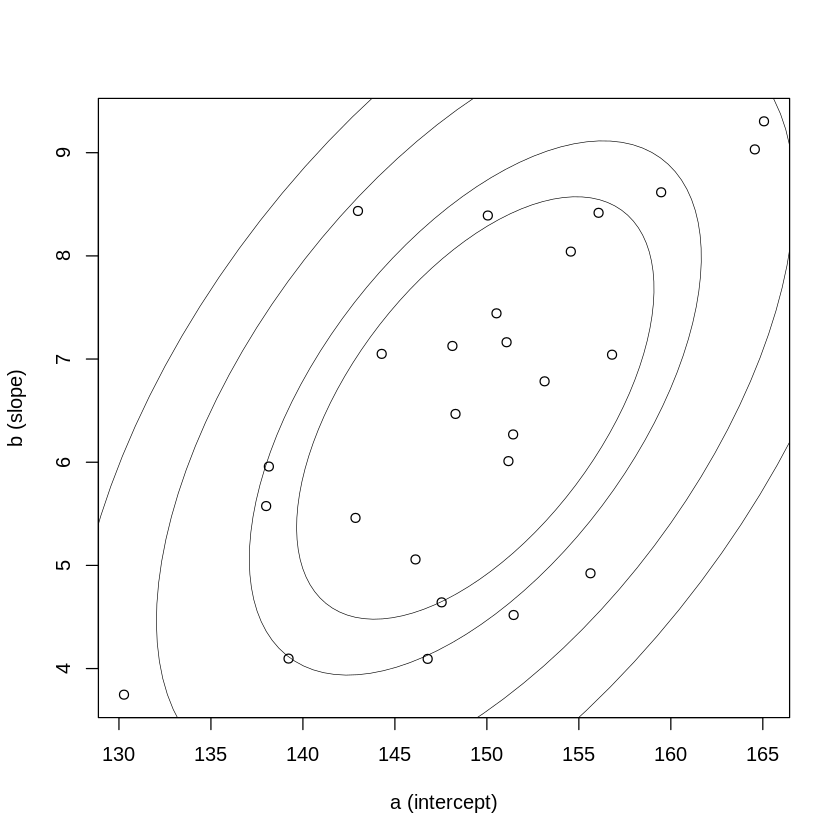

In [154]:
post <- extract.samples(m13H2.2)
a <- apply( post$a , 2 , mean )
b <- apply( post$b , 2 , mean )
plot( a, b , xlab="a (intercept)" , ylab="b (slope)" )
abline( h=0 , lty=2 )
abline( v=0 , lty=2 )

library(ellipse)
R <- apply( post$Rho , 2:3 , mean )
s <- apply( post$sigma_bar , 2 , mean )
S <- diag(s) %*% R %*% diag(s)
ll <- c( 0.5 , 0.67 , 0.89 , 0.97 )
for ( l in ll ) {
    el <- ellipse( S , centre=c( mean(post$a) , mean(post$b) ) , level=l )
    lines( el , col="black" , lwd=0.5 )
}

In [155]:
precis(m13H2.2, depth=3, pars="sigma_bar")

mean     sd       5.5%     94.5%     n_eff    Rhat     
sigma_bar[1] 8.250572 1.181773 6.572530 10.210270 2149.557 0.9985515
sigma_bar[2] 1.738778 0.253398 1.376507  2.187138 2472.543 0.9987673

In [156]:
library(MASS)
set.seed(5) # used to replicate example

Mu <- c(mean(post$a_bar), mean(post$b_bar))

[1] 0.6636426

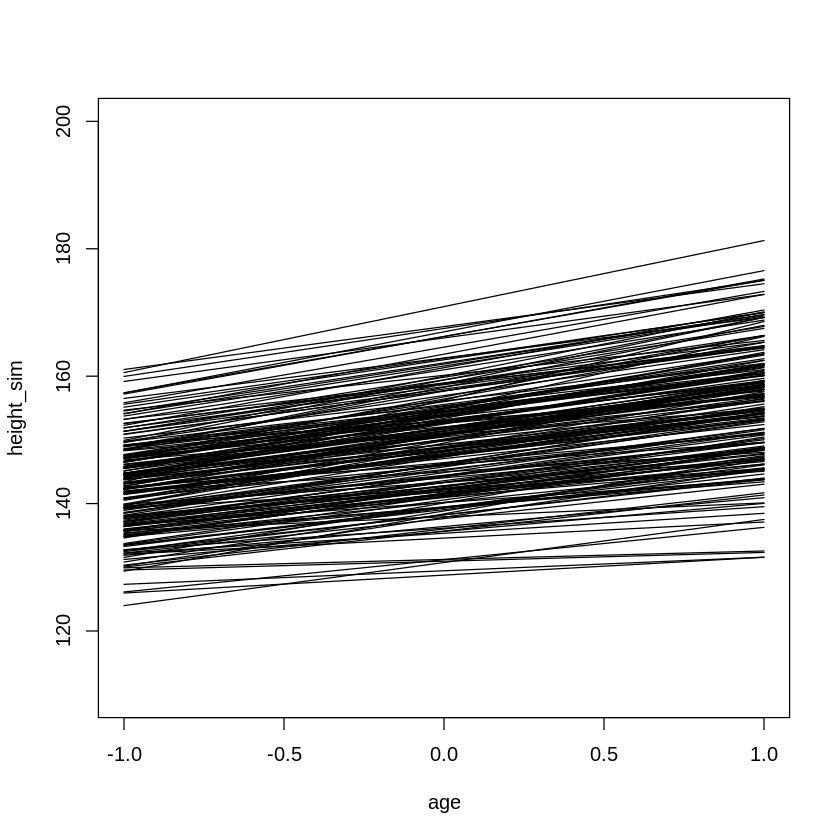

In [157]:
Nboys <- 200

boys <- mvrnorm( Nboys , Mu , S )
a_boy <- boys[,1]
b_boy <- boys[,2]
(sigma <- mean(post$sigma))
age.seq <- seq( from=-1 , to=1 , length.out=30 )

plot( NULL, col=rangi2, xlab="age" , ylab="height_sim", xlim=c(-1,1), ylim=c(110,200) )
for ( i in 1:Nboys ) lines( age.seq , a_boy[i] + b_boy[i]*age.seq + rnorm(1, 0, sigma) )

This seems very similar to the previous chart that attempted to rescale back to the normal height scale after the model was fit to a standardized height.